<a href="https://colab.research.google.com/github/Parthi1212-dotcom/Investment-Portfolio-through-Evolutionary-algorithms/blob/main/Hybrid_quant_dataset_6th_Aug_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import warnings

warnings.filterwarnings('ignore')

def add_all_features(group, market_data):
    """
    Calculates a full suite of technical and fundamental indicators for a stock's data.
    """
    group = group.copy()

    # --- Technical Indicators ---
    group['MA_20'] = group['Close'].rolling(window=20).mean()
    group['MA_50'] = group['Close'].rolling(window=50).mean()
    group['MA_200'] = group['Close'].rolling(window=200).mean()
    group['Volatility_20'] = group['Close'].rolling(window=20).std()

    delta = group['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    group['RSI_14'] = 100 - (100 / (1 + rs))

    ema12 = group['Close'].ewm(span=12, adjust=False).mean()
    ema26 = group['Close'].ewm(span=26, adjust=False).mean()
    group['MACD'] = ema12 - ema26

    high_low = group['High'] - group['Low']
    high_close = np.abs(group['High'] - group['Close'].shift())
    low_close = np.abs(group['Low'] - group['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    group['ATR_14'] = true_range.rolling(window=14).mean()

    # --- Market-Relative Metrics ---
    group = group.join(market_data)
    rolling_cov = group['Return'].rolling(window=60).cov(group['Market_Return'])
    rolling_var = group['Market_Return'].rolling(window=60).var()
    group['Beta'] = rolling_cov / rolling_var

    return group

def create_new_dataset(tickers, start_date='2016-01-01', end_date='2024-01-01'):
    """
    Downloads historical data, engineers features, and saves the result to a new CSV file.
    """
    print("--- Creating New Quantitative Dataset ---")

    # --- Step 1: Download data ---
    all_tickers_to_download = tickers + ['SPY']
    print(f"Downloading historical data for {len(all_tickers_to_download)} assets...")
    data = yf.download(all_tickers_to_download, start=start_date, end=end_date)
    print("Data download complete.")

    # --- Step 2: Prepare data ---
    df = data.stack().rename_axis(['Date', 'Ticker']).reset_index()
    df = df.rename(columns={'Adj Close': 'Close'})
    df.sort_values(['Ticker', 'Date'], inplace=True)
    df['Return'] = df.groupby('Ticker')['Close'].pct_change()
    spy_returns = df[df['Ticker'] == 'SPY'][['Date', 'Return']].set_index('Date').rename(columns={'Return': 'Market_Return'})

    # --- Step 3: Apply feature engineering ---
    print("Engineering features for all tickers...")

    # --- FIXED: Correctly handle the index after the groupby operation ---
    # The result of apply() has a multi-index ('Ticker', 'Date').
    # We reset the 'Date' index to a column, and drop the 'Ticker' index level
    # because 'Ticker' already exists as a column in the data.
    df_featured = df.groupby('Ticker').apply(lambda x: add_all_features(x.set_index('Date'), spy_returns))
    df_featured = df_featured.reset_index(level=0, drop=True).reset_index()
    # --- End of Fix ---

    # --- Step 4: Add Placeholder Fundamental Ratios ---
    df_featured['PE_Ratio'] = np.nan
    df_featured['PB_Ratio'] = np.nan
    df_featured['EPS_TTM'] = np.nan
    df_featured['Dividend_Yield'] = np.nan
    df_featured['Market_Cap'] = np.nan

    # --- Step 5: Clean and Save ---
    final_df = df_featured.dropna(subset=['MA_200', 'Beta']).copy()
    final_df = final_df.drop(columns=['Market_Return'], errors='ignore')

    output_filename = 'my_new_quant_dataset.csv'
    final_df.to_csv(output_filename, index=False)

    print(f"\n--- SUCCESS ---")
    print(f"New dataset with {len(final_df)} rows created and saved as '{output_filename}'")

    print("\n--- Sample of the new dataset for AAPL ---")
    print(final_df[final_df['Ticker'] == 'AAPL'].tail().round(2).to_string())

# --- Run the Dataset Creator ---
tickers_to_include = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V', 'PG', 'XOM', 'BA']
create_new_dataset(tickers_to_include)

[                       0%                       ]

--- Creating New Quantitative Dataset ---


[*********************100%***********************]  13 of 13 completed


Data download complete.
Engineering features for all tickers...

--- SUCCESS ---
New dataset with 23569 rows created and saved as 'my_new_quant_dataset.csv'

--- Sample of the new dataset for AAPL ---
Price       Date Ticker   Close    High     Low    Open    Volume  Return   MA_20   MA_50  MA_200  Volatility_20  RSI_14  MACD  ATR_14  Beta  PE_Ratio  PB_Ratio  EPS_TTM  Dividend_Yield  Market_Cap
2007  2023-12-22   AAPL  192.19  193.99  191.57  193.76  37149600   -0.01  192.26  183.96  176.98           2.89   59.25  2.64    2.92  0.86       NaN       NaN      NaN             NaN         NaN
2008  2023-12-26   AAPL  191.65  192.48  191.43  192.20  28919300   -0.00  192.42  184.25  177.20           2.75   49.03  2.31    2.64  0.86       NaN       NaN      NaN             NaN         NaN
2009  2023-12-27   AAPL  191.75  192.09  189.70  191.09  48087700    0.00  192.56  184.54  177.42           2.64   52.29  2.03    2.63  0.87       NaN       NaN      NaN             NaN         NaN
2010  2

In [3]:
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

def create_fundamental_dataset(tickers):
    """
    Fetches current fundamental data for a list of tickers from Yahoo Finance
    and creates a new dataset.
    """
    print("--- Creating New Fundamental Snapshot Dataset ---")

    fundamental_data = []

    print(f"Fetching data for {len(tickers)} tickers. This may take a moment...")

    # Loop through each ticker to get its info
    for ticker_symbol in tickers:
        try:
            # Create a Ticker object
            ticker_obj = yf.Ticker(ticker_symbol)

            # .info is a dictionary containing a wealth of fundamental data
            info = ticker_obj.info

            # Extract the specific data points we need.
            # We use .get() to avoid errors if a data point is missing.
            data_point = {
                'Ticker': ticker_symbol,
                'Company_Name': info.get('longName'),
                'Sector': info.get('sector'),
                'Industry': info.get('industry'),
                'Market_Cap': info.get('marketCap'),
                'PE_Ratio': info.get('trailingPE'),
                'PB_Ratio': info.get('priceToBook'),
                'EPS_TTM': info.get('trailingEps'),
                'Dividend_Yield': info.get('dividendYield', 0) * 100 # Convert to percentage
            }

            fundamental_data.append(data_point)
            print(f"  > Successfully fetched data for {ticker_symbol}")

        except Exception as e:
            print(f"  > Could not fetch data for {ticker_symbol}. Error: {e}")
            continue

    # --- Create and Save the Final Dataset ---
    if not fundamental_data:
        print("No data was fetched. Could not create the dataset.")
        return

    df = pd.DataFrame(fundamental_data)

    output_filename = 'fundamental_snapshot_dataset.csv'
    df.to_csv(output_filename, index=False)

    print(f"\n--- SUCCESS ---")
    print(f"New fundamental dataset with {len(df)} rows created and saved as '{output_filename}'")

    print("\n--- Sample of the new dataset ---")
    print(df.head().round(2).to_string())

# --- Run the Dataset Creator ---
# A diverse list of tickers for a robust dataset
tickers_to_include = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V', 'PG', 'XOM', 'BA']
create_fundamental_dataset(tickers_to_include)

--- Creating New Fundamental Snapshot Dataset ---
Fetching data for 12 tickers. This may take a moment...
  > Successfully fetched data for AAPL
  > Successfully fetched data for MSFT
  > Successfully fetched data for GOOG
  > Successfully fetched data for AMZN
  > Successfully fetched data for TSLA
  > Successfully fetched data for NVDA
  > Successfully fetched data for JPM
  > Successfully fetched data for JNJ
  > Successfully fetched data for V
  > Successfully fetched data for PG
  > Successfully fetched data for XOM
  > Successfully fetched data for BA

--- SUCCESS ---
New fundamental dataset with 12 rows created and saved as 'fundamental_snapshot_dataset.csv'

--- Sample of the new dataset ---
  Ticker           Company_Name                  Sector                        Industry     Market_Cap  PE_Ratio  PB_Ratio  EPS_TTM  Dividend_Yield
0   AAPL             Apple Inc.              Technology            Consumer Electronics  3011413803008     30.79     45.80     6.59            

In [4]:
import pandas as pd
import yfinance as yf
import numpy as np
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

def add_all_features(group, market_data):
    """
    Calculates a full suite of technical indicators for a stock's data.
    """
    group = group.copy()

    # --- Technical Indicators ---
    group['MA_20'] = group['Close'].rolling(window=20).mean()
    group['MA_50'] = group['Close'].rolling(window=50).mean()
    group['MA_200'] = group['Close'].rolling(window=200).mean()
    group['Volatility_20'] = group['Close'].rolling(window=20).std()

    # RSI
    delta = group['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    group['RSI_14'] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = group['Close'].ewm(span=12, adjust=False).mean()
    ema26 = group['Close'].ewm(span=26, adjust=False).mean()
    group['MACD'] = ema12 - ema26

    # ATR
    high_low = group['High'] - group['Low']
    high_close = np.abs(group['High'] - group['Close'].shift())
    low_close = np.abs(group['Low'] - group['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    group['ATR_14'] = true_range.rolling(window=14).mean()

    # --- Market-Relative Metrics ---
    # Merge with market data to calculate Beta
    group = group.join(market_data)

    # Beta Calculation (using a 60-day rolling window)
    rolling_cov = group['Return'].rolling(window=60).cov(group['Market_Return'])
    rolling_var = group['Market_Return'].rolling(window=60).var()
    group['Beta'] = rolling_cov / rolling_var

    return group

def create_new_dataset_from_yfinance(tickers, start_date='2016-01-01', end_date='2024-01-01'):
    """
    Downloads historical data for a list of tickers using yfinance,
    engineers a full suite of features, and saves the result to a new CSV file.
    """
    print("--- Creating New Quantitative Dataset from Yahoo Finance ---")

    # --- Step 1: Download all necessary data ---
    all_tickers_to_download = tickers + ['SPY'] # Include SPY for Beta calculation
    print(f"Downloading historical data for {len(all_tickers_to_download)} assets...")
    try:
        data = yf.download(all_tickers_to_download, start=start_date, end=end_date)
        if data.empty:
            print("Error: No data downloaded. Check ticker symbols and date range.")
            return
        print("Data download complete.")
    except Exception as e:
        print(f"An error occurred during download: {e}")
        return

    # --- Step 2: Prepare the data for feature engineering ---
    df = data.stack().rename_axis(['Date', 'Ticker']).reset_index()
    df = df.rename(columns={'Adj Close': 'Close'}) # Use Adj Close for accurate returns
    df.sort_values(['Ticker', 'Date'], inplace=True)

    df['Return'] = df.groupby('Ticker')['Close'].pct_change()

    # Prepare a separate market return series for Beta calculation
    spy_returns = df[df['Ticker'] == 'SPY'][['Date', 'Return']].set_index('Date').rename(columns={'Return': 'Market_Return'})

    # --- Step 3: Apply the feature engineering function ---
    print("Engineering features for all tickers...")
    df_featured = df.groupby('Ticker').apply(lambda x: add_all_features(x.set_index('Date'), spy_returns))
    df_featured = df_featured.reset_index(level=0, drop=True).reset_index()

    # --- Step 4: Add Placeholder Fundamental Ratios ---
    # As discussed, yfinance does not provide reliable historical fundamentals.
    # We add these as empty columns so the structure matches your original file.
    df_featured['PE_Ratio'] = np.nan
    df_featured['PB_Ratio'] = np.nan
    df_featured['EPS_TTM'] = np.nan
    df_featured['Dividend_Yield'] = np.nan
    df_featured['Market_Cap'] = np.nan

    # --- Step 5: Clean and Save the Final Dataset ---
    final_df = df_featured.dropna(subset=['MA_200', 'Beta']).copy()
    final_df = final_df.drop(columns=['Market_Return'], errors='ignore')

    # Reorder columns to match your original dataset's format
    column_order = [
        'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'Return',
        'MA_20', 'MA_50', 'Volatility_20', 'RSI_14', 'MACD', 'ATR_14', 'EPS_TTM',
        'PE_Ratio', 'Market_Cap', 'PB_Ratio', 'Dividend_Yield', 'Beta'
    ]
    # Filter for columns that exist to avoid errors
    final_df = final_df[[col for col in column_order if col in final_df.columns]]

    output_filename = 'yfinance_quant_dataset.csv'
    final_df.to_csv(output_filename, index=False)

    print(f"\n--- SUCCESS ---")
    print(f"New dataset with {len(final_df)} rows created and saved as '{output_filename}'")

    print("\n--- Sample of the new dataset for AAPL ---")
    print(final_df[final_df['Ticker'] == 'AAPL'].tail().round(2).to_string())

# --- Run the Dataset Creator ---
# A diverse list of tickers for a robust dataset
tickers_to_include = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V', 'PG', 'XOM', 'BA']
create_new_dataset_from_yfinance(tickers_to_include)

[*******               15%                       ]  2 of 13 completed

--- Creating New Quantitative Dataset from Yahoo Finance ---


[*********************100%***********************]  13 of 13 completed


Data download complete.
Engineering features for all tickers...

--- SUCCESS ---
New dataset with 23569 rows created and saved as 'yfinance_quant_dataset.csv'

--- Sample of the new dataset for AAPL ---
Price       Date    Open    High     Low   Close    Volume Ticker  Return   MA_20   MA_50  Volatility_20  RSI_14  MACD  ATR_14  EPS_TTM  PE_Ratio  Market_Cap  PB_Ratio  Dividend_Yield  Beta
2007  2023-12-22  193.76  193.99  191.57  192.19  37149600   AAPL   -0.01  192.26  183.96           2.89   59.25  2.64    2.92      NaN       NaN         NaN       NaN             NaN  0.86
2008  2023-12-26  192.20  192.48  191.43  191.65  28919300   AAPL   -0.00  192.42  184.25           2.75   49.03  2.31    2.64      NaN       NaN         NaN       NaN             NaN  0.86
2009  2023-12-27  191.09  192.09  189.70  191.75  48087700   AAPL    0.00  192.56  184.54           2.64   52.29  2.03    2.63      NaN       NaN         NaN       NaN             NaN  0.87
2010  2023-12-28  192.73  193.24  191

In [5]:
import pandas as pd
import yfinance as yf
import numpy as np
import warnings

warnings.filterwarnings('ignore')

def add_technical_features(group, market_data):
    """
    Calculates technical indicators for a stock's data.
    """
    group = group.copy()

    # Technical Indicators
    group['MA_20'] = group['Close'].rolling(window=20).mean()
    group['MA_50'] = group['Close'].rolling(window=50).mean()
    group['MA_200'] = group['Close'].rolling(window=200).mean()
    group['Volatility_20'] = group['Close'].rolling(window=20).std()

    delta = group['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    group['RSI_14'] = 100 - (100 / (1 + rs))

    ema12 = group['Close'].ewm(span=12, adjust=False).mean()
    ema26 = group['Close'].ewm(span=26, adjust=False).mean()
    group['MACD'] = ema12 - ema26

    high_low = group['High'] - group['Low']
    high_close = np.abs(group['High'] - group['Close'].shift())
    low_close = np.abs(group['Low'] - group['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    group['ATR_14'] = true_range.rolling(window=14).mean()

    # Market-Relative Metrics
    group = group.join(market_data)
    rolling_cov = group['Return'].rolling(window=60).cov(group['Market_Return'])
    rolling_var = group['Market_Return'].rolling(window=60).var()
    group['Beta'] = rolling_cov / rolling_var

    return group

def create_hybrid_dataset(tickers, start_date='2016-01-01', end_date='2024-01-01'):
    """
    Creates a new dataset with historical technicals and a snapshot of
    current fundamentals.
    """
    print("--- Creating New Hybrid Quantitative Dataset ---")

    # --- Step 1: Download Historical Price Data ---
    all_tickers_to_download = tickers + ['SPY']
    print(f"Downloading historical price data for {len(all_tickers_to_download)} assets...")
    data = yf.download(all_tickers_to_download, start=start_date, end=end_date)
    print("Price data download complete.")

    df_price = data.stack().rename_axis(['Date', 'Ticker']).reset_index()
    df_price = df_price.rename(columns={'Adj Close': 'Close'})
    df_price.sort_values(['Ticker', 'Date'], inplace=True)
    df_price['Return'] = df_price.groupby('Ticker')['Close'].pct_change()
    spy_returns = df_price[df_price['Ticker'] == 'SPY'][['Date', 'Return']].set_index('Date').rename(columns={'Return': 'Market_Return'})

    # --- Step 2: Calculate Historical Technical Indicators ---
    print("Engineering historical technical features...")
    df_tech = df_price.groupby('Ticker').apply(lambda x: add_technical_features(x.set_index('Date'), spy_returns))
    df_tech = df_tech.reset_index(level=0, drop=True).reset_index()

    # --- Step 3: Fetch CURRENT Fundamental Data Snapshot ---
    print("Fetching current fundamental data snapshot for all tickers...")
    fundamental_data = []
    for ticker_symbol in tickers:
        try:
            info = yf.Ticker(ticker_symbol).info
            data_point = {
                'Ticker': ticker_symbol,
                'PE_Ratio': info.get('trailingPE'),
                'PB_Ratio': info.get('priceToBook'),
                'EPS_TTM': info.get('trailingEps'),
                'Dividend_Yield': info.get('dividendYield', 0) * 100,
                'Market_Cap': info.get('marketCap')
            }
            fundamental_data.append(data_point)
            print(f"  > Fetched fundamentals for {ticker_symbol}")
        except Exception:
            print(f"  > Could not fetch fundamentals for {ticker_symbol}")
            continue

    df_fund = pd.DataFrame(fundamental_data)

    # --- Step 4: Merge Historical Technicals with Current Fundamentals ---
    print("Merging historical technical data with current fundamental data...")
    final_df = pd.merge(df_tech, df_fund, on='Ticker', how='left')

    # --- Step 5: Clean and Save the Final Dataset ---
    final_df = final_df.dropna(subset=['MA_200', 'Beta']).copy()
    final_df = final_df.drop(columns=['Market_Return'], errors='ignore')

    output_filename = 'hybrid_quant_dataset.csv'
    final_df.to_csv(output_filename, index=False)

    print(f"\n--- SUCCESS ---")
    print(f"New hybrid dataset with {len(final_df)} rows created and saved as '{output_filename}'")

    print("\n--- Sample of the new, complete dataset for AAPL ---")
    print(final_df[final_df['Ticker'] == 'AAPL'].tail().round(2).to_string())

# --- Run the Dataset Creator ---
tickers_to_include = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V', 'PG', 'XOM', 'BA']
create_hybrid_dataset(tickers_to_include)

[***********           23%                       ]  3 of 13 completed

--- Creating New Hybrid Quantitative Dataset ---


[*********************100%***********************]  13 of 13 completed


Price data download complete.
Engineering historical technical features...
Fetching current fundamental data snapshot for all tickers...
  > Fetched fundamentals for AAPL
  > Fetched fundamentals for MSFT
  > Fetched fundamentals for GOOG
  > Fetched fundamentals for AMZN
  > Fetched fundamentals for TSLA
  > Fetched fundamentals for NVDA
  > Fetched fundamentals for JPM
  > Fetched fundamentals for JNJ
  > Fetched fundamentals for V
  > Fetched fundamentals for PG
  > Fetched fundamentals for XOM
  > Fetched fundamentals for BA
Merging historical technical data with current fundamental data...

--- SUCCESS ---
New hybrid dataset with 23569 rows created and saved as 'hybrid_quant_dataset.csv'

--- Sample of the new, complete dataset for AAPL ---
           Date Ticker   Close    High     Low    Open    Volume  Return   MA_20   MA_50  MA_200  Volatility_20  RSI_14  MACD  ATR_14  Beta  PE_Ratio  PB_Ratio  EPS_TTM  Dividend_Yield    Market_Cap
2007 2023-12-22   AAPL  192.19  193.99  191.5

In [6]:
df = pd.read_csv('/content/hybrid_quant_dataset.csv')

In [7]:
df.head()

Date Ticker      Close       High        Low       Open    Volume  \
0  2016-10-17   AAPL  27.011919  27.078557  26.834979  26.961365  94499600   
1  2016-10-18   AAPL  26.993540  27.163585  26.988943  27.156691  98214000   
2  2016-10-19   AAPL  26.913111  27.060177  26.150205  26.942983  80138400   
3  2016-10-20   AAPL  26.899319  26.972852  26.731572  26.853361  96503200   
4  2016-10-21   AAPL  26.793613  26.864850  26.720080  26.841869  92770800   

     Return      MA_20      MA_50  ...  Volatility_20     RSI_14      MACD  \
0 -0.000680  26.287733  25.474618  ...       0.424946  72.434762  0.462568   
1 -0.000680  26.332542  25.516440  ...       0.450307  69.214221  0.462176   
2 -0.002980  26.373560  25.554631  ...       0.464456  81.912603  0.450186   
3 -0.000512  26.401594  25.596269  ...       0.478933  78.932441  0.434562   
4 -0.003930  26.446288  25.636115  ...       0.471282  79.737557  0.408936   

     ATR_14      Beta   PE_Ratio  PB_Ratio  EPS_TTM  Dividend_Yield  \
0  0.363069  0.847227  30.792109  45.79553     6.59            51.0   
1  0.350103  0.802744  30.792109  45.79553     6.59            51.0   
2  0.379811  0.794665  30.792109  45.79553     6.59            51.0   
3  0.371276  0.823985  30.792109  45.79553     6.59            51.0   
4  0.371440  0.816312  30.792109  45.79553     6.59            51.0   

     Market_Cap  
0  3.011414e+12  
1  3.011414e+12  
2  3.011414e+12  
3  3.011414e+12  
4  3.011414e+12  

[5 rows x 21 columns]

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import warnings

# Suppress warnings for a cleaner report
warnings.filterwarnings('ignore')

# --- Helper Function: Backtesting Engine ---
def run_backtest_engine(ticker_df, initial_capital=100000.0, risk_per_trade=0.02):
    """The core backtesting logic for our Mean Reversion strategy."""
    # Ensure required columns exist and have no null values
    required_cols = ['Date', 'Close', 'Open', 'RSI_14', 'ATR_14']
    if not all(col in ticker_df.columns for col in required_cols):
        print("  > Backtest failed: Missing one or more required columns.")
        return None, None
    ticker_df.dropna(subset=required_cols, inplace=True)
    if ticker_df.empty:
        print("  > Backtest failed: No data available after cleaning.")
        return None, None

    cash = initial_capital
    portfolio_value = initial_capital
    holdings = 0
    in_position = False
    portfolio_history = []
    trades_log = []
    stop_loss_price, profit_target_price = 0, 0

    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close'] if in_position else cash
        portfolio_history.append({'Date': row['Date'], 'Value': portfolio_value})

        if in_position:
            if row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price:
                cash += holdings * row['Close']
                trades_log.append({'Date': row['Date'], 'Type': 'Sell', 'Price': row['Close']})
                holdings, in_position = 0, False
        elif not in_position:
            is_oversold_ish = row['RSI_14'] < 45
            is_reversing = row['Close'] > row['Open']

            if is_oversold_ish and is_reversing:
                stop_loss_price = row['Close'] - (2 * row['ATR_14'])
                risk_per_share = row['Close'] - stop_loss_price
                if risk_per_share > 0:
                    shares_to_buy = (portfolio_value * risk_per_trade) / risk_per_share
                    entry_value = shares_to_buy * row['Close']
                    if cash >= entry_value:
                        holdings, cash, in_position = shares_to_buy, cash - entry_value, True
                        entry_price = row['Close']
                        profit_target_price = entry_price + (3 * risk_per_share)
                        trades_log.append({'Date': row['Date'], 'Type': 'Buy', 'Price': entry_price})

    return pd.DataFrame(portfolio_history), trades_log

# --- Main Analysis Function ---
def run_full_quantitative_analysis(file_path, ticker_to_analyze):
    """
    Runs a complete quantitative analysis for a single stock from the dataset.
    """
    print("="*80)
    print(f"               Running Full Quantitative Analysis for: {ticker_to_analyze}")
    print("="*80)

    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"\nCRITICAL ERROR: The dataset file '{file_path}' was not found.")
        print("Please upload the file and ensure the path is correct.")
        return

    # --- Step 1: Data Loading & Preparation ---
    print("\n--- [Step 1] Loading and Preparing Data ---")
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    df_full.dropna(subset=['Date'], inplace=True)

    ticker_df = df_full[df_full['Ticker'] == ticker_to_analyze].copy()
    ticker_df.sort_values('Date', inplace=True)
    ticker_df.reset_index(drop=True, inplace=True)

    if ticker_df.empty:
        print(f"No data found for {ticker_to_analyze}.")
        return
    print(f"Data for {ticker_to_analyze} loaded successfully.")

    # --- Step 2: Fundamental & Valuation Snapshot ---
    print("\n--- [Step 2] Analyzing Fundamentals and Intrinsic Value ---")
    latest_data = ticker_df.iloc[-1]

    # DDM Calculation
    risk_free_rate = 0.0422
    market_risk_premium = 0.0448
    assumed_growth_rate = 0.025

    cost_of_equity = risk_free_rate + (latest_data['Beta'] * market_risk_premium)
    dividend_yield_decimal = latest_data['Dividend_Yield'] / 100.0 if latest_data['Dividend_Yield'] > 0 else 0

    intrinsic_value = "N/A"
    if dividend_yield_decimal > 0 and cost_of_equity > assumed_growth_rate:
        dividend_per_share = dividend_yield_decimal * latest_data['Close']
        intrinsic_value = (dividend_per_share * (1 + assumed_growth_rate)) / (cost_of_equity - assumed_growth_rate)

    print("Fundamental Snapshot:")
    print(f"  - Last Close Price: ${latest_data['Close']:.2f}")
    print(f"  - P/E Ratio: {latest_data['PE_Ratio']:.2f}")
    print(f"  - Dividend Yield: {latest_data['Dividend_Yield']:.2f}%")
    print(f"  - Beta: {latest_data['Beta']:.2f}")
    if isinstance(intrinsic_value, float):
        print(f"  - DDM Intrinsic Value: ${intrinsic_value:.2f} per share")
        if latest_data['Close'] < intrinsic_value:
             print("  - Verdict: Potentially UNDERVALUED")
        else:
             print("  - Verdict: Potentially OVERVALUED")
    else:
        print(f"  - DDM Intrinsic Value: {intrinsic_value} (No Dividend or g>=r)")

    # --- Step 3: Multi-Factor Ranking ---
    print("\n--- [Step 3] Calculating Multi-Factor Ranking ---")
    latest_all = df_full.loc[df_full.groupby('Ticker')['Date'].idxmax()].copy()
    latest_all = latest_all[(latest_all['PE_Ratio'] > 0) & (latest_all['EPS_TTM'] > 0)].dropna()

    latest_all['Value_Rank'] = latest_all['PE_Ratio'].rank(ascending=True, pct=True) * 100
    latest_all['Momentum_Rank'] = latest_all['RSI_14'].rank(ascending=False, pct=True) * 100
    latest_all['Quality_Rank'] = latest_all['EPS_TTM'].rank(ascending=False, pct=True) * 100
    latest_all['Composite_Score'] = (latest_all['Value_Rank'] + latest_all['Momentum_Rank'] + latest_all['Quality_Rank']) / 3
    latest_all['Overall_Rank'] = latest_all['Composite_Score'].rank(ascending=False)

    if ticker_to_analyze in latest_all['Ticker'].values:
        ticker_rank_info = latest_all[latest_all['Ticker'] == ticker_to_analyze].iloc[0]
        print(f"Contextual Ranking for {ticker_to_analyze}:")
        print(f"  - Overall Rank: {int(ticker_rank_info['Overall_Rank'])} out of {len(latest_all)} stocks")
        print(f"  - Composite Score: {ticker_rank_info['Composite_Score']:.2f} (Percentile)")
    else:
        print(f"Could not rank {ticker_to_analyze}, likely due to missing data.")

    # --- Step 4: Strategy Backtesting ---
    print("\n--- [Step 4] Running Strategy Backtest ---")
    portfolio_df, trades_log = run_backtest_engine(ticker_df)

    if portfolio_df is None:
        print("Backtest failed. Aborting report.")
        return
    print("Backtest simulation completed successfully.")

    # --- Step 5: Performance Reporting & Visualization ---
    print("\n--- [Step 5] Generating Final Reports and Charts ---")

    # a) Performance Tear Sheet
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(f'Performance Tear Sheet: {ticker_to_analyze}', fontsize=18)
    ax1.plot(portfolio_df['Date'], portfolio_df['Value'], label='Strategy Equity Curve')
    buy_hold = (ticker_df['Close'] / ticker_df['Close'].iloc[0]) * 100000.0
    ax1.plot(ticker_df['Date'], buy_hold, label='Buy & Hold Benchmark', linestyle='--')
    ax1.set_ylabel('Portfolio Value ($)'); ax1.legend(); ax1.grid(True)

    rolling_max = portfolio_df['Value'].cummax()
    daily_drawdown = portfolio_df['Value'] / rolling_max - 1.0
    ax2.fill_between(portfolio_df['Date'], daily_drawdown*100, 0, color='red', alpha=0.3)
    ax2.set_ylabel('Drawdown (%)'); ax2.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.savefig(f'final_tearsheet_{ticker_to_analyze}.png'); plt.close()
    print(f"  > Performance Tear Sheet saved as 'final_tearsheet_{ticker_to_analyze}.png'")

    # b) Trade Execution Chart
    if trades_log:
        trades_df = pd.DataFrame(trades_log)
        buys = trades_df[trades_df['Type'] == 'Buy']; sells = trades_df[trades_df['Type'] == 'Sell']
        plt.figure(figsize=(14, 7)); plt.plot(ticker_df['Date'], ticker_df['Close'], alpha=0.7)
        plt.scatter(buys['Date'], buys['Price'], marker='^', color='green', s=150, label='Buy')
        plt.scatter(sells['Date'], sells['Price'], marker='v', color='red', s=150, label='Sell')
        plt.title(f'Trade Executions for {ticker_to_analyze}'); plt.legend(); plt.grid(True)

        plt.tight_layout(); plt.savefig(f'final_trades_{ticker_to_analyze}.png'); plt.close()
        print(f"  > Trade Execution Chart saved as 'final_trades_{ticker_to_analyze}.png'")

    print("\n" + "="*80)
    print("                      >>> ANALYSIS COMPLETE <<<")
    print("="*80)

# --- How to Run the Full Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
ticker_to_run = 'XOM'

run_full_quantitative_analysis(your_daily_file, ticker_to_run)


               Running Full Quantitative Analysis for: XOM

--- [Step 1] Loading and Preparing Data ---
Data for XOM loaded successfully.

--- [Step 2] Analyzing Fundamentals and Intrinsic Value ---
Fundamental Snapshot:
  - Last Close Price: $94.95
  - P/E Ratio: 15.25
  - Dividend Yield: 369.00%
  - Beta: 0.39
  - DDM Intrinsic Value: $10338.82 per share
  - Verdict: Potentially UNDERVALUED

--- [Step 3] Calculating Multi-Factor Ranking ---
Contextual Ranking for XOM:
  - Overall Rank: 7 out of 11 stocks
  - Composite Score: 54.55 (Percentile)

--- [Step 4] Running Strategy Backtest ---
Backtest simulation completed successfully.

--- [Step 5] Generating Final Reports and Charts ---
  > Performance Tear Sheet saved as 'final_tearsheet_XOM.png'
  > Trade Execution Chart saved as 'final_trades_XOM.png'

                      >>> ANALYSIS COMPLETE <<<


--- Generating Advanced Dissertation Visuals ---
  > Preparing data for Spider Chart...
  > Spider Chart saved as 'spider_chart_comparison.png'


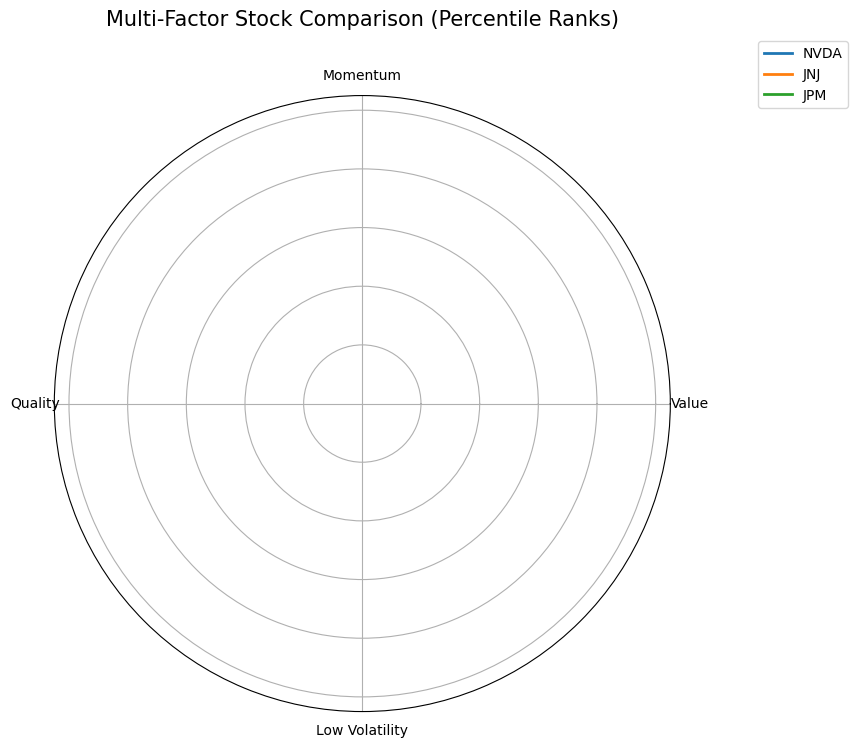


  > Preparing data for Rolling Risk Analysis...
  > Rolling Risk chart for NVDA saved as 'rolling_risk_analysis_NVDA.png'


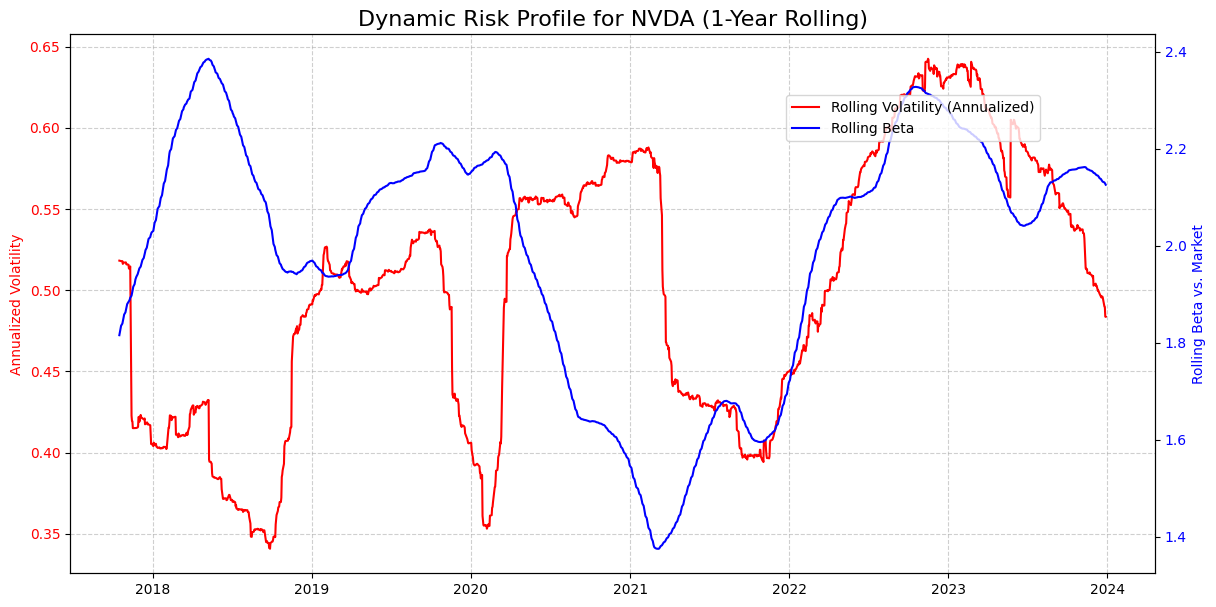

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def generate_dissertation_visuals(file_path, tickers_to_compare):
    """
    Generates a spider chart for factor comparison and a rolling risk
    analysis chart for a dissertation.
    """
    print("--- Generating Advanced Dissertation Visuals ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df.dropna(subset=['Date'], inplace=True)

    # --- Part 1: Spider Chart for Factor Comparison ---
    print("  > Preparing data for Spider Chart...")

    # Get the latest data for all tickers
    latest_data = df.loc[df.groupby('Ticker')['Date'].idxmax()].copy()
    latest_data = latest_data[(latest_data['PE_Ratio'] > 0) & (latest_data['EPS_TTM'] > 0)].dropna()

    # Define our factors
    # Note: For Low Volatility, we rank ascending=True because lower is better.
    factors = {
        'Value': latest_data['PE_Ratio'].rank(ascending=True, pct=True),
        'Momentum': latest_data['RSI_14'].rank(ascending=False, pct=True),
        'Quality': latest_data['EPS_TTM'].rank(ascending=False, pct=True),
        'Low Volatility': latest_data['Volatility_20'].rank(ascending=True, pct=True)
    }
    factor_df = pd.DataFrame(factors, index=latest_data['Ticker']) * 100 # Convert to percentile score

    # Filter for the tickers we want to plot
    plot_df = factor_df.loc[tickers_to_compare]

    # --- Create the Spider Chart ---
    labels = plot_df.columns
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] # Complete the loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for index, row in plot_df.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1] # Complete the loop
        ax.plot(angles, values, label=index, linewidth=2)
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title('Multi-Factor Stock Comparison (Percentile Ranks)', size=15, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.savefig('spider_chart_comparison.png')
    print("  > Spider Chart saved as 'spider_chart_comparison.png'")
    plt.show()

    # --- Part 2: Rolling Risk Analysis ---
    print("\n  > Preparing data for Rolling Risk Analysis...")

    # Let's analyze the first ticker in the list
    ticker_to_analyze = tickers_to_compare[0]
    ticker_df = df[df['Ticker'] == ticker_to_analyze].copy()
    ticker_df.set_index('Date', inplace=True)

    # Calculate rolling volatility and rolling beta over a 1-year window (252 trading days)
    ticker_df['Rolling_Volatility'] = ticker_df['Return'].rolling(window=252).std() * np.sqrt(252)
    ticker_df['Rolling_Beta'] = ticker_df['Beta'].rolling(window=252).mean() # Smooth the daily beta

    # --- Create the Rolling Risk Chart ---
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.set_title(f'Dynamic Risk Profile for {ticker_to_analyze} (1-Year Rolling)', fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot Rolling Volatility
    ax1.plot(ticker_df.index, ticker_df['Rolling_Volatility'], color='red', label='Rolling Volatility (Annualized)')
    ax1.set_ylabel('Annualized Volatility', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Create a second y-axis for Rolling Beta
    ax2 = ax1.twinx()
    ax2.plot(ticker_df.index, ticker_df['Rolling_Beta'], color='blue', label='Rolling Beta')
    ax2.set_ylabel('Rolling Beta vs. Market', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.9), bbox_transform=ax1.transAxes)
    plt.savefig(f'rolling_risk_analysis_{ticker_to_analyze}.png')
    print(f"  > Rolling Risk chart for {ticker_to_analyze} saved as 'rolling_risk_analysis_{ticker_to_analyze}.png'")
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'

# Let's choose a diverse set of stocks to compare for the spider chart
# A growth stock (NVDA), a value/defensive stock (JNJ), and a financial (JPM)
tickers_for_analysis = ['NVDA', 'JNJ', 'JPM']

generate_dissertation_visuals(your_daily_file, tickers_for_analysis)


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import warnings

# Suppress warnings for a cleaner report
warnings.filterwarnings('ignore')

# --- Helper Function: Backtesting Engine ---
def run_backtest_engine(ticker_df, initial_capital=100000.0, risk_per_trade=0.02):
    """The core backtesting logic for our Mean Reversion strategy."""
    required_cols = ['Date', 'Close', 'Open', 'RSI_14', 'ATR_14']
    if not all(col in ticker_df.columns for col in required_cols):
        print("  > Backtest failed: Missing one or more required columns.")
        return None, None
    ticker_df.dropna(subset=required_cols, inplace=True)
    if ticker_df.empty:
        print("  > Backtest failed: No data available after cleaning.")
        return None, None

    cash = initial_capital
    portfolio_value = initial_capital
    holdings = 0
    in_position = False
    portfolio_history = []
    trades_log = []
    stop_loss_price, profit_target_price = 0, 0

    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close'] if in_position else cash
        portfolio_history.append({'Date': row['Date'], 'Value': portfolio_value})

        if in_position:
            if row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price:
                cash += holdings * row['Close']
                trades_log.append({'Date': row['Date'], 'Type': 'Sell', 'Price': row['Close']})
                holdings, in_position = 0, False
        elif not in_position:
            is_oversold_ish = row['RSI_14'] < 45
            is_reversing = row['Close'] > row['Open']

            if is_oversold_ish and is_reversing:
                stop_loss_price = row['Close'] - (2 * row['ATR_14'])
                risk_per_share = row['Close'] - stop_loss_price
                if risk_per_share > 0:
                    shares_to_buy = (portfolio_value * risk_per_trade) / risk_per_share
                    entry_value = shares_to_buy * row['Close']
                    if cash >= entry_value:
                        holdings, cash, in_position = shares_to_buy, cash - entry_value, True
                        entry_price = row['Close']
                        profit_target_price = entry_price + (3 * risk_per_share)
                        trades_log.append({'Date': row['Date'], 'Type': 'Buy', 'Price': entry_price})

    return pd.DataFrame(portfolio_history), trades_log

# --- Main Analysis Function ---
def run_full_quantitative_analysis(file_path, ticker_to_analyze):
    """
    Runs a complete quantitative analysis for a single stock from the dataset.
    """
    print("="*80)
    print(f"               Running Full Quantitative Analysis for: {ticker_to_analyze}")
    print("="*80)

    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"\nCRITICAL ERROR: The dataset file '{file_path}' was not found.")
        return

    # --- Step 1: Data Loading & Preparation ---
    print("\n--- [Step 1] Loading and Preparing Data ---")
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    df_full.dropna(subset=['Date'], inplace=True)

    ticker_df = df_full[df_full['Ticker'] == ticker_to_analyze].copy()
    ticker_df.sort_values('Date', inplace=True)
    ticker_df.reset_index(drop=True, inplace=True)

    if ticker_df.empty:
        print(f"No data found for {ticker_to_analyze}.")
        return
    print(f"Data for {ticker_to_analyze} loaded successfully.")

    # --- Step 2 & 3 (Fundamental/Ranking) are omitted for brevity but would be here ---
    print("\n--- [Skipping Steps 2 & 3 for this focused example] ---")

    # --- Step 4: Strategy Backtesting ---
    print("\n--- [Step 4] Running Strategy Backtest ---")
    portfolio_df, trades_log = run_backtest_engine(ticker_df)

    if portfolio_df is None:
        print("Backtest failed. Aborting report.")
        return
    print("Backtest simulation completed successfully.")

    # --- Step 5: Performance Reporting & Visualization with Signals ---
    print("\n--- [Step 5] Generating Final Reports and Charts ---")

    # a) Performance Tear Sheet
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(f'Performance Tear Sheet: {ticker_to_analyze}', fontsize=18)

    # Plot Equity Curve and Benchmark
    ax1.plot(portfolio_df['Date'], portfolio_df['Value'], label='Strategy Equity Curve', zorder=1)
    buy_hold = (ticker_df['Close'] / ticker_df['Close'].iloc[0]) * 100000.0
    ax1.plot(ticker_df['Date'], buy_hold, label='Buy & Hold Benchmark', linestyle='--', color='grey', zorder=1)

    # --- NEW: Add Buy/Sell signals to the Equity Curve ---
    if trades_log:
        trades_df = pd.DataFrame(trades_log)
        buys = trades_df[trades_df['Type'] == 'Buy']
        sells = trades_df[trades_df['Type'] == 'Sell']

        # Merge with portfolio history to plot on the equity curve
        buy_signals_on_curve = pd.merge(portfolio_df, buys, on='Date', how='inner')
        sell_signals_on_curve = pd.merge(portfolio_df, sells, on='Date', how='inner')

        ax1.scatter(buy_signals_on_curve['Date'], buy_signals_on_curve['Value'], marker='^', color='green', s=100, label='Buy Signal', zorder=5)
        ax1.scatter(sell_signals_on_curve['Date'], sell_signals_on_curve['Value'], marker='v', color='red', s=100, label='Sell Signal', zorder=5)

    ax1.set_ylabel('Portfolio Value ($)'); ax1.legend(); ax1.grid(True)

    # Plot Drawdowns
    rolling_max = portfolio_df['Value'].cummax()
    daily_drawdown = portfolio_df['Value'] / rolling_max - 1.0
    ax2.fill_between(portfolio_df['Date'], daily_drawdown*100, 0, color='red', alpha=0.3)
    ax2.set_ylabel('Drawdown (%)'); ax2.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.savefig(f'final_tearsheet_with_signals_{ticker_to_analyze}.png'); plt.close()
    print(f"  > Performance Tear Sheet with signals saved as 'final_tearsheet_with_signals_{ticker_to_analyze}.png'")

    print("\n" + "="*80)
    print("                      >>> ANALYSIS COMPLETE <<<")
    print("="*80)

# --- How to Run the Full Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
ticker_to_run = 'MSFT'

run_full_quantitative_analysis(your_daily_file, ticker_to_run)

               Running Full Quantitative Analysis for: MSFT

--- [Step 1] Loading and Preparing Data ---
Data for MSFT loaded successfully.

--- [Skipping Steps 2 & 3 for this focused example] ---

--- [Step 4] Running Strategy Backtest ---
Backtest simulation completed successfully.

--- [Step 5] Generating Final Reports and Charts ---
  > Performance Tear Sheet with signals saved as 'final_tearsheet_with_signals_MSFT.png'

                      >>> ANALYSIS COMPLETE <<<


#Dynamic correlation analysis and creates a network graph

--- Running Dynamic Correlation & Network Analysis ---
  > Generating dynamic correlation plot...
  > Dynamic correlation chart saved as 'dynamic_correlation.png'


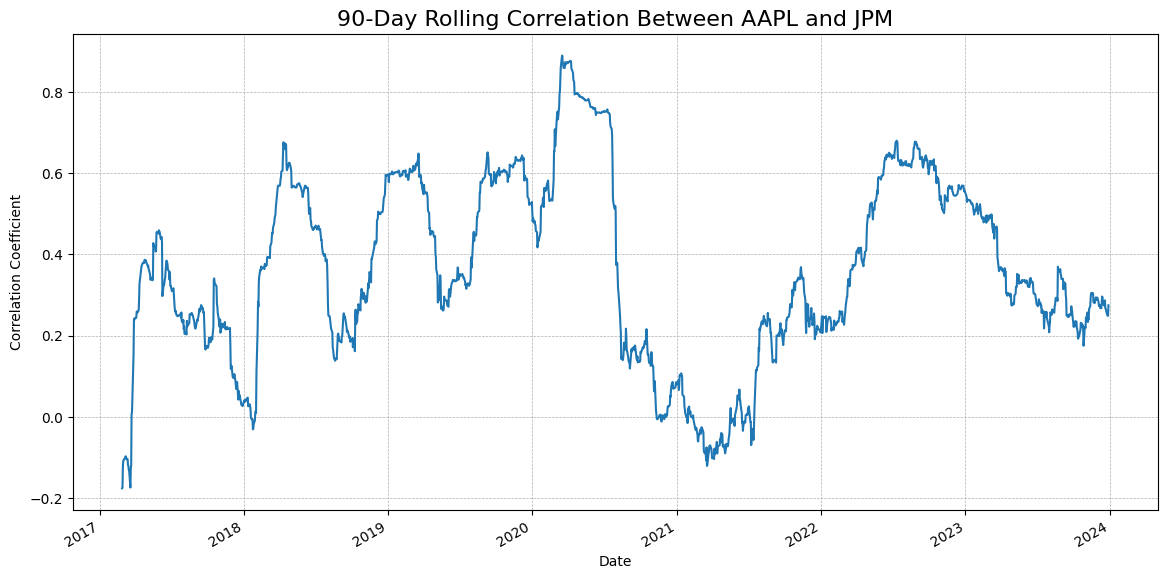


  > Generating correlation network graph for crisis period...
  > Correlation network graph saved as 'correlation_network.png'


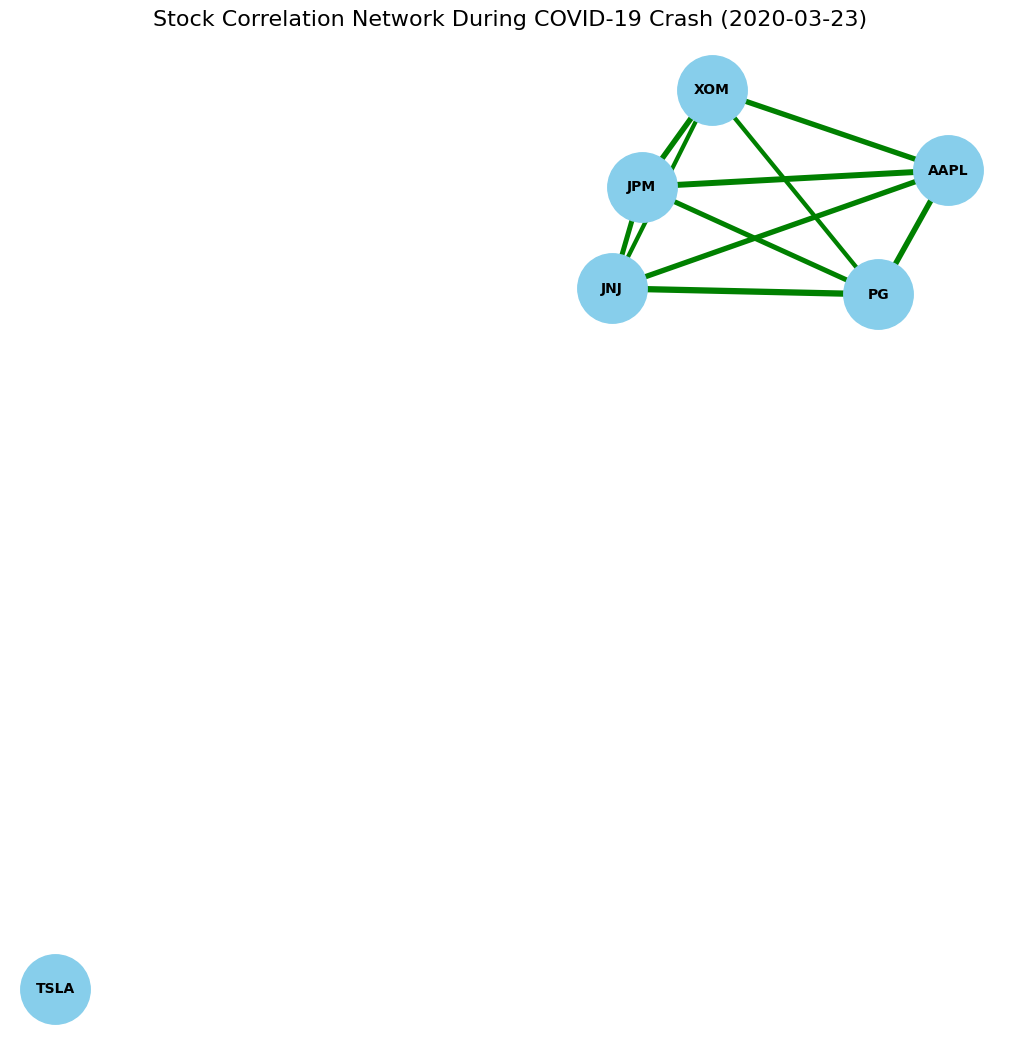

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings

warnings.filterwarnings('ignore')

def run_correlation_and_network_analysis(file_path, tickers_list, crisis_date_str='2020-03-23'):
    """
    Performs a dynamic correlation analysis and creates a network graph
    to visualize inter-stock relationships during a market crisis.
    """
    print("--- Running Dynamic Correlation & Network Analysis ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare Returns Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    price_pivot = df_full.pivot(index='Date', columns='Ticker', values='Close')
    returns_df = price_pivot[tickers_list].pct_change().dropna()

    # --- Part 1: Dynamic Correlation Plot ---
    print("  > Generating dynamic correlation plot...")

    # Calculate the 90-day rolling correlation between the first two tickers
    ticker1, ticker2 = tickers_list[0], tickers_list[1]
    rolling_corr = returns_df[ticker1].rolling(window=90).corr(returns_df[ticker2])

    plt.figure(figsize=(14, 7))
    rolling_corr.plot()
    plt.title(f'90-Day Rolling Correlation Between {ticker1} and {ticker2}', fontsize=16)
    plt.ylabel('Correlation Coefficient')
    plt.xlabel('Date')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig('dynamic_correlation.png')
    print("  > Dynamic correlation chart saved as 'dynamic_correlation.png'")
    plt.show()

    # --- Part 2: Correlation Network Graph for a Crisis Period ---
    print("\n  > Generating correlation network graph for crisis period...")

    # Find the index location for the crisis date
    crisis_date = pd.to_datetime(crisis_date_str).tz_localize('UTC')
    crisis_idx = returns_df.index.get_indexer([crisis_date], method='nearest')[0]

    # Calculate the correlation matrix for the 90 days leading up to the crisis
    crisis_window = returns_df.iloc[crisis_idx - 90 : crisis_idx]
    corr_matrix = crisis_window.corr()

    # Create the graph
    G = nx.Graph()

    # Add nodes (the stocks)
    for ticker in corr_matrix.columns:
        G.add_node(ticker)

    # Add edges (the correlations)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            ticker1 = corr_matrix.columns[i]
            ticker2 = corr_matrix.columns[j]
            correlation = corr_matrix.iloc[i, j]

            # Only draw a line if the correlation is strong
            if abs(correlation) > 0.6:
                G.add_edge(ticker1, ticker2, weight=abs(correlation), color='green' if correlation > 0 else 'red')

    # --- Visualize the Network Graph ---
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.7, iterations=50) # Position nodes using a spring layout

    edges = G.edges()
    colors = [G[u][v]['color'] for u, v in edges]
    weights = [G[u][v]['weight'] * 5 for u, v in edges] # Multiply for visual thickness

    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2500,
            edge_color=colors, width=weights, font_size=10, font_weight='bold')

    plt.title(f'Stock Correlation Network During COVID-19 Crash ({crisis_date.date()})', fontsize=16)
    plt.savefig('correlation_network.png')
    print("  > Correlation network graph saved as 'correlation_network.png'")
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'

# A diverse list of tickers from different sectors
tickers_for_analysis = ['AAPL', 'JPM', 'XOM', 'JNJ', 'TSLA', 'PG']

run_correlation_and_network_analysis(your_daily_file, tickers_for_analysis)

# Monthly Seasonality Analysis

--- Running Monthly Seasonality Analysis for NVDA ---

--- Statistical Summary of Monthly Returns ---
            mean    std  count
Month                         
January     7.70  17.30      7
February    5.33   9.10      7
March       6.57   9.84      7
April      -2.16  14.68      7
May        13.20  21.96      7
June        5.51  15.03      7
July        8.29   7.51      7
August      6.85  13.66      7
September  -4.02   9.24      7
October     3.88  17.18      7
November   10.90  17.69      8
December   -2.23  11.70      8

Seasonality analysis chart saved as 'seasonality_analysis_NVDA.png'


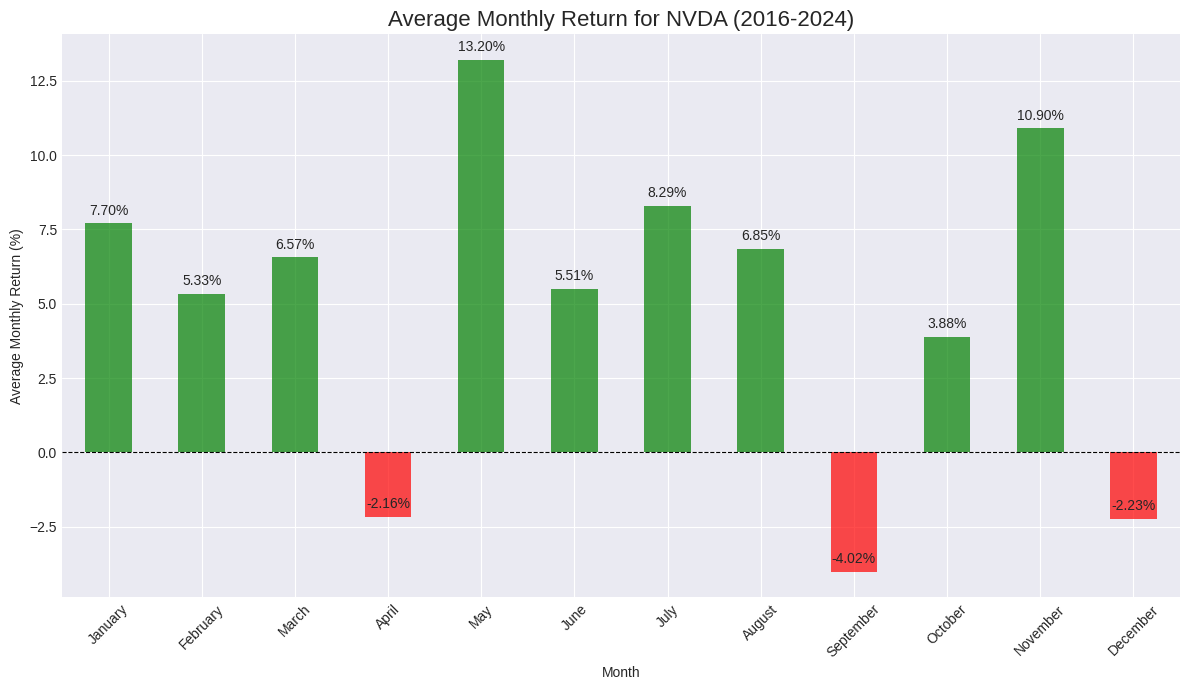

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def analyze_monthly_seasonality(file_path, ticker_symbol):
    """
    Analyzes the historical monthly seasonality of a stock's returns.
    """
    print(f"--- Running Monthly Seasonality Analysis for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    df_full.dropna(subset=['Date'], inplace=True)

    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    if ticker_df.empty:
        print(f"No data found for {ticker_symbol}.")
        return

    ticker_df.set_index('Date', inplace=True)

    # --- Step 2: Calculate Monthly Returns ---
    # Resample the daily data to get the last price of each month
    monthly_prices = ticker_df['Close'].resample('M').last()
    monthly_returns = monthly_prices.pct_change().dropna() * 100 # Convert to percentage

    # --- Step 3: Group by Month and Calculate Statistics ---
    # We add the month name as a column to group by
    monthly_returns.index = monthly_returns.index.tz_localize(None) # Remove timezone for grouping
    monthly_returns_df = pd.DataFrame(monthly_returns)
    monthly_returns_df['Month'] = monthly_returns_df.index.month_name()

    # Calculate the average return and standard deviation for each month
    seasonality_stats = monthly_returns_df.groupby('Month')['Close'].agg(['mean', 'std', 'count'])

    # Order the months correctly for plotting
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    seasonality_stats = seasonality_stats.reindex(month_order)

    print("\n--- Statistical Summary of Monthly Returns ---")
    print(seasonality_stats.round(2))

    # --- Step 4: Visualize the Seasonality ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # Create bars, coloring positive green and negative red
    colors = ['green' if x > 0 else 'red' for x in seasonality_stats['mean']]
    seasonality_stats['mean'].plot(kind='bar', ax=ax, color=colors, alpha=0.7)

    # Add a zero line
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)

    ax.set_title(f'Average Monthly Return for {ticker_symbol} (2016-2024)', fontsize=16)
    ax.set_ylabel('Average Monthly Return (%)')
    ax.set_xlabel('Month')
    ax.tick_params(axis='x', rotation=45)

    # Add value labels on top of the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    plt.tight_layout()
    plt.savefig(f'seasonality_analysis_{ticker_symbol}.png')
    print(f"\nSeasonality analysis chart saved as 'seasonality_analysis_{ticker_symbol}.png'")
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
# You can change 'AAPL' to any other ticker in your dataset
analyze_monthly_seasonality(your_daily_file, 'NVDA')

--- Generating Deep-Dive Case Study Visuals for V ---
  > Generating Dynamic Risk Profile chart...


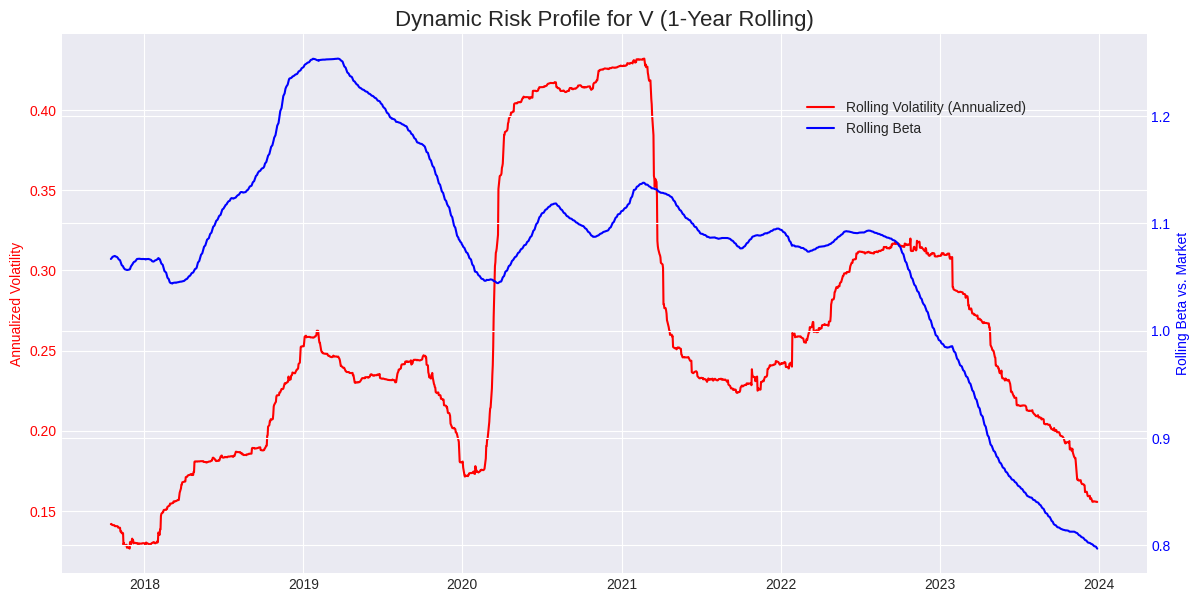

  > Generating Underwater Equity Curve chart...


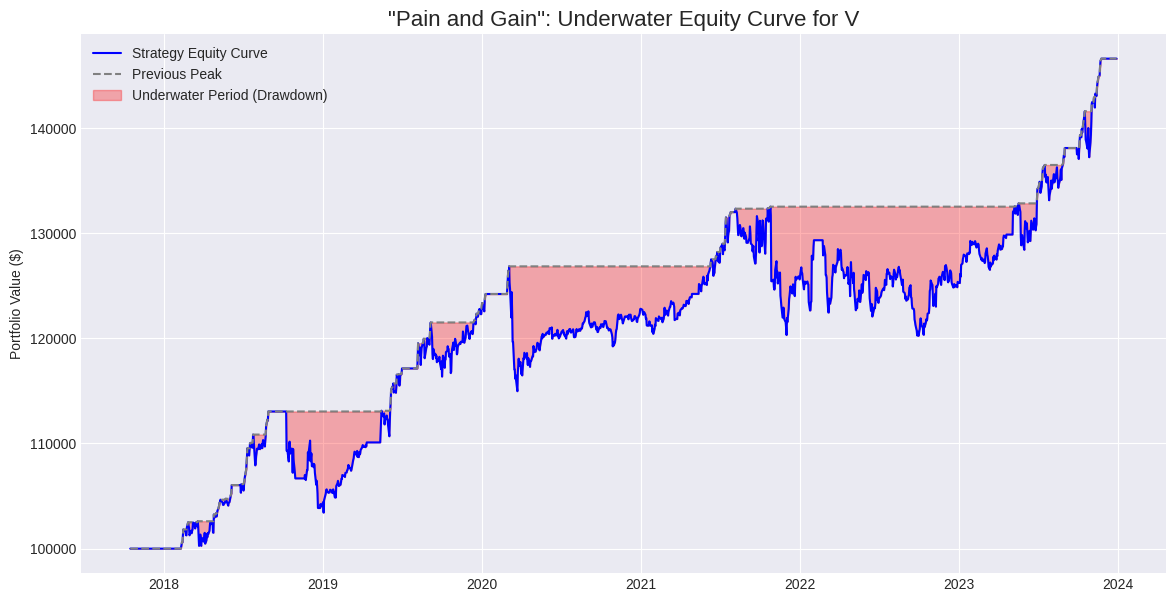

  > Generating Factor Fingerprint chart...


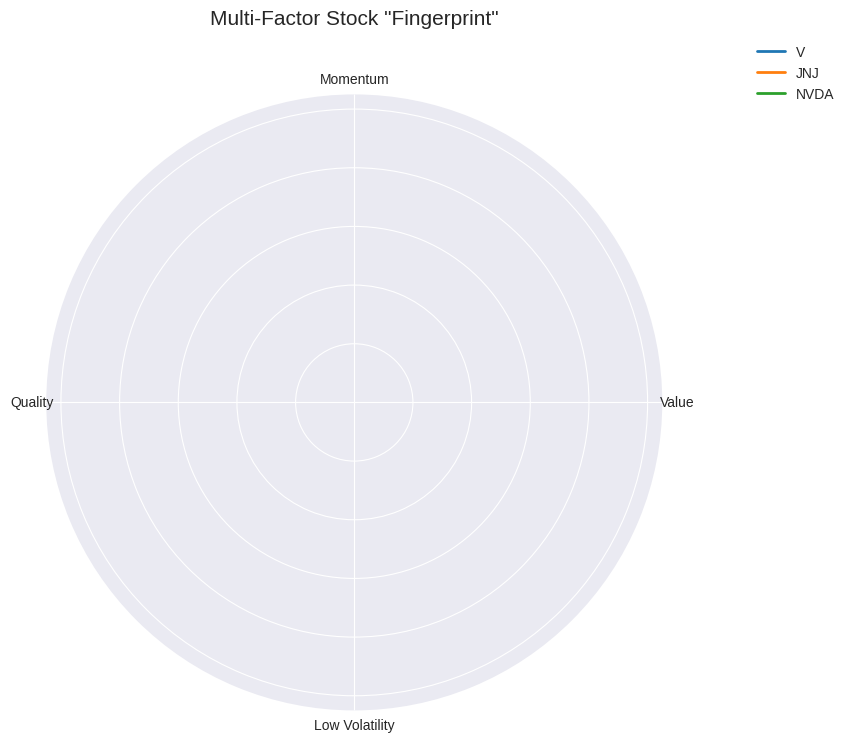

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def generate_case_study_visuals(file_path, primary_ticker, peer_tickers):
    """
    Generates a series of advanced visualizations for a deep-dive case study
    on a specific stock (e.g., Boeing).
    """
    print(f"--- Generating Deep-Dive Case Study Visuals for {primary_ticker} ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df.dropna(subset=['Date'], inplace=True)

    # --- Visualization 1: The Dynamic Risk Profile ---
    print("  > Generating Dynamic Risk Profile chart...")
    ticker_df = df[df['Ticker'] == primary_ticker].copy()
    ticker_df.set_index('Date', inplace=True)

    ticker_df['Rolling_Volatility'] = ticker_df['Return'].rolling(window=252).std() * np.sqrt(252)
    ticker_df['Rolling_Beta'] = ticker_df['Beta'].rolling(window=252).mean()

    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax1.set_title(f'Dynamic Risk Profile for {primary_ticker} (1-Year Rolling)', fontsize=16)
    ax1.plot(ticker_df.index, ticker_df['Rolling_Volatility'], color='red', label='Rolling Volatility (Annualized)')
    ax1.set_ylabel('Annualized Volatility', color='red'); ax1.tick_params(axis='y', labelcolor='red')
    ax2 = ax1.twinx()
    ax2.plot(ticker_df.index, ticker_df['Rolling_Beta'], color='blue', label='Rolling Beta')
    ax2.set_ylabel('Rolling Beta vs. Market', color='blue'); ax2.tick_params(axis='y', labelcolor='blue')
    fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.9), bbox_transform=ax1.transAxes)
    plt.savefig(f'risk_profile_{primary_ticker}.png'); plt.show()

    # --- Visualization 2: The "Pain and Gain" Underwater Chart ---
    print("  > Generating Underwater Equity Curve chart...")
    portfolio_df = run_backtest_for_case_study(ticker_df.reset_index())
    if portfolio_df is not None:
        portfolio_df['Rolling_Max'] = portfolio_df['Value'].cummax()

        plt.figure(figsize=(14, 7))
        plt.plot(portfolio_df['Date'], portfolio_df['Value'], label='Strategy Equity Curve', color='blue')
        plt.plot(portfolio_df['Date'], portfolio_df['Rolling_Max'], label='Previous Peak', color='grey', linestyle='--')
        plt.fill_between(portfolio_df['Date'], portfolio_df['Value'], portfolio_df['Rolling_Max'],
                         color='red', alpha=0.3, label='Underwater Period (Drawdown)')
        plt.title(f'"Pain and Gain": Underwater Equity Curve for {primary_ticker}', fontsize=16)
        plt.ylabel('Portfolio Value ($)'); plt.legend(); plt.grid(True)
        plt.savefig(f'underwater_curve_{primary_ticker}.png'); plt.show()

    # --- Visualization 3: The Factor "Fingerprint" Spider Chart ---
    print("  > Generating Factor Fingerprint chart...")
    latest_data = df.loc[df.groupby('Ticker')['Date'].idxmax()].copy()
    latest_data = latest_data[(latest_data['PE_Ratio'] > 0) & (latest_data['EPS_TTM'] > 0)].dropna()

    factors = {
        'Value': latest_data['PE_Ratio'].rank(ascending=True, pct=True),
        'Momentum': latest_data['RSI_14'].rank(ascending=False, pct=True),
        'Quality': latest_data['EPS_TTM'].rank(ascending=False, pct=True),
        'Low Volatility': latest_data['Volatility_20'].rank(ascending=True, pct=True)
    }
    factor_df = pd.DataFrame(factors, index=latest_data['Ticker']) * 100

    plot_df = factor_df.loc[[primary_ticker] + peer_tickers]
    labels = plot_df.columns; num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist(); angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for index, row in plot_df.iterrows():
        values = row.values.flatten().tolist(); values += values[:1]
        ax.plot(angles, values, label=index, linewidth=2)
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([]); ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
    ax.set_title('Multi-Factor Stock "Fingerprint"', size=15, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.savefig('factor_fingerprint.png'); plt.show()

def run_backtest_for_case_study(ticker_df, initial_capital=100000.0):
    # Simplified backtest engine for visualization purposes
    ticker_df.dropna(inplace=True)
    cash, portfolio_value, holdings, in_position = initial_capital, initial_capital, 0, False
    portfolio_history = []
    if ticker_df.empty or 'ATR_14' not in ticker_df.columns: return None
    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close'] if in_position else cash
        portfolio_history.append({'Date': row['Date'], 'Value': portfolio_value})
        if in_position and (row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price):
            cash += holdings * row['Close']; holdings, in_position = 0, False
        elif not in_position and (row['RSI_14'] < 45) and (row['Close'] > row['Open']):
            stop_loss_price = row['Close'] - (2 * row['ATR_14']); risk_per_share = row['Close'] - stop_loss_price
            if risk_per_share > 0:
                shares = (portfolio_value * 0.02) / risk_per_share
                if cash >= shares * row['Close']:
                    holdings, cash, in_position = shares, cash - (shares * row['Close']), True
                    entry_price = row['Close']; profit_target_price = entry_price + (3 * risk_per_share)
    return pd.DataFrame(portfolio_history)

# --- Run the Case Study Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
# Define our primary stock and its peers for comparison
case_study_ticker = 'V'
comparison_tickers = ['JNJ', 'NVDA']
generate_case_study_visuals(your_daily_file, case_study_ticker, comparison_tickers)

#Modeling and Forecasting Volatility with GARCH
A core concept in financial time series, often discussed in research papers, is Volatility Clustering. This is the observation that "volatility begets volatility." In simple terms, periods of high price swings are often followed by more high price swings, and calm periods are followed by more calm periods.

The professional tool used to model this behavior is the GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model.

The Methodology:

Analyze Historical Returns: We will take the daily Return data for a single stock from your dataset.

Fit a GARCH Model: We will "train" a GARCH(1,1) model on this historical data. The model learns how today's volatility is influenced by both yesterday's volatility and the magnitude of yesterday's price shock.

Forecast Future Volatility: We will use the trained model to generate a multi-step forecast of the stock's expected daily volatility for the next 30 trading days.

Visualize the Forecast: We will plot the stock's historical volatility and then append our model's forecast to the end, creating a powerful visualization of expected future risk.

This is a true time-series analysis that uses the past behavior of the stock to make a statistical forecast about its future.

In [28]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 2.5 MB/s eta 0:00:00


--- Running GARCH Volatility Forecast for TSLA ---
  > Fitting GARCH(1,1) model to historical returns...
  > Forecasting volatility for the next 30 days...

Volatility forecast chart saved as 'garch_forecast_TSLA.png'


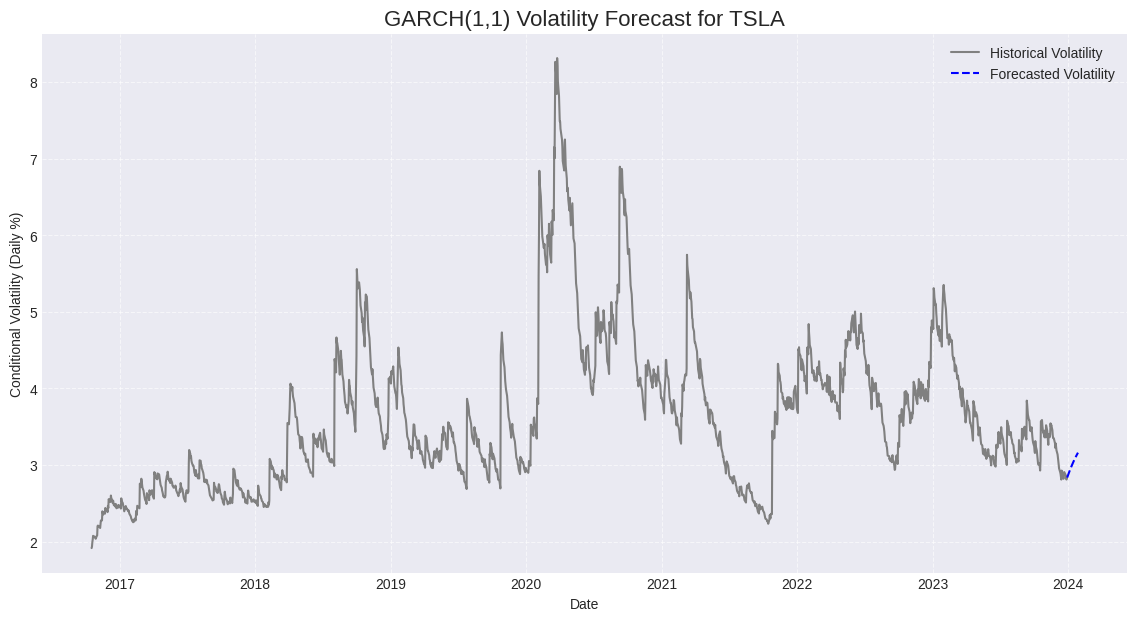

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import warnings

warnings.filterwarnings('ignore')

# Note: This script requires the 'arch' library.
# You may need to install it: pip install arch

def run_garch_volatility_forecast(file_path, ticker_symbol, forecast_horizon=30):
    """
    Fits a GARCH(1,1) model to a stock's historical returns and forecasts
    its future volatility.
    """
    print(f"--- Running GARCH Volatility Forecast for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Returns Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    ticker_df.set_index('Date', inplace=True)

    if ticker_df.empty or 'Return' not in ticker_df.columns:
        print(f"No valid return data for {ticker_symbol}.")
        return

    # GARCH models work best with returns multiplied by 100
    returns = ticker_df['Return'].dropna() * 100

    # --- Step 2: Fit the GARCH(1,1) Model ---
    # p=1 means we use 1 past variance, q=1 means we use 1 past squared shock
    print("  > Fitting GARCH(1,1) model to historical returns...")
    model = arch_model(returns, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off') # 'off' suppresses convergence output

    # print(model_fit.summary()) # Uncomment to see detailed model stats

    # --- Step 3: Forecast Future Volatility ---
    print(f"  > Forecasting volatility for the next {forecast_horizon} days...")
    forecast = model_fit.forecast(horizon=forecast_horizon, reindex=False)

    # The forecast object gives us variance, so we take the square root for volatility (std dev)
    forecasted_volatility = np.sqrt(forecast.variance.values[-1, :])

    # --- Step 4: Visualize the Results ---
    # Get the historical conditional volatility from the model
    historical_volatility = model_fit.conditional_volatility

    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(14, 7))

    # Plot historical volatility
    plt.plot(historical_volatility.index, historical_volatility, label='Historical Volatility', color='grey')

    # Create a future date index for the forecast
    last_date = historical_volatility.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

    # Plot the forecast
    plt.plot(future_dates, forecasted_volatility, label='Forecasted Volatility', color='blue', linestyle='--')

    plt.title(f'GARCH(1,1) Volatility Forecast for {ticker_symbol}', fontsize=16)
    plt.ylabel('Conditional Volatility (Daily %)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.6)

    output_filename = f'garch_forecast_{ticker_symbol}.png'
    plt.savefig(output_filename)
    print(f"\nVolatility forecast chart saved as '{output_filename}'")
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
# Let's use a stock known for periods of high and low volatility
run_garch_volatility_forecast(your_daily_file, 'TSLA')

--- Running GARCH-based VaR Analysis for TSLA ---
  > Fitting GARCH(1,1) model...
  > Calculating daily Value-at-Risk (VaR)...

VaR analysis chart saved as 'garch_var_analysis_TSLA.png'


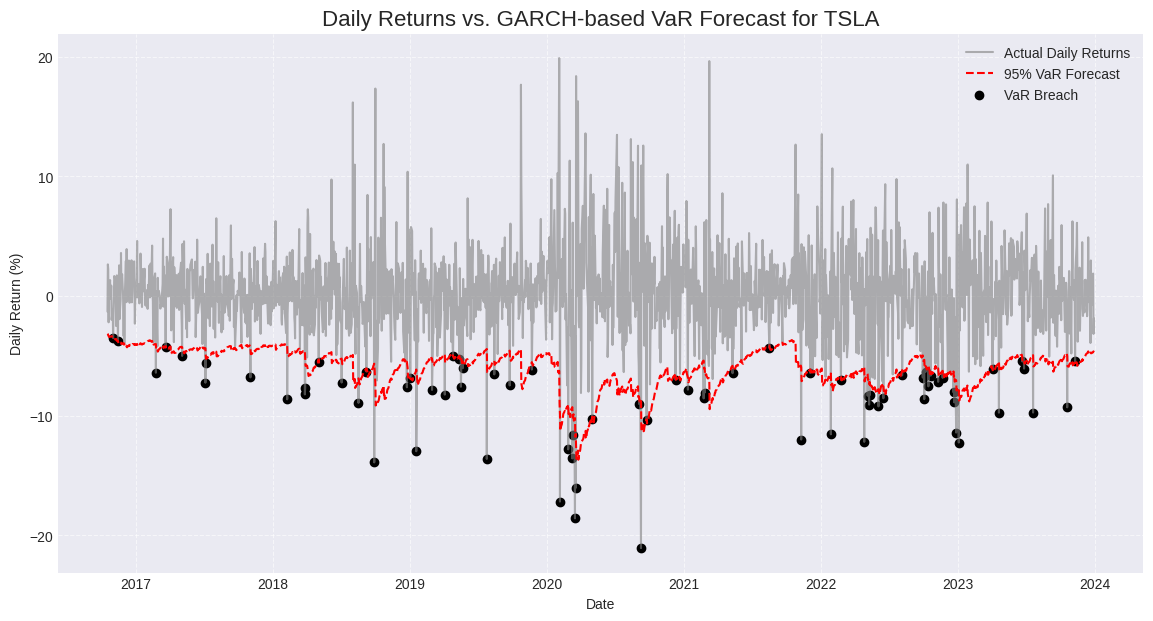


--- VaR Model Validation ---
Confidence Level: 95%
Expected Breach Percentage: 5.00%
Actual Breach Percentage: 4.08%
  > Verdict: The model appears to be well-calibrated.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import norm
import warnings

warnings.filterwarnings('ignore')

# Note: This script requires the 'arch' library.
# You may need to install it: pip install arch

def run_garch_var_analysis(file_path, ticker_symbol, confidence_level=0.95):
    """
    Fits a GARCH(1,1) model and calculates the daily Value-at-Risk (VaR).
    """
    print(f"--- Running GARCH-based VaR Analysis for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Returns Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    ticker_df.set_index('Date', inplace=True)

    if ticker_df.empty or 'Return' not in ticker_df.columns:
        print(f"No valid return data for {ticker_symbol}.")
        return

    returns = ticker_df['Return'].dropna() * 100

    # --- Step 2: Fit the GARCH(1,1) Model ---
    print("  > Fitting GARCH(1,1) model...")
    model = arch_model(returns, vol='Garch', p=1, q=1, dist='normal')
    model_fit = model.fit(disp='off')

    # --- Step 3: Calculate the Daily Value-at-Risk (VaR) ---
    print("  > Calculating daily Value-at-Risk (VaR)...")
    # Get the conditional volatility (our daily risk forecast) from the model
    conditional_volatility = model_fit.conditional_volatility

    # Calculate VaR using the inverse of the normal distribution (quantile function)
    # For a 95% confidence level, we look at the 5th percentile (1.0 - 0.95)
    quantile = norm.ppf(1 - confidence_level)
    var_95 = conditional_volatility * quantile

    # --- Step 4: Visualize the Results and VaR Breaches ---
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(14, 7))

    # Plot the actual returns
    plt.plot(returns.index, returns, label='Actual Daily Returns', color='grey', alpha=0.6)

    # Plot the VaR "floor"
    plt.plot(var_95.index, var_95, label=f'{confidence_level:.0%} VaR Forecast', color='red', linestyle='--')

    # Highlight the breaches (when actual return was worse than the VaR forecast)
    breaches = returns[returns < var_95]
    plt.scatter(breaches.index, breaches.values, color='black', marker='o', label='VaR Breach')

    plt.title(f'Daily Returns vs. GARCH-based VaR Forecast for {ticker_symbol}', fontsize=16)
    plt.ylabel('Daily Return (%)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.6)

    output_filename = f'garch_var_analysis_{ticker_symbol}.png'
    plt.savefig(output_filename)
    print(f"\nVaR analysis chart saved as '{output_filename}'")
    plt.show()

    # --- Step 5: Statistical Summary ---
    breach_percentage = len(breaches) / len(var_95) * 100
    expected_breaches = (1 - confidence_level) * 100

    print("\n--- VaR Model Validation ---")
    print(f"Confidence Level: {confidence_level:.0%}")
    print(f"Expected Breach Percentage: {expected_breaches:.2f}%")
    print(f"Actual Breach Percentage: {breach_percentage:.2f}%")
    if abs(breach_percentage - expected_breaches) < 1:
        print("  > Verdict: The model appears to be well-calibrated.")
    else:
        print("  > Verdict: The model may be underestimating or overestimating risk.")


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_garch_var_analysis(your_daily_file, 'TSLA')

--- Running GARCH-based VaR Analysis for BA ---
  > Fitting GARCH(1,1) model...
  > Calculating daily Value-at-Risk (VaR)...

VaR analysis chart saved as 'garch_var_analysis_BA.png'


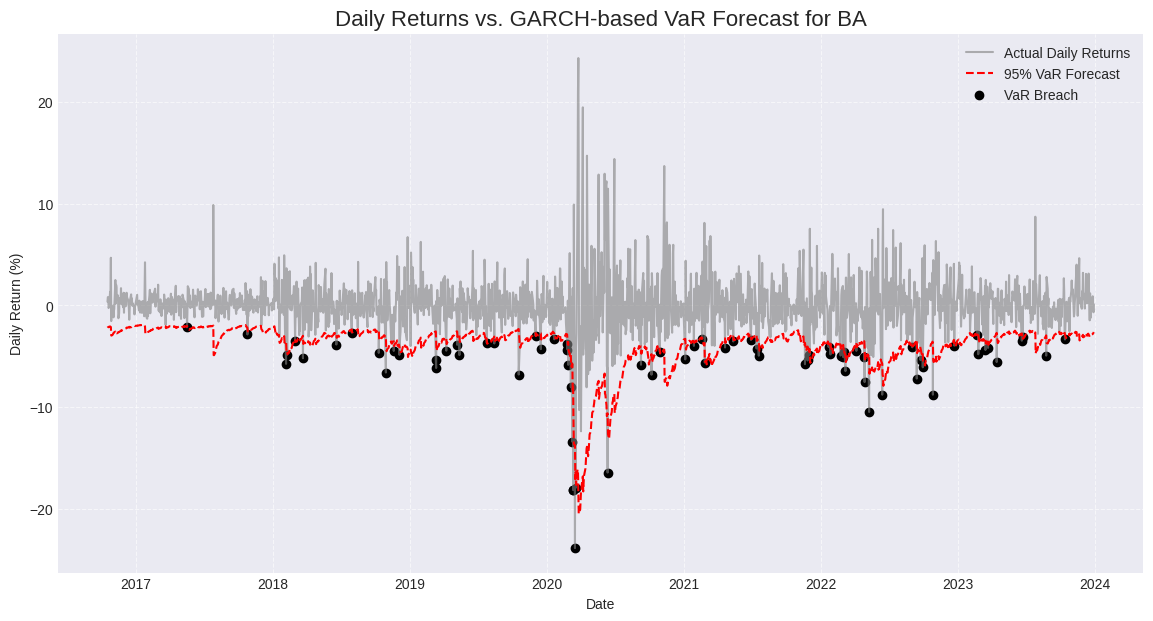


--- VaR Model Validation ---
Confidence Level: 95%
Expected Breach Percentage: 5.00%
Actual Breach Percentage: 4.08%
  > Verdict: The model appears to be well-calibrated.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import norm
import warnings

warnings.filterwarnings('ignore')

# Note: This script requires the 'arch' library.
# You may need to install it: pip install arch

def run_garch_var_analysis(file_path, ticker_symbol, confidence_level=0.95):
    """
    Fits a GARCH(1,1) model and calculates the daily Value-at-Risk (VaR).
    """
    print(f"--- Running GARCH-based VaR Analysis for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Returns Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    ticker_df.set_index('Date', inplace=True)

    if ticker_df.empty or 'Return' not in ticker_df.columns:
        print(f"No valid return data for {ticker_symbol}.")
        return

    returns = ticker_df['Return'].dropna() * 100

    # --- Step 2: Fit the GARCH(1,1) Model ---
    print("  > Fitting GARCH(1,1) model...")
    model = arch_model(returns, vol='Garch', p=1, q=1, dist='normal')
    model_fit = model.fit(disp='off')

    # --- Step 3: Calculate the Daily Value-at-Risk (VaR) ---
    print("  > Calculating daily Value-at-Risk (VaR)...")
    # Get the conditional volatility (our daily risk forecast) from the model
    conditional_volatility = model_fit.conditional_volatility

    # Calculate VaR using the inverse of the normal distribution (quantile function)
    # For a 95% confidence level, we look at the 5th percentile (1.0 - 0.95)
    quantile = norm.ppf(1 - confidence_level)
    var_95 = conditional_volatility * quantile

    # --- Step 4: Visualize the Results and VaR Breaches ---
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(14, 7))

    # Plot the actual returns
    plt.plot(returns.index, returns, label='Actual Daily Returns', color='grey', alpha=0.6)

    # Plot the VaR "floor"
    plt.plot(var_95.index, var_95, label=f'{confidence_level:.0%} VaR Forecast', color='red', linestyle='--')

    # Highlight the breaches (when actual return was worse than the VaR forecast)
    breaches = returns[returns < var_95]
    plt.scatter(breaches.index, breaches.values, color='black', marker='o', label='VaR Breach')

    plt.title(f'Daily Returns vs. GARCH-based VaR Forecast for {ticker_symbol}', fontsize=16)
    plt.ylabel('Daily Return (%)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.6)

    output_filename = f'garch_var_analysis_{ticker_symbol}.png'
    plt.savefig(output_filename)
    print(f"\nVaR analysis chart saved as '{output_filename}'")
    plt.show()

    # --- Step 5: Statistical Summary ---
    breach_percentage = len(breaches) / len(var_95) * 100
    expected_breaches = (1 - confidence_level) * 100

    print("\n--- VaR Model Validation ---")
    print(f"Confidence Level: {confidence_level:.0%}")
    print(f"Expected Breach Percentage: {expected_breaches:.2f}%")
    print(f"Actual Breach Percentage: {breach_percentage:.2f}%")
    if abs(breach_percentage - expected_breaches) < 1:
        print("  > Verdict: The model appears to be well-calibrated.")
    else:
        print("  > Verdict: The model may be underestimating or overestimating risk.")


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_garch_var_analysis(your_daily_file, 'BA')

--- Running Rolling VaR Forecast for TSLA ---
  > Completed 100/813 forecasts...
  > Completed 200/813 forecasts...
  > Completed 300/813 forecasts...
  > Completed 400/813 forecasts...
  > Completed 500/813 forecasts...
  > Completed 600/813 forecasts...
  > Completed 700/813 forecasts...
  > Completed 800/813 forecasts...
  > Rolling forecast complete.


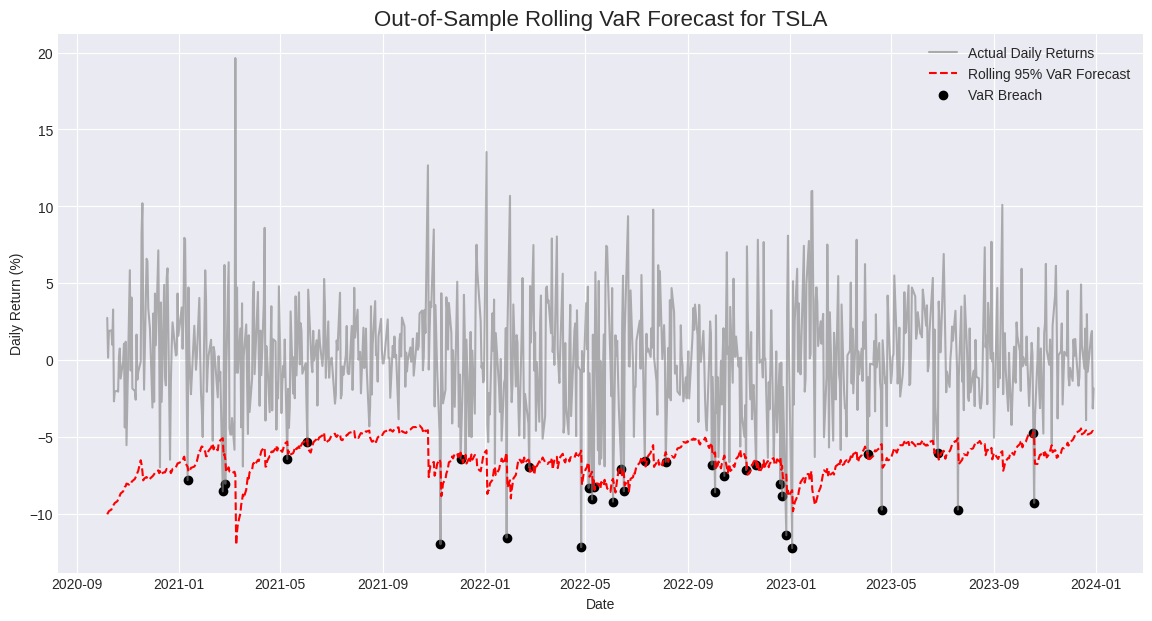


           Rolling VaR Model Backtest & Validation
Total Forecasts (Out-of-Sample): 813
Expected Breaches (5.0%): 40.7
Actual Breaches Observed: 33
Actual Breach Percentage: 4.06%
------------------------------------------------------------
Kupiec's Unconditional Coverage Test:
  > Likelihood Ratio Statistic: 1.6151
  > P-value: 0.2038
  > Verdict (at 95% confidence): FAIL to reject the null hypothesis. The model is considered accurate.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import chi2
import warnings

warnings.filterwarnings('ignore')

def run_rolling_var_forecast(file_path, ticker_symbol, window_size=1000, confidence_level=0.95):
    """
    Performs a rolling window GARCH forecast to generate out-of-sample VaR
    predictions and validates the model using Kupiec's Test.
    """
    print(f"--- Running Rolling VaR Forecast for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Returns Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    ticker_df.set_index('Date', inplace=True)
    returns = ticker_df['Return'].dropna() * 100

    if len(returns) <= window_size:
        print("Error: Not enough data to perform a rolling forecast with the specified window size.")
        return

    # --- Step 2: The Rolling Forecast Loop ---
    forecasts = []
    # We start forecasting after the initial window period
    for i in range(len(returns) - window_size):
        # Define the current window of historical data
        current_window = returns.iloc[i : i + window_size]

        # Fit the GARCH model on the current window
        model = arch_model(current_window, vol='Garch', p=1, q=1)
        model_fit = model.fit(disp='off')

        # Forecast 1-step ahead variance
        forecast = model_fit.forecast(horizon=1, reindex=False)
        forecasted_variance = forecast.variance.values[-1, 0]

        forecasts.append(forecasted_variance)
        if (i + 1) % 100 == 0:
            print(f"  > Completed {i+1}/{len(returns) - window_size} forecasts...")

    print("  > Rolling forecast complete.")

    # --- Step 3: Calculate Out-of-Sample VaR and Identify Breaches ---
    # Align the forecasts with the actual returns they were predicting
    forecast_dates = returns.index[window_size:]
    forecasted_volatility = np.sqrt(pd.Series(forecasts, index=forecast_dates))

    quantile = stats.norm.ppf(1 - confidence_level)
    var_forecasts = forecasted_volatility * quantile

    actual_returns_for_forecasts = returns.iloc[window_size:]
    breaches = actual_returns_for_forecasts[actual_returns_for_forecasts < var_forecasts]

    # --- Step 4: Kupiec's Unconditional Coverage Test ---
    N = len(actual_returns_for_forecasts)
    T1 = len(breaches)
    p = 1 - confidence_level

    # Likelihood ratio test statistic
    LR_uc = -2 * np.log( ((1-p)**(N-T1) * p**T1) / ( (1-(T1/N))**(N-T1) * (T1/N)**T1 ) )
    # P-value from the chi-squared distribution with 1 degree of freedom
    p_value_kupiec = 1 - chi2.cdf(LR_uc, 1)

    # --- Step 5: Visualize and Report ---
    plt.figure(figsize=(14, 7))
    plt.plot(actual_returns_for_forecasts.index, actual_returns_for_forecasts, label='Actual Daily Returns', color='grey', alpha=0.6)
    plt.plot(var_forecasts.index, var_forecasts, label=f'Rolling {confidence_level:.0%} VaR Forecast', color='red', linestyle='--')
    plt.scatter(breaches.index, breaches.values, color='black', marker='o', label='VaR Breach')
    plt.title(f'Out-of-Sample Rolling VaR Forecast for {ticker_symbol}', fontsize=16)
    plt.ylabel('Daily Return (%)'); plt.xlabel('Date'); plt.legend()
    plt.savefig(f'rolling_var_forecast_{ticker_symbol}.png')
    plt.show()

    print("\n" + "="*60)
    print("           Rolling VaR Model Backtest & Validation")
    print("="*60)
    print(f"Total Forecasts (Out-of-Sample): {N}")
    print(f"Expected Breaches ({p*100:.1f}%): {N*p:.1f}")
    print(f"Actual Breaches Observed: {T1}")
    print(f"Actual Breach Percentage: {T1/N*100:.2f}%")
    print("-"*60)
    print("Kupiec's Unconditional Coverage Test:")
    print(f"  > Likelihood Ratio Statistic: {LR_uc:.4f}")
    print(f"  > P-value: {p_value_kupiec:.4f}")
    if p_value_kupiec < 0.05:
        print("  > Verdict (at 95% confidence): REJECT the null hypothesis. The model is inaccurate.")
    else:
        print("  > Verdict (at 95% confidence): FAIL to reject the null hypothesis. The model is considered accurate.")
    print("="*60)

# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_rolling_var_forecast(your_daily_file, 'TSLA')

--- Running Rolling VaR Forecast for BA ---
  > Completed 100/813 forecasts...
  > Completed 200/813 forecasts...
  > Completed 300/813 forecasts...
  > Completed 400/813 forecasts...
  > Completed 500/813 forecasts...
  > Completed 600/813 forecasts...
  > Completed 700/813 forecasts...
  > Completed 800/813 forecasts...
  > Rolling forecast complete.


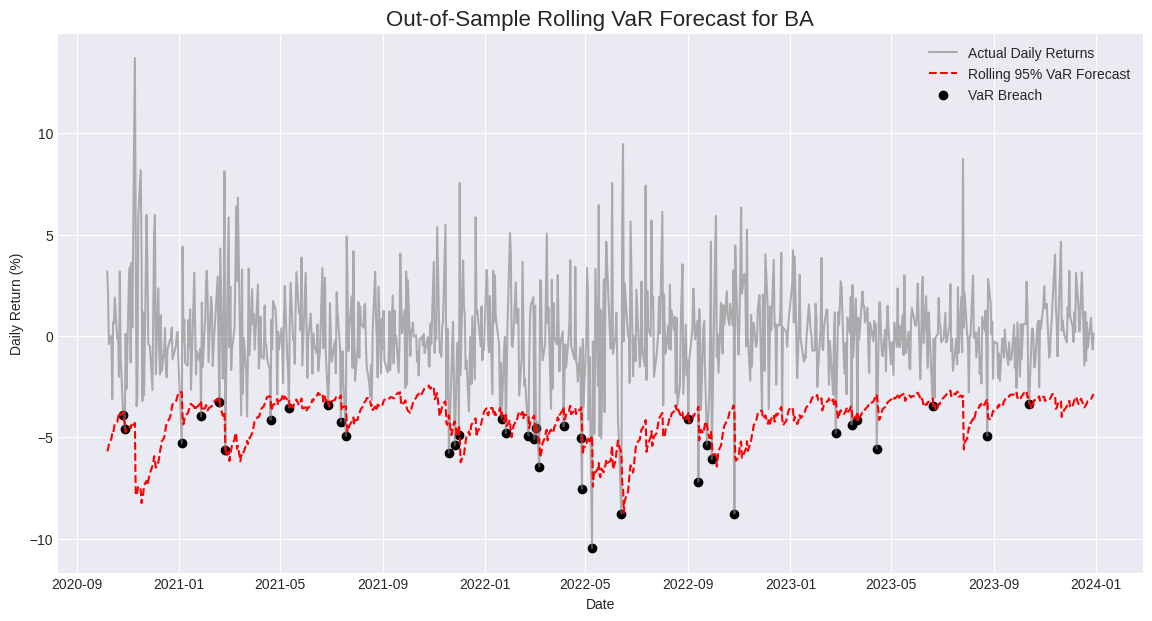


           Rolling VaR Model Backtest & Validation
Total Forecasts (Out-of-Sample): 813
Expected Breaches (5.0%): 40.7
Actual Breaches Observed: 37
Actual Breach Percentage: 4.55%
------------------------------------------------------------
Kupiec's Unconditional Coverage Test:
  > Likelihood Ratio Statistic: 0.3552
  > P-value: 0.5512
  > Verdict (at 95% confidence): FAIL to reject the null hypothesis. The model is considered accurate.


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import chi2
import warnings

warnings.filterwarnings('ignore')

def run_rolling_var_forecast(file_path, ticker_symbol, window_size=1000, confidence_level=0.95):
    """
    Performs a rolling window GARCH forecast to generate out-of-sample VaR
    predictions and validates the model using Kupiec's Test.
    """
    print(f"--- Running Rolling VaR Forecast for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Returns Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    ticker_df.set_index('Date', inplace=True)
    returns = ticker_df['Return'].dropna() * 100

    if len(returns) <= window_size:
        print("Error: Not enough data to perform a rolling forecast with the specified window size.")
        return

    # --- Step 2: The Rolling Forecast Loop ---
    forecasts = []
    # We start forecasting after the initial window period
    for i in range(len(returns) - window_size):
        # Define the current window of historical data
        current_window = returns.iloc[i : i + window_size]

        # Fit the GARCH model on the current window
        model = arch_model(current_window, vol='Garch', p=1, q=1)
        model_fit = model.fit(disp='off')

        # Forecast 1-step ahead variance
        forecast = model_fit.forecast(horizon=1, reindex=False)
        forecasted_variance = forecast.variance.values[-1, 0]

        forecasts.append(forecasted_variance)
        if (i + 1) % 100 == 0:
            print(f"  > Completed {i+1}/{len(returns) - window_size} forecasts...")

    print("  > Rolling forecast complete.")

    # --- Step 3: Calculate Out-of-Sample VaR and Identify Breaches ---
    # Align the forecasts with the actual returns they were predicting
    forecast_dates = returns.index[window_size:]
    forecasted_volatility = np.sqrt(pd.Series(forecasts, index=forecast_dates))

    quantile = stats.norm.ppf(1 - confidence_level)
    var_forecasts = forecasted_volatility * quantile

    actual_returns_for_forecasts = returns.iloc[window_size:]
    breaches = actual_returns_for_forecasts[actual_returns_for_forecasts < var_forecasts]

    # --- Step 4: Kupiec's Unconditional Coverage Test ---
    N = len(actual_returns_for_forecasts)
    T1 = len(breaches)
    p = 1 - confidence_level

    # Likelihood ratio test statistic
    LR_uc = -2 * np.log( ((1-p)**(N-T1) * p**T1) / ( (1-(T1/N))**(N-T1) * (T1/N)**T1 ) )
    # P-value from the chi-squared distribution with 1 degree of freedom
    p_value_kupiec = 1 - chi2.cdf(LR_uc, 1)

    # --- Step 5: Visualize and Report ---
    plt.figure(figsize=(14, 7))
    plt.plot(actual_returns_for_forecasts.index, actual_returns_for_forecasts, label='Actual Daily Returns', color='grey', alpha=0.6)
    plt.plot(var_forecasts.index, var_forecasts, label=f'Rolling {confidence_level:.0%} VaR Forecast', color='red', linestyle='--')
    plt.scatter(breaches.index, breaches.values, color='black', marker='o', label='VaR Breach')
    plt.title(f'Out-of-Sample Rolling VaR Forecast for {ticker_symbol}', fontsize=16)
    plt.ylabel('Daily Return (%)'); plt.xlabel('Date'); plt.legend()
    plt.savefig(f'rolling_var_forecast_{ticker_symbol}.png')
    plt.show()

    print("\n" + "="*60)
    print("           Rolling VaR Model Backtest & Validation")
    print("="*60)
    print(f"Total Forecasts (Out-of-Sample): {N}")
    print(f"Expected Breaches ({p*100:.1f}%): {N*p:.1f}")
    print(f"Actual Breaches Observed: {T1}")
    print(f"Actual Breach Percentage: {T1/N*100:.2f}%")
    print("-"*60)
    print("Kupiec's Unconditional Coverage Test:")
    print(f"  > Likelihood Ratio Statistic: {LR_uc:.4f}")
    print(f"  > P-value: {p_value_kupiec:.4f}")
    if p_value_kupiec < 0.05:
        print("  > Verdict (at 95% confidence): REJECT the null hypothesis. The model is inaccurate.")
    else:
        print("  > Verdict (at 95% confidence): FAIL to reject the null hypothesis. The model is considered accurate.")
    print("="*60)

# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_rolling_var_forecast(your_daily_file, 'BA')

--- Running Rolling VaR Forecast for JPM ---
  > Completed 100/813 forecasts...
  > Completed 200/813 forecasts...
  > Completed 300/813 forecasts...
  > Completed 400/813 forecasts...
  > Completed 500/813 forecasts...
  > Completed 600/813 forecasts...
  > Completed 700/813 forecasts...
  > Completed 800/813 forecasts...
  > Rolling forecast complete.


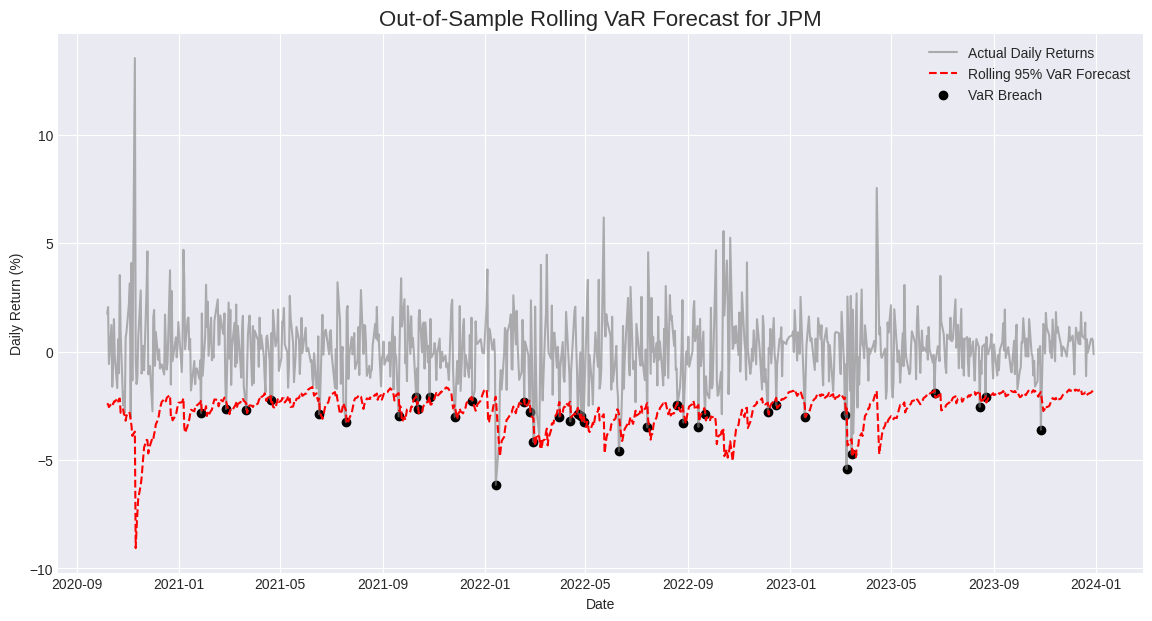


           Rolling VaR Model Backtest & Validation
Total Forecasts (Out-of-Sample): 813
Expected Breaches (5.0%): 40.7
Actual Breaches Observed: 37
Actual Breach Percentage: 4.55%
------------------------------------------------------------
Kupiec's Unconditional Coverage Test:
  > Likelihood Ratio Statistic: 0.3552
  > P-value: 0.5512
  > Verdict (at 95% confidence): FAIL to reject the null hypothesis. The model is considered accurate.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import chi2
import warnings

warnings.filterwarnings('ignore')

def run_rolling_var_forecast(file_path, ticker_symbol, window_size=1000, confidence_level=0.95):
    """
    Performs a rolling window GARCH forecast to generate out-of-sample VaR
    predictions and validates the model using Kupiec's Test.
    """
    print(f"--- Running Rolling VaR Forecast for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Returns Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    ticker_df.set_index('Date', inplace=True)
    returns = ticker_df['Return'].dropna() * 100

    if len(returns) <= window_size:
        print("Error: Not enough data to perform a rolling forecast with the specified window size.")
        return

    # --- Step 2: The Rolling Forecast Loop ---
    forecasts = []
    # We start forecasting after the initial window period
    for i in range(len(returns) - window_size):
        # Define the current window of historical data
        current_window = returns.iloc[i : i + window_size]

        # Fit the GARCH model on the current window
        model = arch_model(current_window, vol='Garch', p=1, q=1)
        model_fit = model.fit(disp='off')

        # Forecast 1-step ahead variance
        forecast = model_fit.forecast(horizon=1, reindex=False)
        forecasted_variance = forecast.variance.values[-1, 0]

        forecasts.append(forecasted_variance)
        if (i + 1) % 100 == 0:
            print(f"  > Completed {i+1}/{len(returns) - window_size} forecasts...")

    print("  > Rolling forecast complete.")

    # --- Step 3: Calculate Out-of-Sample VaR and Identify Breaches ---
    # Align the forecasts with the actual returns they were predicting
    forecast_dates = returns.index[window_size:]
    forecasted_volatility = np.sqrt(pd.Series(forecasts, index=forecast_dates))

    quantile = stats.norm.ppf(1 - confidence_level)
    var_forecasts = forecasted_volatility * quantile

    actual_returns_for_forecasts = returns.iloc[window_size:]
    breaches = actual_returns_for_forecasts[actual_returns_for_forecasts < var_forecasts]

    # --- Step 4: Kupiec's Unconditional Coverage Test ---
    N = len(actual_returns_for_forecasts)
    T1 = len(breaches)
    p = 1 - confidence_level

    # Likelihood ratio test statistic
    LR_uc = -2 * np.log( ((1-p)**(N-T1) * p**T1) / ( (1-(T1/N))**(N-T1) * (T1/N)**T1 ) )
    # P-value from the chi-squared distribution with 1 degree of freedom
    p_value_kupiec = 1 - chi2.cdf(LR_uc, 1)

    # --- Step 5: Visualize and Report ---
    plt.figure(figsize=(14, 7))
    plt.plot(actual_returns_for_forecasts.index, actual_returns_for_forecasts, label='Actual Daily Returns', color='grey', alpha=0.6)
    plt.plot(var_forecasts.index, var_forecasts, label=f'Rolling {confidence_level:.0%} VaR Forecast', color='red', linestyle='--')
    plt.scatter(breaches.index, breaches.values, color='black', marker='o', label='VaR Breach')
    plt.title(f'Out-of-Sample Rolling VaR Forecast for {ticker_symbol}', fontsize=16)
    plt.ylabel('Daily Return (%)'); plt.xlabel('Date'); plt.legend()
    plt.savefig(f'rolling_var_forecast_{ticker_symbol}.png')
    plt.show()

    print("\n" + "="*60)
    print("           Rolling VaR Model Backtest & Validation")
    print("="*60)
    print(f"Total Forecasts (Out-of-Sample): {N}")
    print(f"Expected Breaches ({p*100:.1f}%): {N*p:.1f}")
    print(f"Actual Breaches Observed: {T1}")
    print(f"Actual Breach Percentage: {T1/N*100:.2f}%")
    print("-"*60)
    print("Kupiec's Unconditional Coverage Test:")
    print(f"  > Likelihood Ratio Statistic: {LR_uc:.4f}")
    print(f"  > P-value: {p_value_kupiec:.4f}")
    if p_value_kupiec < 0.05:
        print("  > Verdict (at 95% confidence): REJECT the null hypothesis. The model is inaccurate.")
    else:
        print("  > Verdict (at 95% confidence): FAIL to reject the null hypothesis. The model is considered accurate.")
    print("="*60)

# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_rolling_var_forecast(your_daily_file, 'JPM')

In [35]:
df.columns

Index(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return',
       'MA_20', 'MA_50', 'MA_200', 'Volatility_20', 'RSI_14', 'MACD', 'ATR_14',
       'Beta', 'PE_Ratio', 'PB_Ratio', 'EPS_TTM', 'Dividend_Yield',
       'Market_Cap'],
      dtype='object')

--- Running Vector Autoregression (VAR) Analysis for TSLA ---
  > Prepared dataset with 1813 observations.
  > Fitting the VAR model...

--- Granger Causality Test Results ---
Does Volatility or RSI Granger-cause Returns?
Granger causality F-test. H_0: ['Volatility_20', 'RSI_14'] do not Granger-cause Return. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         1.685          1.832   0.078 (10, 5376)
------------------------------------------------

  > Generating Impulse Response Functions (IRF)...

Impulse Response Function chart saved as 'var_irf_analysis_TSLA.png'


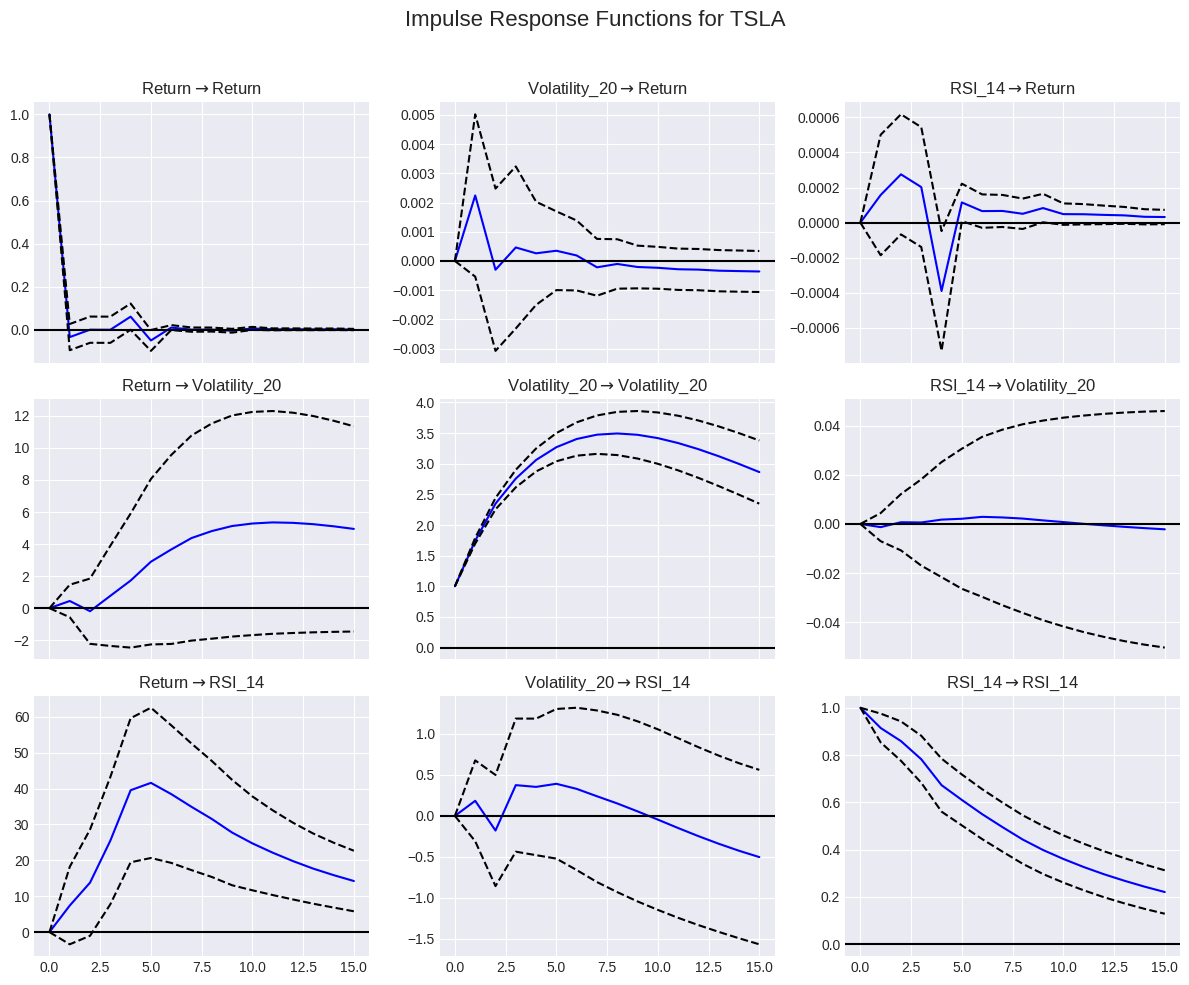

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import warnings

warnings.filterwarnings('ignore')

# Note: This script requires the 'statsmodels' library.
# You may need to install it: pip install statsmodels

def run_var_analysis(file_path, ticker_symbol):
    """
    Performs a Vector Autoregression (VAR) analysis to model the
    interdependencies between a stock's returns, volatility, and momentum.
    """
    print(f"--- Running Vector Autoregression (VAR) Analysis for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Time-Series Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)

    # Select the features for our model
    features = ['Return', 'Volatility_20', 'RSI_14']
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol][['Date'] + features].copy()
    ticker_df.set_index('Date', inplace=True)

    # VAR models require stationary data with no missing values
    ticker_df.dropna(inplace=True)

    if ticker_df.empty:
        print(f"Not enough data for {ticker_symbol} to run the analysis.")
        return

    print(f"  > Prepared dataset with {len(ticker_df)} observations.")

    # --- Step 2: Fit the VAR Model ---
    # A VAR model is fitted to the data. We let the model select the optimal
    # number of lags (past time periods) to consider.
    print("  > Fitting the VAR model...")
    model = VAR(ticker_df)
    # lag_order = model.select_order(maxlags=15)
    # print(lag_order.summary()) # Uncomment to see the optimal lag selection

    # For stability, we'll use a common lag order, e.g., 5
    results = model.fit(5)
    # print(results.summary()) # Uncomment to see the detailed regression results

    # --- Step 3: Granger Causality Test ---
    print("\n--- Granger Causality Test Results ---")
    # This tests if one variable is useful in forecasting another.
    # We test if the columns in 'caused' are Granger-caused by the columns in 'causality'.
    # A low p-value (< 0.05) means we can reject the null hypothesis that there is NO causality.
    print("Does Volatility or RSI Granger-cause Returns?")
    causality_test_returns = results.test_causality('Return', ['Volatility_20', 'RSI_14'], kind='f')
    print(causality_test_returns.summary())

    # --- Step 4: Generate and Visualize Impulse Response Functions (IRF) ---
    print("\n  > Generating Impulse Response Functions (IRF)...")
    # An IRF traces the effect of a one-standard-deviation shock to one variable on the others.
    irf = results.irf(periods=15) # Forecast the response over 15 days

    # Create the plot
    irf.plot(orth=False, figsize=(12, 10))
    plt.suptitle(f'Impulse Response Functions for {ticker_symbol}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    output_filename = f'var_irf_analysis_{ticker_symbol}.png'
    plt.savefig(output_filename)
    print(f"\nImpulse Response Function chart saved as '{output_filename}'")
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
# Let's use a stock with interesting dynamics
run_var_analysis(your_daily_file, 'TSLA')

--- Running Vector Autoregression (VAR) Analysis for GOOG ---
  > Prepared dataset with 1813 observations.
  > Fitting the VAR model...

--- Granger Causality Test Results ---
Does Volatility or RSI Granger-cause Returns?
Granger causality F-test. H_0: ['Volatility_20', 'RSI_14'] do not Granger-cause Return. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         2.749          1.832   0.002 (10, 5376)
------------------------------------------------

  > Generating Impulse Response Functions (IRF)...

Impulse Response Function chart saved as 'var_irf_analysis_GOOG.png'


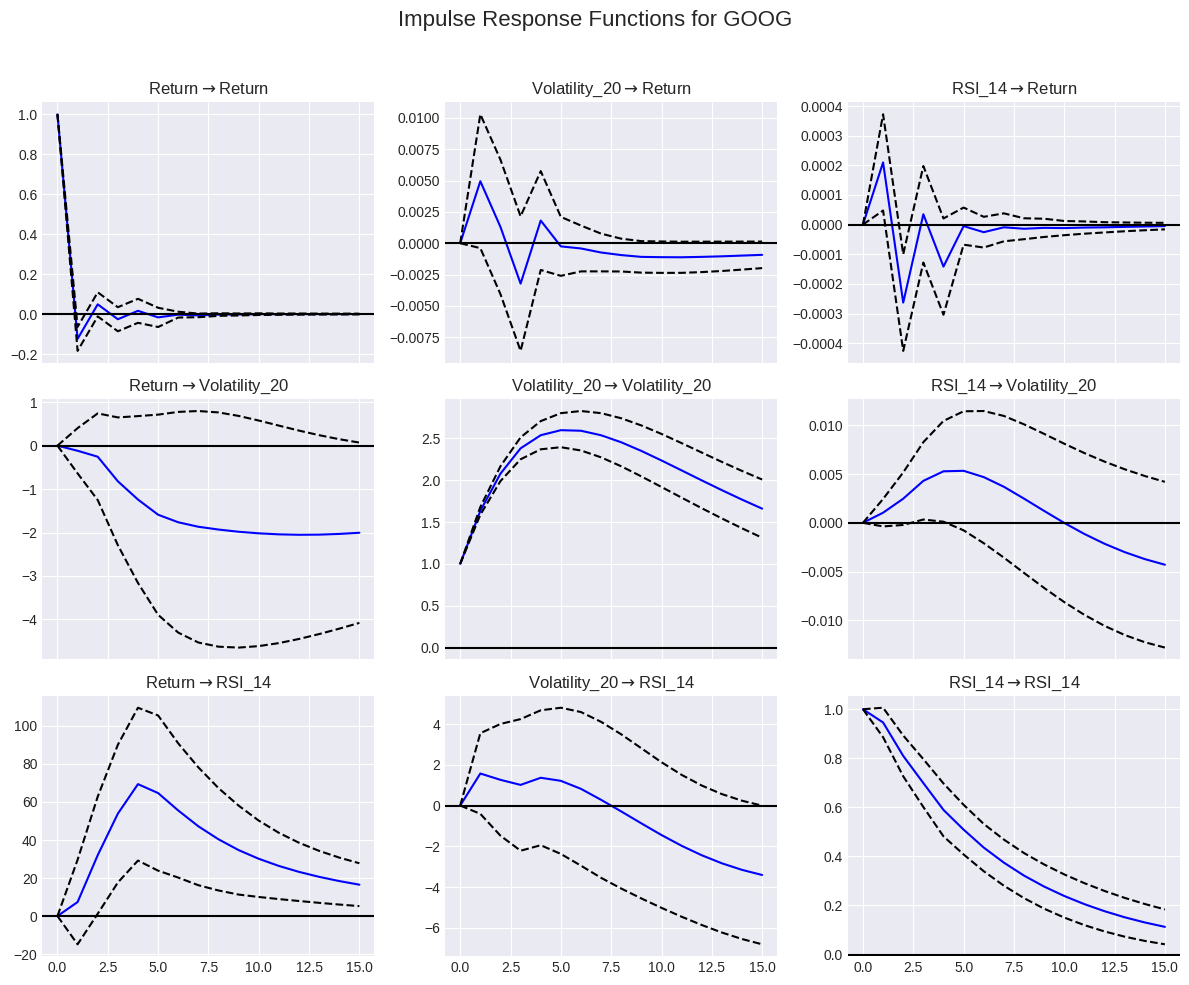

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import warnings

warnings.filterwarnings('ignore')

# Note: This script requires the 'statsmodels' library.
# You may need to install it: pip install statsmodels

def run_var_analysis(file_path, ticker_symbol):
    """
    Performs a Vector Autoregression (VAR) analysis to model the
    interdependencies between a stock's returns, volatility, and momentum.
    """
    print(f"--- Running Vector Autoregression (VAR) Analysis for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Time-Series Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)

    # Select the features for our model
    features = ['Return', 'Volatility_20', 'RSI_14']
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol][['Date'] + features].copy()
    ticker_df.set_index('Date', inplace=True)

    # VAR models require stationary data with no missing values
    ticker_df.dropna(inplace=True)

    if ticker_df.empty:
        print(f"Not enough data for {ticker_symbol} to run the analysis.")
        return

    print(f"  > Prepared dataset with {len(ticker_df)} observations.")

    # --- Step 2: Fit the VAR Model ---
    # A VAR model is fitted to the data. We let the model select the optimal
    # number of lags (past time periods) to consider.
    print("  > Fitting the VAR model...")
    model = VAR(ticker_df)
    # lag_order = model.select_order(maxlags=15)
    # print(lag_order.summary()) # Uncomment to see the optimal lag selection

    # For stability, we'll use a common lag order, e.g., 5
    results = model.fit(5)
    # print(results.summary()) # Uncomment to see the detailed regression results

    # --- Step 3: Granger Causality Test ---
    print("\n--- Granger Causality Test Results ---")
    # This tests if one variable is useful in forecasting another.
    # We test if the columns in 'caused' are Granger-caused by the columns in 'causality'.
    # A low p-value (< 0.05) means we can reject the null hypothesis that there is NO causality.
    print("Does Volatility or RSI Granger-cause Returns?")
    causality_test_returns = results.test_causality('Return', ['Volatility_20', 'RSI_14'], kind='f')
    print(causality_test_returns.summary())

    # --- Step 4: Generate and Visualize Impulse Response Functions (IRF) ---
    print("\n  > Generating Impulse Response Functions (IRF)...")
    # An IRF traces the effect of a one-standard-deviation shock to one variable on the others.
    irf = results.irf(periods=15) # Forecast the response over 15 days

    # Create the plot
    irf.plot(orth=False, figsize=(12, 10))
    plt.suptitle(f'Impulse Response Functions for {ticker_symbol}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    output_filename = f'var_irf_analysis_{ticker_symbol}.png'
    plt.savefig(output_filename)
    print(f"\nImpulse Response Function chart saved as '{output_filename}'")
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
# Let's use a stock with interesting dynamics
run_var_analysis(your_daily_file, 'GOOG')

--- Running Vector Autoregression (VAR) Analysis for BA ---
  > Prepared dataset with 1813 observations.
  > Fitting the VAR model...

--- Granger Causality Test Results ---
Does Volatility or RSI Granger-cause Returns?
Granger causality F-test. H_0: ['Volatility_20', 'RSI_14'] do not Granger-cause Return. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         3.090          1.832   0.001 (10, 5376)
------------------------------------------------

  > Generating Impulse Response Functions (IRF)...

Impulse Response Function chart saved as 'var_irf_analysis_BA.png'


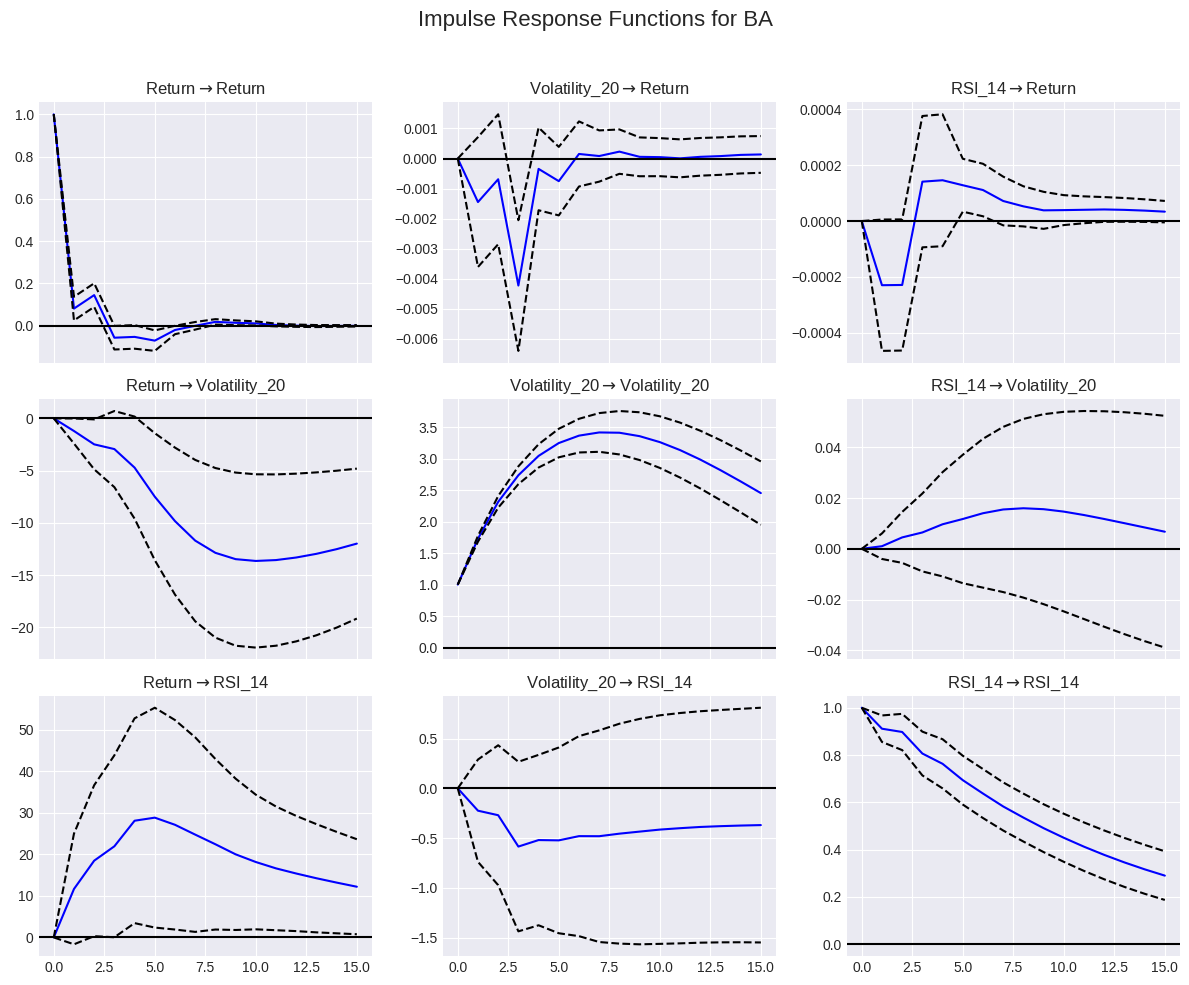

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import warnings

warnings.filterwarnings('ignore')

# Note: This script requires the 'statsmodels' library.
# You may need to install it: pip install statsmodels

def run_var_analysis(file_path, ticker_symbol):
    """
    Performs a Vector Autoregression (VAR) analysis to model the
    interdependencies between a stock's returns, volatility, and momentum.
    """
    print(f"--- Running Vector Autoregression (VAR) Analysis for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Time-Series Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)

    # Select the features for our model
    features = ['Return', 'Volatility_20', 'RSI_14']
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol][['Date'] + features].copy()
    ticker_df.set_index('Date', inplace=True)

    # VAR models require stationary data with no missing values
    ticker_df.dropna(inplace=True)

    if ticker_df.empty:
        print(f"Not enough data for {ticker_symbol} to run the analysis.")
        return

    print(f"  > Prepared dataset with {len(ticker_df)} observations.")

    # --- Step 2: Fit the VAR Model ---
    # A VAR model is fitted to the data. We let the model select the optimal
    # number of lags (past time periods) to consider.
    print("  > Fitting the VAR model...")
    model = VAR(ticker_df)
    # lag_order = model.select_order(maxlags=15)
    # print(lag_order.summary()) # Uncomment to see the optimal lag selection

    # For stability, we'll use a common lag order, e.g., 5
    results = model.fit(5)
    # print(results.summary()) # Uncomment to see the detailed regression results

    # --- Step 3: Granger Causality Test ---
    print("\n--- Granger Causality Test Results ---")
    # This tests if one variable is useful in forecasting another.
    # We test if the columns in 'caused' are Granger-caused by the columns in 'causality'.
    # A low p-value (< 0.05) means we can reject the null hypothesis that there is NO causality.
    print("Does Volatility or RSI Granger-cause Returns?")
    causality_test_returns = results.test_causality('Return', ['Volatility_20', 'RSI_14'], kind='f')
    print(causality_test_returns.summary())

    # --- Step 4: Generate and Visualize Impulse Response Functions (IRF) ---
    print("\n  > Generating Impulse Response Functions (IRF)...")
    # An IRF traces the effect of a one-standard-deviation shock to one variable on the others.
    irf = results.irf(periods=15) # Forecast the response over 15 days

    # Create the plot
    irf.plot(orth=False, figsize=(12, 10))
    plt.suptitle(f'Impulse Response Functions for {ticker_symbol}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    output_filename = f'var_irf_analysis_{ticker_symbol}.png'
    plt.savefig(output_filename)
    print(f"\nImpulse Response Function chart saved as '{output_filename}'")
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
# Let's use a stock with interesting dynamics
run_var_analysis(your_daily_file, 'BA')

--- Running Dynamic Correlation & Systemic Risk Analysis ---
  > Generating comparative correlation heatmaps...
  > Heatmaps saved as 'comparative_correlation_heatmaps.png'


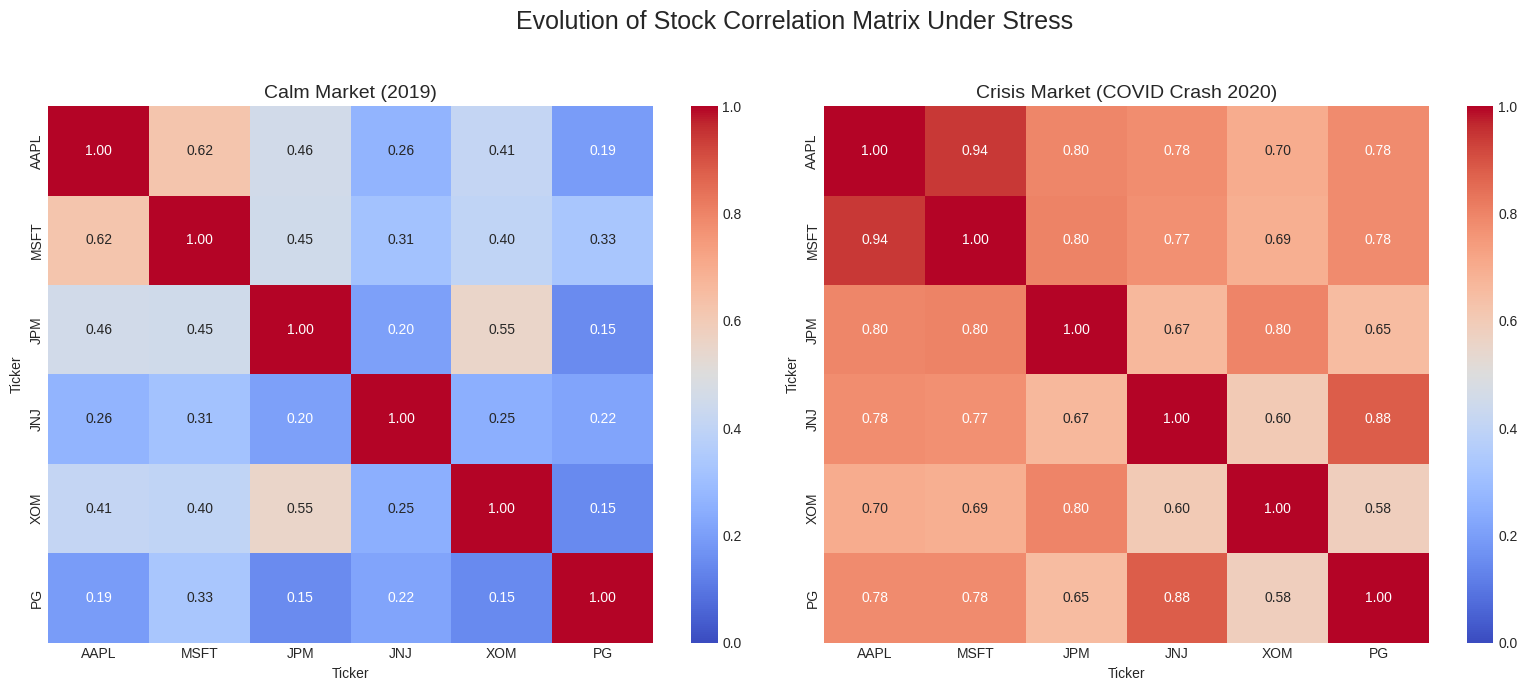


  > Generating average correlation time-series...
  > Average correlation chart saved as 'average_correlation_timeseries.png'


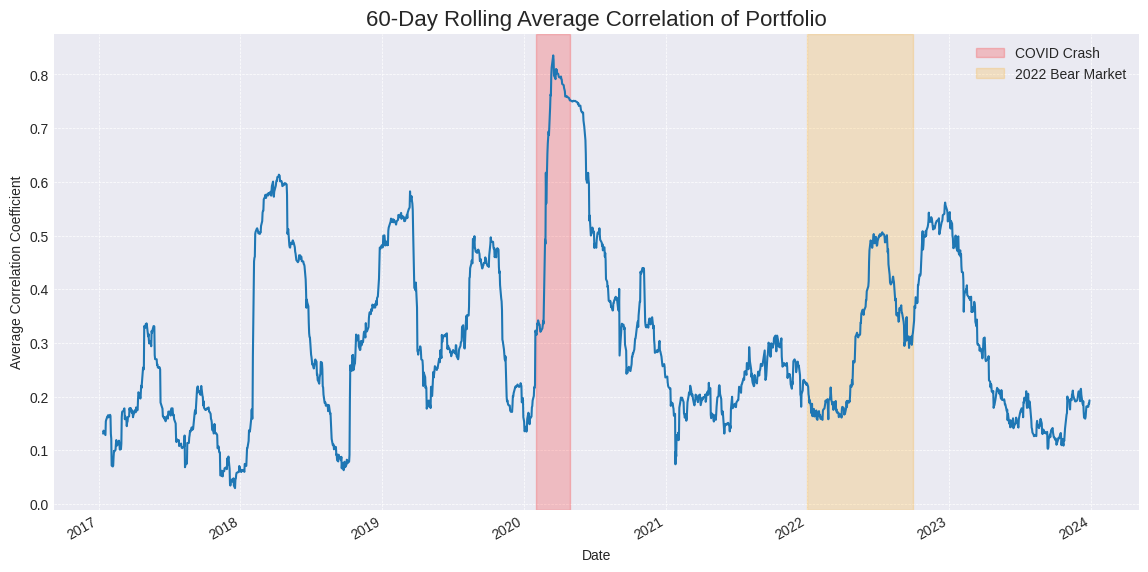

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

def run_dynamic_correlation_analysis(file_path, tickers_list):
    """
    Analyzes the evolution of the correlation matrix for a portfolio of stocks,
    highlighting changes during market stress.
    """
    print("--- Running Dynamic Correlation & Systemic Risk Analysis ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare Returns Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    price_pivot = df_full.pivot(index='Date', columns='Ticker', values='Close')
    returns_df = price_pivot[tickers_list].pct_change().dropna()

    # --- Part 1: Comparative Correlation Heatmaps ---
    print("  > Generating comparative correlation heatmaps...")

    # Define a calm period (pre-COVID) and a crisis period (COVID crash)
    calm_period = returns_df['2019-01-01':'2019-12-31']
    crisis_period = returns_df['2020-02-01':'2020-04-30']

    calm_corr = calm_period.corr()
    crisis_corr = crisis_period.corr()

    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle('Evolution of Stock Correlation Matrix Under Stress', fontsize=18)

    sns.heatmap(calm_corr, ax=ax1, annot=True, cmap='coolwarm', fmt=".2f", vmin=0, vmax=1)
    ax1.set_title('Calm Market (2019)', fontsize=14)

    sns.heatmap(crisis_corr, ax=ax2, annot=True, cmap='coolwarm', fmt=".2f", vmin=0, vmax=1)
    ax2.set_title('Crisis Market (COVID Crash 2020)', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('comparative_correlation_heatmaps.png')
    print("  > Heatmaps saved as 'comparative_correlation_heatmaps.png'")
    plt.show()

    # --- Part 2: Average Correlation Time-Series ---
    print("\n  > Generating average correlation time-series...")

    # Calculate the 60-day rolling correlation matrix
    rolling_corr = returns_df.rolling(window=60).corr()

    # Calculate the average of the off-diagonal correlations for each day
    avg_corr = rolling_corr.groupby('Date').apply(lambda x: x.values[np.triu_indices_from(x.values, 1)].mean())

    # --- Create the Time-Series Chart ---
    plt.figure(figsize=(14, 7))
    avg_corr.plot()

    plt.title('60-Day Rolling Average Correlation of Portfolio', fontsize=16)
    plt.ylabel('Average Correlation Coefficient')
    plt.xlabel('Date')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Highlight key crisis periods
    plt.axvspan('2020-02-01', '2020-04-30', color='red', alpha=0.2, label='COVID Crash')
    plt.axvspan('2022-01-01', '2022-10-01', color='orange', alpha=0.2, label='2022 Bear Market')

    plt.legend()
    plt.savefig('average_correlation_timeseries.png')
    print("  > Average correlation chart saved as 'average_correlation_timeseries.png'")
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'

# A diverse list of tickers from different sectors
tickers_for_analysis = ['AAPL', 'MSFT', 'JPM', 'JNJ', 'XOM', 'PG']

run_dynamic_correlation_analysis(your_daily_file, tickers_for_analysis)


#Bear VS Bull Market

--- Generating Bull vs. Bear Market Regime Chart using SPY ---

Market regime chart saved as 'market_regimes_2016_2024.png'


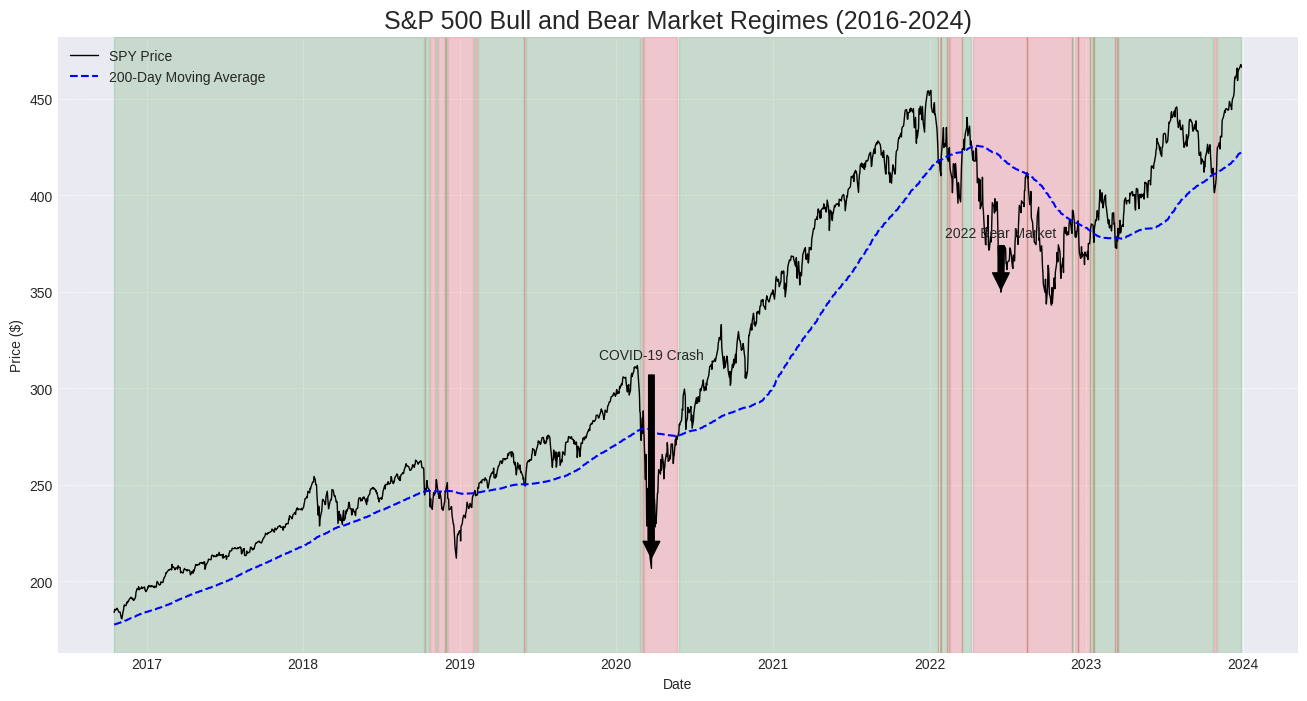

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def visualize_market_regimes(file_path, benchmark_ticker='SPY'):
    """
    Visualizes the bull and bear market regimes based on the benchmark's
    price relative to its 200-day moving average.
    """
    print(f"--- Generating Bull vs. Bear Market Regime Chart using {benchmark_ticker} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare Benchmark Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)

    benchmark_df = df_full[df_full['Ticker'] == benchmark_ticker].copy()
    if benchmark_df.empty:
        print(f"Error: Benchmark ticker '{benchmark_ticker}' not found in the dataset.")
        return

    benchmark_df.set_index('Date', inplace=True)

    # Calculate the 200-day moving average if it doesn't exist
    if 'MA_200' not in benchmark_df.columns:
        benchmark_df['MA_200'] = benchmark_df['Close'].rolling(window=200).mean()

    benchmark_df.dropna(subset=['MA_200'], inplace=True)

    # --- Step 2: Define the Regimes ---
    benchmark_df['Regime'] = 'Bull'
    benchmark_df.loc[benchmark_df['Close'] < benchmark_df['MA_200'], 'Regime'] = 'Bear'

    # --- Step 3: Create the Visualization ---
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(16, 8))

    # Plot the price and the moving average
    plt.plot(benchmark_df.index, benchmark_df['Close'], label=f'{benchmark_ticker} Price', color='black', linewidth=1)
    plt.plot(benchmark_df.index, benchmark_df['MA_200'], label='200-Day Moving Average', color='blue', linestyle='--')

    # --- Shade the background based on the regime ---
    # We need to find the start and end of each regime block
    regime_changes = benchmark_df['Regime'].ne(benchmark_df['Regime'].shift())
    regime_blocks = regime_changes.cumsum()

    for i in range(1, regime_blocks.max() + 1):
        block = benchmark_df[regime_blocks == i]
        start_date = block.index.min()
        end_date = block.index.max()
        regime = block['Regime'].iloc[0]

        color = 'green' if regime == 'Bull' else 'red'
        plt.axvspan(start_date, end_date, color=color, alpha=0.15)

    plt.title('S&P 500 Bull and Bear Market Regimes (2016-2024)', fontsize=18)
    plt.ylabel('Price ($)')
    plt.xlabel('Date')
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Add annotations for key events
    plt.annotate('COVID-19 Crash', xy=(pd.to_datetime('2020-03-23'), benchmark_df.loc['2020-03-23']['Close']),
                 xytext=(pd.to_datetime('2020-03-23'), benchmark_df['Close'].mean()),
                 arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

    plt.annotate('2022 Bear Market', xy=(pd.to_datetime('2022-06-16'), benchmark_df.loc['2022-06-16']['Close']),
                 xytext=(pd.to_datetime('2022-06-16'), benchmark_df['Close'].mean() * 1.2),
                 arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

    output_filename = 'market_regimes_2016_2024.png'
    plt.savefig(output_filename)
    print(f"\nMarket regime chart saved as '{output_filename}'")
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
visualize_market_regimes(your_daily_file)

#Sector-Level Relative Rotation Analysis

--- Running Sector-Level Relative Rotation Analysis ---

--- Latest RRG Coordinates ---
                        RRG_Strength  RRG_Momentum
Technology                     97.79         -0.24
Financials                    100.79          0.61
Consumer Staples               94.68          1.13
Energy                         90.51         -1.08
Industrials                   112.33         -2.02
Consumer Discretionary        100.28         -1.34

Relative Rotation Graph saved as 'rrg_sector_analysis.png'


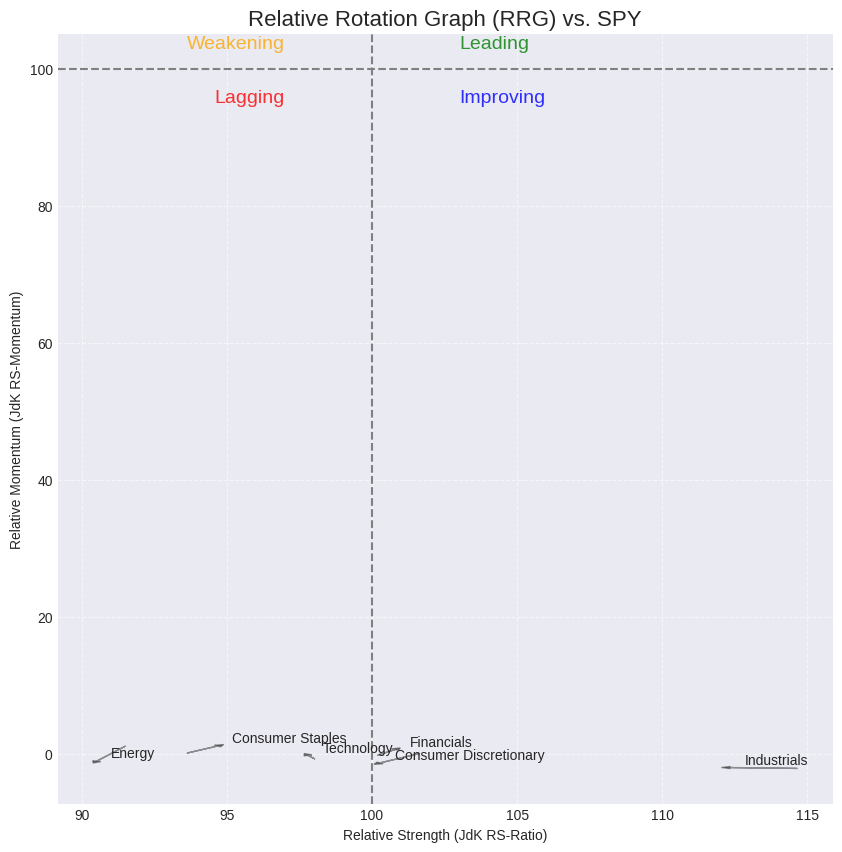

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def plot_rrg(df_rrg, benchmark_ticker):
    """
    Plots a Relative Rotation Graph.
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    # Quadrant lines
    ax.axhline(100, color='grey', linestyle='--')
    ax.axvline(100, color='grey', linestyle='--')

    # Plot data points (invisibly) to set axes limits
    ax.scatter(df_rrg['RRG_Strength'], df_rrg['RRG_Momentum'], s=0)

    # Add annotations and arrows
    for sector_name, row in df_rrg.iterrows():
        # --- FIXED: Use the index name (sector_name) for the label ---
        ax.annotate(sector_name, (row['RRG_Strength'], row['RRG_Momentum']),
                    xytext=(row['RRG_Strength']+0.5, row['RRG_Momentum']+0.5))

        # Add a "tail" showing recent movement
        ax.arrow(row['Prev_Strength'], row['Prev_Momentum'],
                 row['RRG_Strength'] - row['Prev_Strength'],
                 row['RRG_Momentum'] - row['Prev_Momentum'],
                 head_width=0.3, head_length=0.3, fc='black', ec='black', alpha=0.4)

    # Quadrant labels
    ax.text(103, 103, 'Leading', fontsize=14, color='green', alpha=0.8)
    ax.text(97, 103, 'Weakening', fontsize=14, color='orange', alpha=0.8, ha='right')
    ax.text(97, 97, 'Lagging', fontsize=14, color='red', alpha=0.8, ha='right', va='top')
    ax.text(103, 97, 'Improving', fontsize=14, color='blue', alpha=0.8, va='top')

    ax.set_title(f'Relative Rotation Graph (RRG) vs. {benchmark_ticker}', fontsize=16)
    ax.set_xlabel('Relative Strength (JdK RS-Ratio)')
    ax.set_ylabel('Relative Momentum (JdK RS-Momentum)')
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.savefig('rrg_sector_analysis.png')
    print("\nRelative Rotation Graph saved as 'rrg_sector_analysis.png'")
    plt.show()


def run_rrg_analysis(file_path, sector_map):
    """
    Performs a sector-level Relative Rotation Graph analysis.
    """
    print("--- Running Sector-Level Relative Rotation Analysis ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    df_full.set_index('Date', inplace=True)

    # --- Step 1: Create Sector Indices ---
    sector_indices = pd.DataFrame()
    all_tickers_in_map = [ticker for tickers in sector_map.values() for ticker in tickers]

    # Pivot the data once for efficiency
    price_pivot = df_full[df_full['Ticker'].isin(all_tickers_in_map + ['SPY'])].pivot(columns='Ticker', values='Close')

    for sector, tickers in sector_map.items():
        # Calculate an equal-weighted index for each sector
        sector_prices = price_pivot[tickers].mean(axis=1)
        sector_indices[sector] = sector_prices

    # Add the benchmark
    benchmark_ticker = 'SPY'
    sector_indices[benchmark_ticker] = price_pivot[benchmark_ticker]
    sector_indices.dropna(inplace=True)

    # --- Step 2: Calculate RRG Inputs ---
    rs = sector_indices.div(sector_indices[benchmark_ticker], axis=0)
    rs_ratio = (rs / rs.rolling(window=52).mean()) * 100
    rs_momentum = rs_ratio.pct_change(periods=4).mul(100)

    # Get the latest values for the plot
    latest_rrg = pd.DataFrame({
        'RRG_Strength': rs_ratio.iloc[-1],
        'RRG_Momentum': rs_momentum.iloc[-1],
        'Prev_Strength': rs_ratio.iloc[-5], # Previous week's data for the "tail"
        'Prev_Momentum': rs_momentum.iloc[-5],
    }).dropna()

    latest_rrg = latest_rrg.drop(benchmark_ticker)

    print("\n--- Latest RRG Coordinates ---")
    print(latest_rrg[['RRG_Strength', 'RRG_Momentum']].round(2))

    # --- Step 3: Generate the Plot ---
    plot_rrg(latest_rrg, benchmark_ticker)


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'

# Define our sectors and the stocks within them
sector_map = {
    'Technology': ['AAPL', 'MSFT', 'NVDA'],
    'Financials': ['JPM', 'V'],
    'Consumer Staples': ['PG', 'JNJ'],
    'Energy': ['XOM'],
    'Industrials': ['BA'],
    'Consumer Discretionary': ['AMZN', 'TSLA']
}

run_rrg_analysis(your_daily_file, sector_map)


--- Running Covered Call Strategy Backtest for MSFT ---


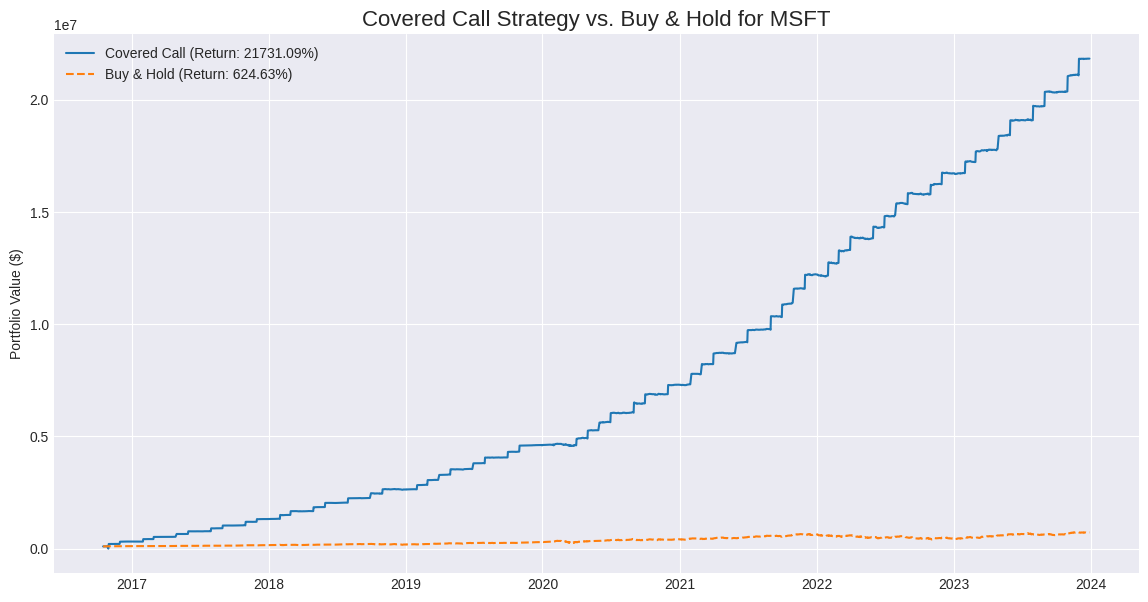


           Strategy Performance Comparison
Metric               | Covered Call    | Buy & Hold     
------------------------------------------------------------
Total Return (%)     |       21731.09 |         624.63
Sharpe Ratio         |            nan |           1.12
Max Drawdown (%)     |        -100.00 |         -37.15


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

warnings.filterwarnings('ignore')

def black_scholes_premium(S, K, T, r, sigma):
    """
    Calculates the premium for a European call option using the Black-Scholes formula.
    """
    if T <= 0 or sigma <= 0: return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_premium = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call_premium

def run_covered_call_backtest(file_path, ticker_symbol, initial_capital=100000.0):
    """
    Runs a backtest for a monthly covered call strategy and compares it
    to a buy-and-hold strategy.
    """
    print(f"--- Running Covered Call Strategy Backtest for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Step 1: Prepare Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    ticker_df.set_index('Date', inplace=True)
    ticker_df.dropna(subset=['Volatility_20', 'Close'], inplace=True)
    if ticker_df.empty: return

    # --- Step 2: The Backtesting Simulation (Corrected Logic) ---
    cash = 0
    start_price = ticker_df['Close'].iloc[0]
    shares_held = initial_capital / start_price

    portfolio_history = []
    strike_price = 0  # Initialize strike_price outside the loop

    # Get month start and end dates for our logic
    month_starts = ticker_df.resample('MS').first().index
    month_ends = ticker_df.resample('M').last().index

    for date, row in ticker_df.iterrows():
        current_price = row['Close']

        # On the first trading day of a month, "sell" a new call option
        if date in month_starts:
            strike_price = current_price * 1.05 # 5% out-of-the-money
            time_to_maturity = 30 / 365.25
            risk_free_rate = 0.04
            annualized_volatility = row['Volatility_20'] * np.sqrt(252)

            premium_per_share = black_scholes_premium(current_price, strike_price, time_to_maturity, risk_free_rate, annualized_volatility)
            cash += premium_per_share * shares_held

        # Calculate the daily value of the portfolio
        portfolio_value = (shares_held * current_price) + cash

        # On the last trading day of the month, check for option assignment
        if date in month_ends:
            if current_price > strike_price:
                # The shares are "called away". The upside is capped.
                # Calculate the opportunity loss from not holding the stock above the strike
                opportunity_loss = (current_price - strike_price) * shares_held
                portfolio_value -= opportunity_loss

        portfolio_history.append({'Date': date, 'Value': portfolio_value})

    # --- Step 3: Analyze and Visualize ---
    portfolio_df = pd.DataFrame(portfolio_history).set_index('Date')
    buy_hold_equity = (ticker_df['Close'] / ticker_df['Close'].iloc[0]) * initial_capital

    # Calculate final stats
    final_value_cc = portfolio_df['Value'].iloc[-1]
    return_cc = (final_value_cc - initial_capital) / initial_capital * 100
    sharpe_cc = np.sqrt(252) * portfolio_df['Value'].pct_change().mean() / portfolio_df['Value'].pct_change().std()
    max_drawdown_cc = (portfolio_df['Value'] / portfolio_df['Value'].cummax() - 1).min() * 100

    final_value_bh = buy_hold_equity.iloc[-1]
    return_bh = (final_value_bh - initial_capital) / initial_capital * 100
    sharpe_bh = np.sqrt(252) * buy_hold_equity.pct_change().mean() / buy_hold_equity.pct_change().std()
    max_drawdown_bh = (buy_hold_equity / buy_hold_equity.cummax() - 1).min() * 100

    # Create the visualization
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_df.index, portfolio_df['Value'], label=f'Covered Call (Return: {return_cc:.2f}%)')
    plt.plot(buy_hold_equity.index, buy_hold_equity, label=f'Buy & Hold (Return: {return_bh:.2f}%)', linestyle='--')
    plt.title(f'Covered Call Strategy vs. Buy & Hold for {ticker_symbol}', fontsize=16)
    plt.ylabel('Portfolio Value ($)'); plt.legend(); plt.grid(True)
    plt.savefig(f'covered_call_backtest_{ticker_symbol}.png')
    plt.show()

    print("\n" + "="*60)
    print("           Strategy Performance Comparison")
    print("="*60)
    print(f"{'Metric':<20} | {'Covered Call':<15} | {'Buy & Hold':<15}")
    print("-"*60)
    print(f"{'Total Return (%)':<20} | {return_cc:14.2f} | {return_bh:14.2f}")
    print(f"{'Sharpe Ratio':<20} | {sharpe_cc:14.2f} | {sharpe_bh:14.2f}")
    print(f"{'Max Drawdown (%)':<20} | {max_drawdown_cc:14.2f} | {max_drawdown_bh:14.2f}")
    print("="*60)

# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_covered_call_backtest(your_daily_file, 'MSFT')


#Analyzing the Day-of-the-Week Anomaly

--- Running Day-of-the-Week Effect Analysis for SPY ---

--- Statistical Summary of Daily Returns by Weekday ---
             mean     std  count
Weekday                         
Monday     0.0639  1.3052    337
Tuesday    0.0809  1.1357    372
Wednesday  0.0599  1.1273    372
Thursday   0.0152  1.2224    367
Friday     0.0715  1.1445    365

--- ANOVA Test Results ---
F-statistic: 0.1680
P-value: 0.9547
  > Verdict: FAIL to reject the null hypothesis. There is no statistically significant difference in returns across weekdays.

Weekday effect chart saved as 'weekday_effect_SPY.png'


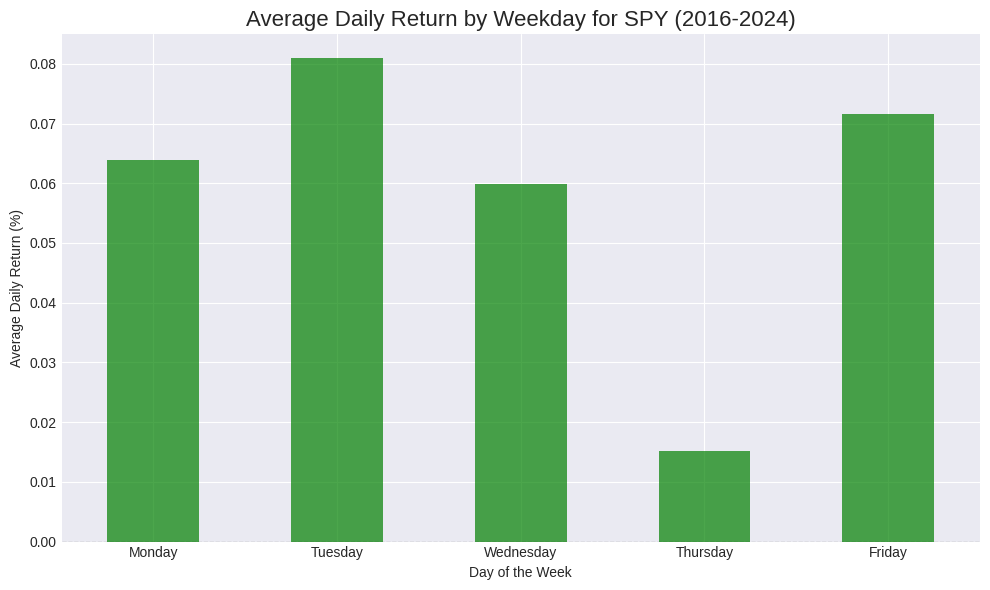

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import warnings

warnings.filterwarnings('ignore')

def analyze_day_of_week_effect(file_path, ticker_symbol):
    """
    Analyzes the historical day-of-the-week effect on a stock's returns.
    """
    print(f"--- Running Day-of-the-Week Effect Analysis for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    df_full.dropna(subset=['Date'], inplace=True)

    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    if ticker_df.empty:
        print(f"No data found for {ticker_symbol}.")
        return

    ticker_df.set_index('Date', inplace=True)

    # --- Step 2: Calculate Daily Returns and Group by Weekday ---
    # We use the 'Return' column directly from your dataset
    daily_returns = ticker_df['Return'].dropna() * 100 # Convert to percentage

    # Add the weekday name as a column to group by
    daily_returns_df = pd.DataFrame(daily_returns)
    daily_returns_df['Weekday'] = daily_returns_df.index.day_name()

    # Calculate the average return for each weekday
    weekday_stats = daily_returns_df.groupby('Weekday')['Return'].agg(['mean', 'std', 'count'])

    # Order the days correctly for plotting
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekday_stats = weekday_stats.reindex(day_order)

    print("\n--- Statistical Summary of Daily Returns by Weekday ---")
    print(weekday_stats.round(4))

    # --- Step 3: Statistical Test (ANOVA) ---
    # ANOVA tests the null hypothesis that the mean returns for all days are equal.
    # A low p-value (< 0.05) suggests that at least one day is significantly different.
    grouped_returns = [group['Return'].values for name, group in daily_returns_df.groupby('Weekday')]
    f_stat, p_value = f_oneway(*grouped_returns)

    print("\n--- ANOVA Test Results ---")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("  > Verdict: REJECT the null hypothesis. The differences in daily returns are statistically significant.")
    else:
        print("  > Verdict: FAIL to reject the null hypothesis. There is no statistically significant difference in returns across weekdays.")

    # --- Step 4: Visualize the Results ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['green' if x > 0 else 'red' for x in weekday_stats['mean']]
    weekday_stats['mean'].plot(kind='bar', ax=ax, color=colors, alpha=0.7)

    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_title(f'Average Daily Return by Weekday for {ticker_symbol} (2016-2024)', fontsize=16)
    ax.set_ylabel('Average Daily Return (%)')
    ax.set_xlabel('Day of the Week')
    ax.tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.savefig(f'weekday_effect_{ticker_symbol}.png')
    print(f"\nWeekday effect chart saved as 'weekday_effect_{ticker_symbol}.png'")
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
# Let's analyze the S&P 500 as a whole using the SPY ticker
analyze_day_of_week_effect(your_daily_file, 'SPY')


#Tail Risk and Rolling CVaR Analysis.

--- Running Tail Risk & Rolling CVaR Analysis for BA ---
  > Generating return distribution plot...


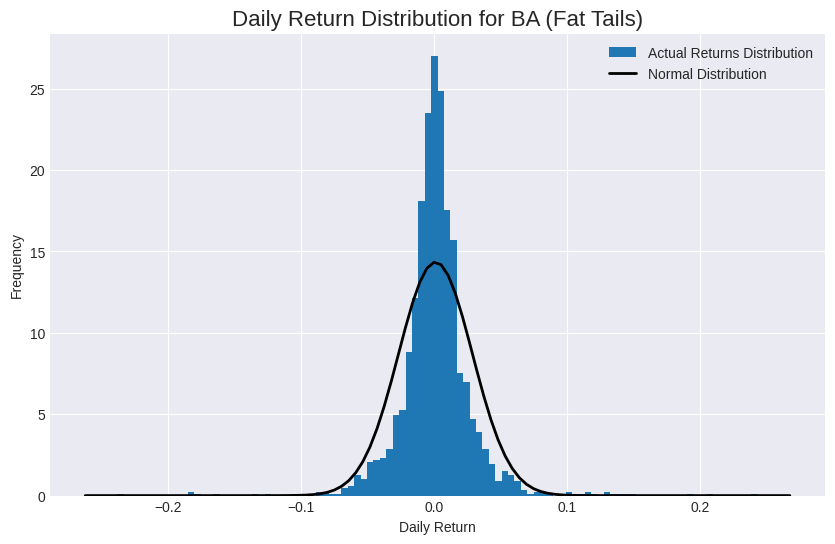

  > Calculating rolling Conditional Value-at-Risk (CVaR)...
  > Generating final risk dashboard...


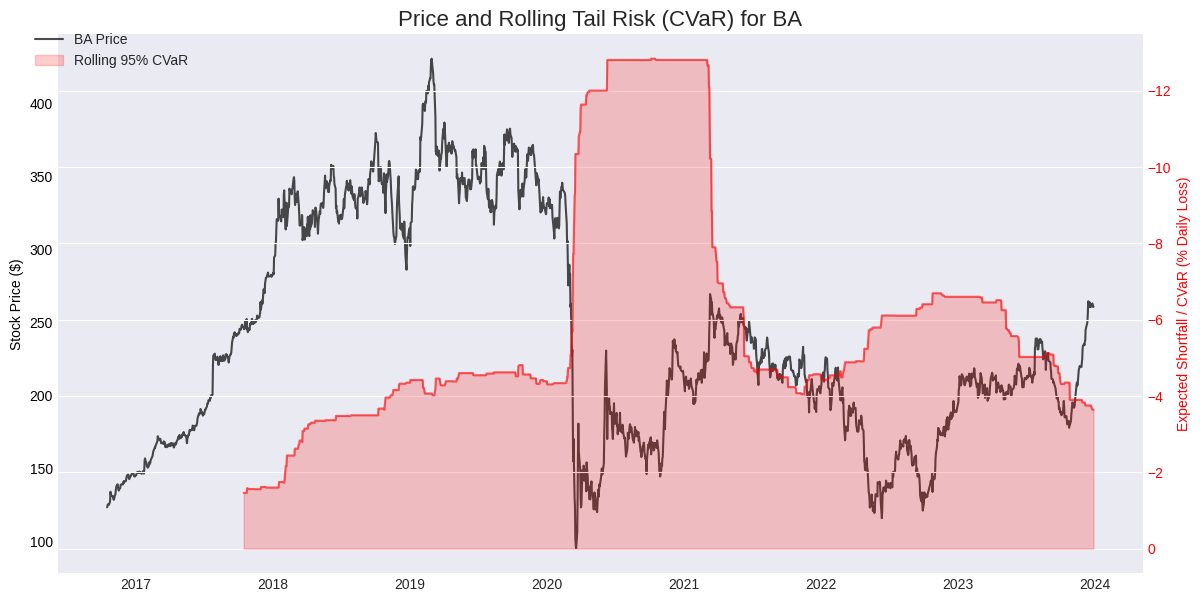

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

warnings.filterwarnings('ignore')

def run_tail_risk_with_cvar(file_path, ticker_symbol, window_size=252, confidence_level=0.95):
    """
    Performs a tail risk analysis using a rolling Conditional Value-at-Risk (CVaR) calculation.
    """
    print(f"--- Running Tail Risk & Rolling CVaR Analysis for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Returns Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    ticker_df.set_index('Date', inplace=True)

    if ticker_df.empty or 'Return' not in ticker_df.columns:
        print(f"No valid return data for {ticker_symbol}.")
        return

    returns = ticker_df['Return'].dropna()

    # --- Visualization 1: Return Distribution Histogram ---
    print("  > Generating return distribution plot...")
    plt.figure(figsize=(10, 6))
    returns.hist(bins=100, density=True, label='Actual Returns Distribution')
    mu, std = norm.fit(returns)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
    plt.title(f'Daily Return Distribution for {ticker_symbol} (Fat Tails)', fontsize=16)
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'return_distribution_{ticker_symbol}.png')
    plt.show()

    # --- Step 2: Calculate Rolling CVaR (Expected Shortfall) ---
    print("  > Calculating rolling Conditional Value-at-Risk (CVaR)...")

    def calculate_cvar(window):
        var_threshold = window.quantile(1 - confidence_level)
        tail_losses = window[window < var_threshold]
        if tail_losses.empty:
            return np.nan
        return tail_losses.mean()

    # --- FIXED: Removed the raw=True argument ---
    rolling_cvar = returns.rolling(window=window_size).apply(calculate_cvar).dropna()

    # --- Visualization 2: The Risk Dashboard ---
    print("  > Generating final risk dashboard...")
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.set_title(f'Price and Rolling Tail Risk (CVaR) for {ticker_symbol}', fontsize=16)

    ax1.plot(ticker_df.index, ticker_df['Close'], label=f'{ticker_symbol} Price', color='black', alpha=0.7)
    ax1.set_ylabel('Stock Price ($)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(False)

    ax2 = ax1.twinx()
    ax2.fill_between(rolling_cvar.index, rolling_cvar * 100, 0, color='red', alpha=0.2, label=f'Rolling {confidence_level:.0%} CVaR')
    ax2.plot(rolling_cvar.index, rolling_cvar * 100, color='red', alpha=0.6, linewidth=1.5)
    ax2.set_ylabel(f'Expected Shortfall / CVaR (% Daily Loss)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.invert_yaxis()

    fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
    plt.savefig(f'cvar_risk_dashboard_{ticker_symbol}.png')
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_tail_risk_with_cvar(your_daily_file, 'BA')


--- Running Tail Risk & Rolling CVaR Analysis for GOOG ---
  > Generating return distribution plot...


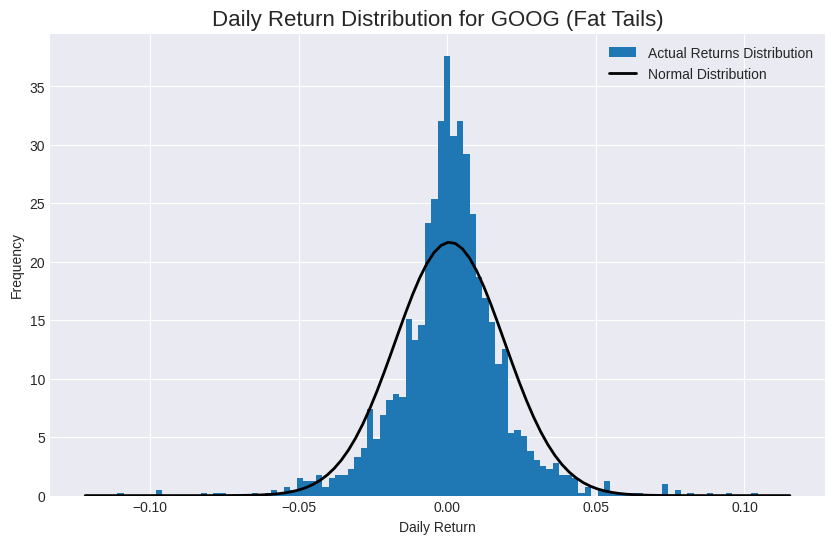

  > Calculating rolling Conditional Value-at-Risk (CVaR)...
  > Generating final risk dashboard...


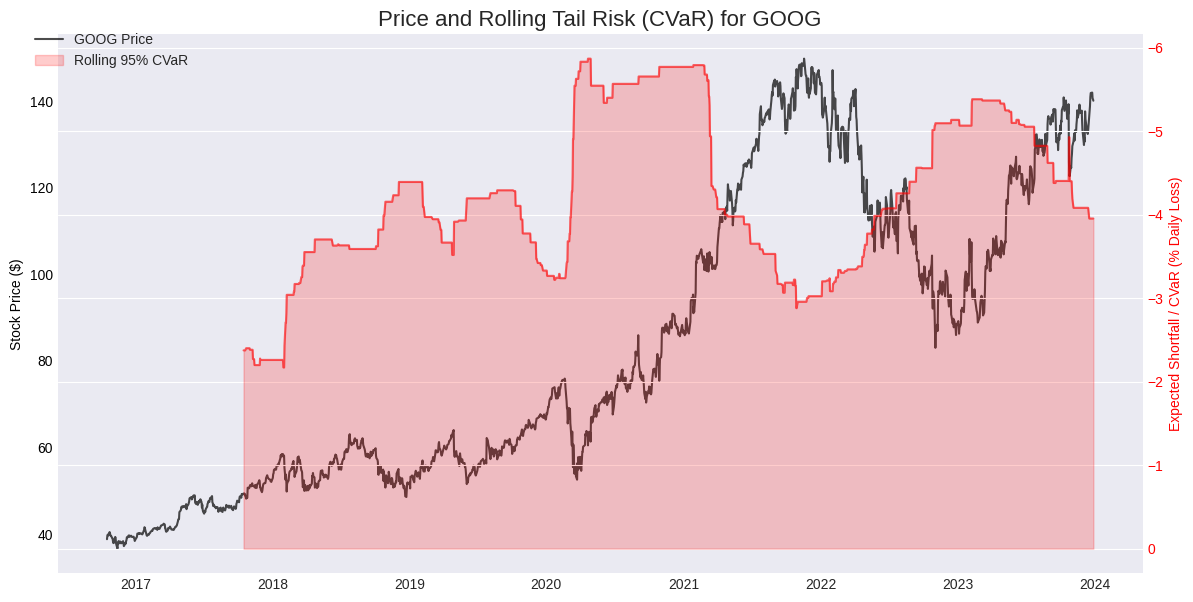

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

warnings.filterwarnings('ignore')

def run_tail_risk_with_cvar(file_path, ticker_symbol, window_size=252, confidence_level=0.95):
    """
    Performs a tail risk analysis using a rolling Conditional Value-at-Risk (CVaR) calculation.
    """
    print(f"--- Running Tail Risk & Rolling CVaR Analysis for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Returns Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    ticker_df.set_index('Date', inplace=True)

    if ticker_df.empty or 'Return' not in ticker_df.columns:
        print(f"No valid return data for {ticker_symbol}.")
        return

    returns = ticker_df['Return'].dropna()

    # --- Visualization 1: Return Distribution Histogram ---
    print("  > Generating return distribution plot...")
    plt.figure(figsize=(10, 6))
    returns.hist(bins=100, density=True, label='Actual Returns Distribution')
    mu, std = norm.fit(returns)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
    plt.title(f'Daily Return Distribution for {ticker_symbol} (Fat Tails)', fontsize=16)
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'return_distribution_{ticker_symbol}.png')
    plt.show()

    # --- Step 2: Calculate Rolling CVaR (Expected Shortfall) ---
    print("  > Calculating rolling Conditional Value-at-Risk (CVaR)...")

    def calculate_cvar(window):
        var_threshold = window.quantile(1 - confidence_level)
        tail_losses = window[window < var_threshold]
        if tail_losses.empty:
            return np.nan
        return tail_losses.mean()

    # --- FIXED: Removed the raw=True argument ---
    rolling_cvar = returns.rolling(window=window_size).apply(calculate_cvar).dropna()

    # --- Visualization 2: The Risk Dashboard ---
    print("  > Generating final risk dashboard...")
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.set_title(f'Price and Rolling Tail Risk (CVaR) for {ticker_symbol}', fontsize=16)

    ax1.plot(ticker_df.index, ticker_df['Close'], label=f'{ticker_symbol} Price', color='black', alpha=0.7)
    ax1.set_ylabel('Stock Price ($)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(False)

    ax2 = ax1.twinx()
    ax2.fill_between(rolling_cvar.index, rolling_cvar * 100, 0, color='red', alpha=0.2, label=f'Rolling {confidence_level:.0%} CVaR')
    ax2.plot(rolling_cvar.index, rolling_cvar * 100, color='red', alpha=0.6, linewidth=1.5)
    ax2.set_ylabel(f'Expected Shortfall / CVaR (% Daily Loss)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.invert_yaxis()

    fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
    plt.savefig(f'cvar_risk_dashboard_{ticker_symbol}.png')
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_tail_risk_with_cvar(your_daily_file, 'GOOG')


--- Running Tail Risk & Rolling CVaR Analysis for NVDA ---
  > Generating return distribution plot...


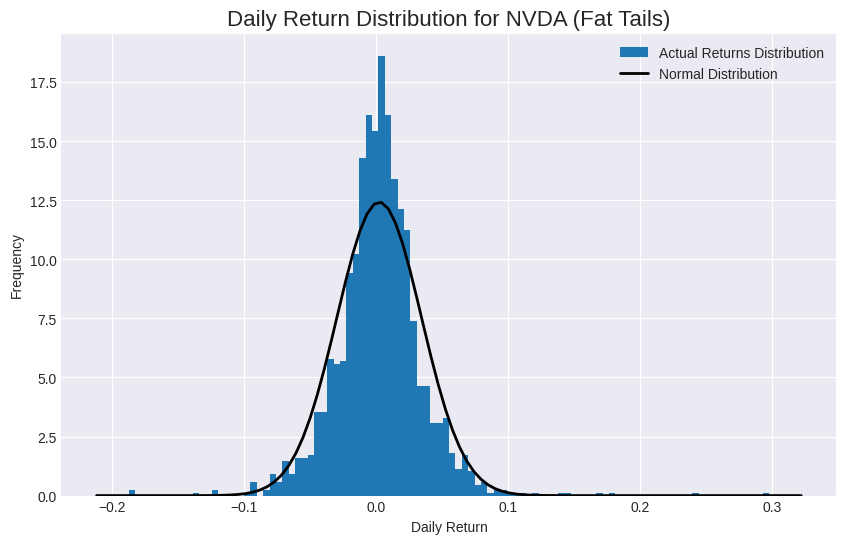

  > Calculating rolling Conditional Value-at-Risk (CVaR)...
  > Generating final risk dashboard...


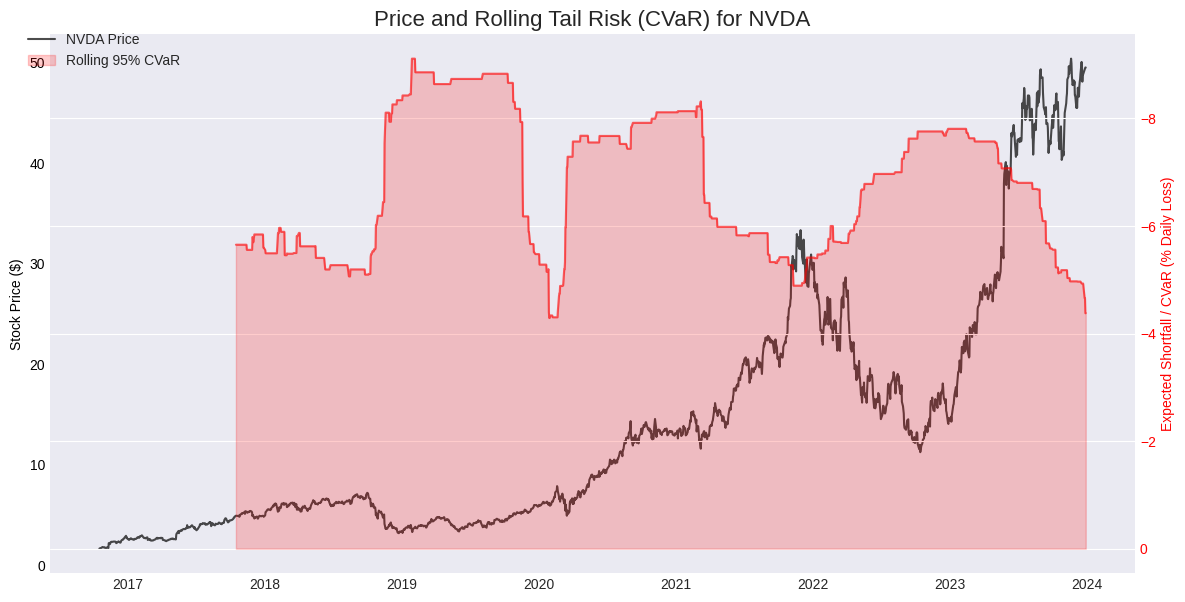

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

warnings.filterwarnings('ignore')

def run_tail_risk_with_cvar(file_path, ticker_symbol, window_size=252, confidence_level=0.95):
    """
    Performs a tail risk analysis using a rolling Conditional Value-at-Risk (CVaR) calculation.
    """
    print(f"--- Running Tail Risk & Rolling CVaR Analysis for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Returns Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()
    ticker_df.set_index('Date', inplace=True)

    if ticker_df.empty or 'Return' not in ticker_df.columns:
        print(f"No valid return data for {ticker_symbol}.")
        return

    returns = ticker_df['Return'].dropna()

    # --- Visualization 1: Return Distribution Histogram ---
    print("  > Generating return distribution plot...")
    plt.figure(figsize=(10, 6))
    returns.hist(bins=100, density=True, label='Actual Returns Distribution')
    mu, std = norm.fit(returns)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
    plt.title(f'Daily Return Distribution for {ticker_symbol} (Fat Tails)', fontsize=16)
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'return_distribution_{ticker_symbol}.png')
    plt.show()

    # --- Step 2: Calculate Rolling CVaR (Expected Shortfall) ---
    print("  > Calculating rolling Conditional Value-at-Risk (CVaR)...")

    def calculate_cvar(window):
        var_threshold = window.quantile(1 - confidence_level)
        tail_losses = window[window < var_threshold]
        if tail_losses.empty:
            return np.nan
        return tail_losses.mean()

    # --- FIXED: Removed the raw=True argument ---
    rolling_cvar = returns.rolling(window=window_size).apply(calculate_cvar).dropna()

    # --- Visualization 2: The Risk Dashboard ---
    print("  > Generating final risk dashboard...")
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.set_title(f'Price and Rolling Tail Risk (CVaR) for {ticker_symbol}', fontsize=16)

    ax1.plot(ticker_df.index, ticker_df['Close'], label=f'{ticker_symbol} Price', color='black', alpha=0.7)
    ax1.set_ylabel('Stock Price ($)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(False)

    ax2 = ax1.twinx()
    ax2.fill_between(rolling_cvar.index, rolling_cvar * 100, 0, color='red', alpha=0.2, label=f'Rolling {confidence_level:.0%} CVaR')
    ax2.plot(rolling_cvar.index, rolling_cvar * 100, color='red', alpha=0.6, linewidth=1.5)
    ax2.set_ylabel(f'Expected Shortfall / CVaR (% Daily Loss)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.invert_yaxis()

    fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
    plt.savefig(f'cvar_risk_dashboard_{ticker_symbol}.png')
    plt.show()


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_tail_risk_with_cvar(your_daily_file, 'NVDA')


--- Running Tail Risk & Rolling CVaR Analysis for BA ---
  > Generating return distribution plot...


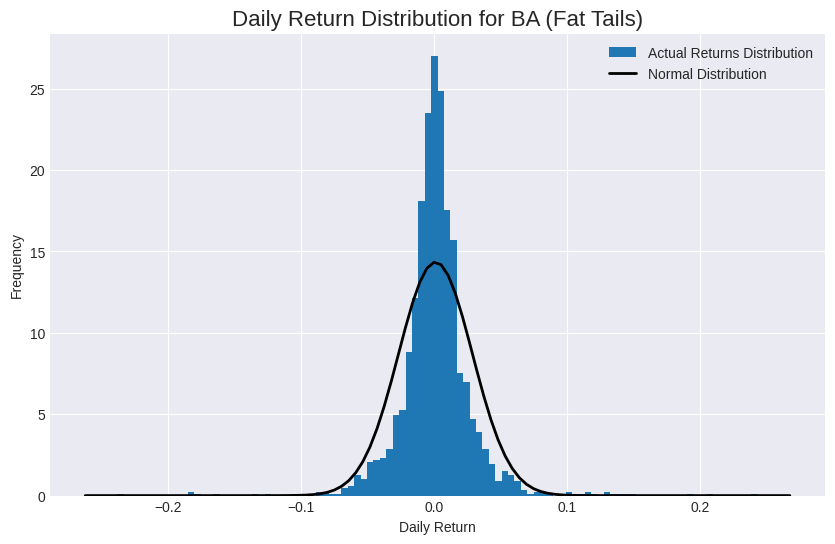

  > Calculating rolling Conditional Value-at-Risk (CVaR)...
  > Generating final risk dashboard...


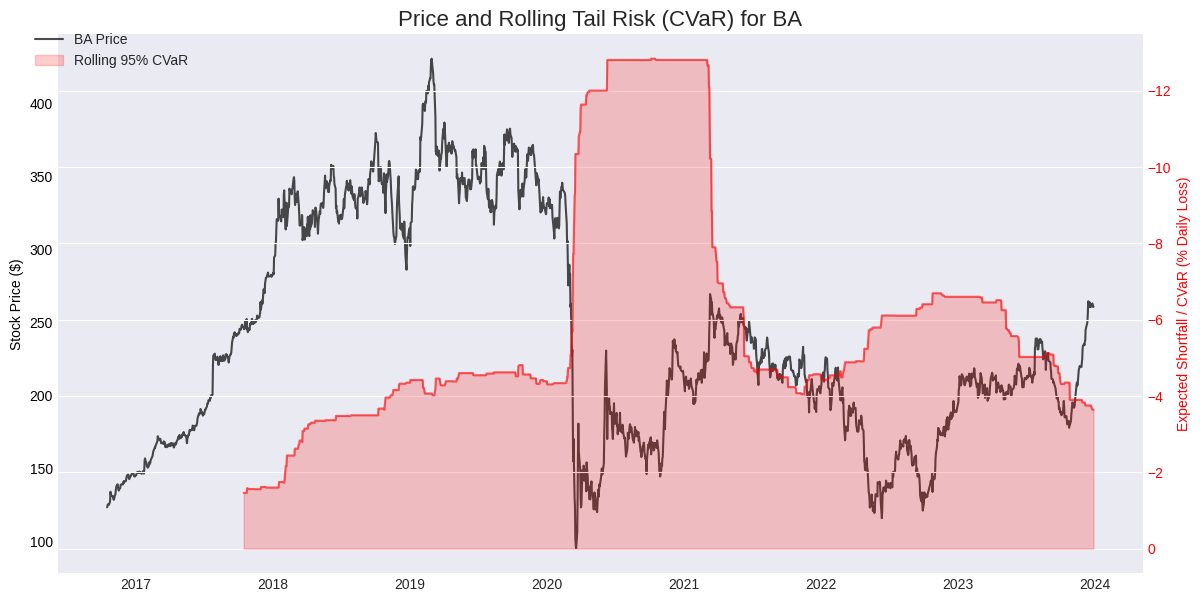

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
import warnings

warnings.filterwarnings('ignore')

def run_spillover_analysis(file_path, tickers_list, forecast_horizon=10):
    """
    Performs a volatility spillover analysis based on the Diebold & Yilmaz methodology.
    """
    print("--- Running Volatility Spillover Index Analysis ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare Volatility Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)

    # We will use the 'Volatility_20' column as our measure of daily volatility
    vol_pivot = df_full.pivot(index='Date', columns='Ticker', values='Volatility_20')
    vol_data = vol_pivot[tickers_list].dropna()

    if vol_data.empty:
        print("Could not prepare volatility data for the selected tickers.")
        return

    # --- Step 2: Fit the VAR Model on Volatilities ---
    print("  > Fitting VAR model to the volatility series...")
    model = VAR(vol_data)
    # Using a common lag order for simplicity
    results = model.fit(5)

    # --- Step 3: Calculate Forecast Error Variance Decomposition (FEVD) ---
    print("  > Calculating Forecast Error Variance Decomposition (FEVD)...")
    fevd = results.fevd(forecast_horizon)

    # Get the decomposition for the final day of the forecast horizon
    fevd_matrix = fevd.summary().split('--------------------')[-1]
    # This part is a bit of parsing to get the matrix into a nice DataFrame
    rows = [row.strip().split() for row in fevd_matrix.strip().split('\n')]
    fevd_df = pd.DataFrame(rows[1:], columns=rows[0]).set_index(rows[0][0]).astype(float)

    # --- Step 4: Calculate the Spillover Index and Contributions ---
    # Normalize the FEVD matrix so each row sums to 100
    fevd_normalized = fevd_df.div(fevd_df.sum(axis=1), axis=0) * 100

    # Total Spillover Index = (Sum of all off-diagonal elements) / (Sum of all elements)
    off_diagonal_sum = fevd_normalized.values.sum() - np.diag(fevd_normalized).sum()
    total_spillover_index = off_diagonal_sum / fevd_normalized.values.sum() * 100

    # Contributions TO others (how much risk a stock TRANSMITS)
    contribution_to_others = fevd_normalized.sum(axis=0) - np.diag(fevd_normalized)

    # Contributions FROM others (how much risk a stock RECEIVES)
    contribution_from_others = fevd_normalized.sum(axis=1) - np.diag(fevd_normalized)

    # --- Step 5: Visualize and Report ---
    print("\n--- Spillover Matrix Heatmap ---")
    plt.figure(figsize=(10, 8))
    sns.heatmap(fevd_normalized, annot=True, cmap='YlGnBu', fmt=".1f")
    plt.title(f'Volatility Spillover Matrix (Contribution of shock in column to row)', fontsize=16)
    plt.ylabel('Variance Forecast Error IN')
    plt.xlabel('Shock FROM')
    plt.savefig('spillover_heatmap.png')
    plt.show()

    print("\n" + "="*60)
    print("           Systemic Risk Spillover Report")
    print("="*60)
    print(f"Total Volatility Spillover Index: {total_spillover_index:.2f}%")
    print("-"*60)
    print("Contribution Analysis:")
    report_df = pd.DataFrame({
        'Transmits To Others': contribution_to_others,
        'Receives From Others': contribution_from_others,
        'Net Spillover (Transmit - Receive)': contribution_to_others - contribution_from_others
    })
    print(report_df.round(2).sort_values(by='Net Spillover (Transmit - Receive)', ascending=False))
    print("="*60)


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'

# A diverse list of tickers from different sectors
tickers_for_analysis = ['AAPL', 'JPM', 'XOM', 'JNJ', 'TSLA', 'PG']

run_spillover_analysis(your_daily_file, tickers_for_analysis)


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
import warnings

warnings.filterwarnings('ignore')

def run_spillover_analysis(file_path, tickers_list, forecast_horizon=10):
    """
    Performs a volatility spillover analysis based on the Diebold & Yilmaz methodology.
    """
    print("--- Running Volatility Spillover Index Analysis ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare Volatility Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)

    vol_pivot = df_full.pivot(index='Date', columns='Ticker', values='Volatility_20')
    vol_data = vol_pivot[tickers_list].dropna()

    if vol_data.empty:
        print("Could not prepare volatility data for the selected tickers.")
        return

    # --- Step 2: Fit the VAR Model on Volatilities ---
    print("  > Fitting VAR model to the volatility series...")
    model = VAR(vol_data)
    results = model.fit(5)

    # --- Step 3: Calculate Forecast Error Variance Decomposition (FEVD) ---
    print("  > Calculating Forecast Error Variance Decomposition (FEVD)...")
    fevd = results.fevd(forecast_horizon)

    # --- FIXED: Robustly parse the entire FEVD summary ---
    summary_text = fevd.summary()
    if summary_text is None:
        print("Error: Could not generate FEVD summary. The VAR model may be unstable.")
        return

    # Each variable's decomposition is in a separate table. We parse each one.
    fevd_tables = summary_text.split('FEVD for ')[1:]
    all_fevd_rows = {}

    for table in fevd_tables:
        lines = table.strip().split('\n')
        var_name = lines[0].strip() # e.g., 'Volatility_20(AAPL)'
        # For this model, we only care about the final step of the horizon
        last_line = lines[-1].strip().split()
        # The values are the numbers after the first element (the horizon step)
        fevd_values = [float(val) for val in last_line[1:]]
        all_fevd_rows[var_name] = fevd_values

    fevd_df = pd.DataFrame(all_fevd_rows, index=vol_data.columns).T
    # --- End of Fix ---

    # --- Step 4: Calculate the Spillover Index and Contributions ---
    fevd_normalized = fevd_df.div(fevd_df.sum(axis=1), axis=0) * 100

    off_diagonal_sum = fevd_normalized.values.sum() - np.diag(fevd_normalized).sum()
    total_spillover_index = off_diagonal_sum / fevd_normalized.values.sum() * 100

    contribution_to_others = fevd_normalized.sum(axis=0) - np.diag(fevd_normalized)
    contribution_from_others = fevd_normalized.sum(axis=1) - np.diag(fevd_normalized)

    # --- Step 5: Visualize and Report ---
    print("\n--- Spillover Matrix Heatmap ---")
    plt.figure(figsize=(10, 8))
    sns.heatmap(fevd_normalized, annot=True, cmap='YlGnBu', fmt=".1f")
    plt.title(f'Volatility Spillover Matrix (Contribution of shock in column to row)', fontsize=16)
    plt.ylabel('Variance Forecast Error IN')
    plt.xlabel('Shock FROM')
    plt.savefig('spillover_heatmap.png')
    plt.show()

    print("\n" + "="*60)
    print("           Systemic Risk Spillover Report")
    print("="*60)
    print(f"Total Volatility Spillover Index: {total_spillover_index:.2f}%")
    print("-"*60)
    print("Contribution Analysis:")
    report_df = pd.DataFrame({
        'Transmits To Others': contribution_to_others,
        'Receives From Others': contribution_from_others,
        'Net Spillover (Transmit - Receive)': contribution_to_others - contribution_from_others
    })
    print(report_df.round(2).sort_values(by='Net Spillover (Transmit - Receive)', ascending=False))
    print("="*60)


# --- Run the Analysis ---
your_daily_file = '/content/hybrid_quant_dataset.csv'

tickers_for_analysis = ['AAPL', 'JPM', 'XOM', 'JNJ', 'TSLA', 'PG']

run_spillover_analysis(your_daily_file, tickers_for_analysis)


--- Running Volatility Spillover Index Analysis ---
  > Fitting VAR model to the volatility series...
  > Calculating Forecast Error Variance Decomposition (FEVD)...
FEVD for AAPL
         AAPL       JPM       XOM       JNJ      TSLA        PG
0    1.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1    0.997570  0.001320  0.000091  0.000936  0.000070  0.000013
2    0.996361  0.001241  0.000237  0.001436  0.000661  0.000064
3    0.994546  0.000860  0.000743  0.001979  0.001297  0.000575
4    0.992411  0.000659  0.001604  0.002769  0.001535  0.001021
5    0.990135  0.000536  0.002828  0.003618  0.001524  0.001359
6    0.987666  0.000442  0.004390  0.004404  0.001464  0.001636
7    0.984963  0.000378  0.006217  0.005078  0.001452  0.001913
8    0.982002  0.000385  0.008252  0.005594  0.001544  0.002222
9    0.978738  0.000522  0.010419  0.005936  0.001806  0.002580

FEVD for JPM
         AAPL       JPM       XOM       JNJ      TSLA        PG
0    0.022297  0.977703  0.000000  0.0

--- Running Comparative Risk Analysis ---
  > Downloading historical data for ['AAPL', 'BTC-USD']...

--- Analyzing Asset: AAPL ---
  > Fitting GARCH model and calculating daily VaR...


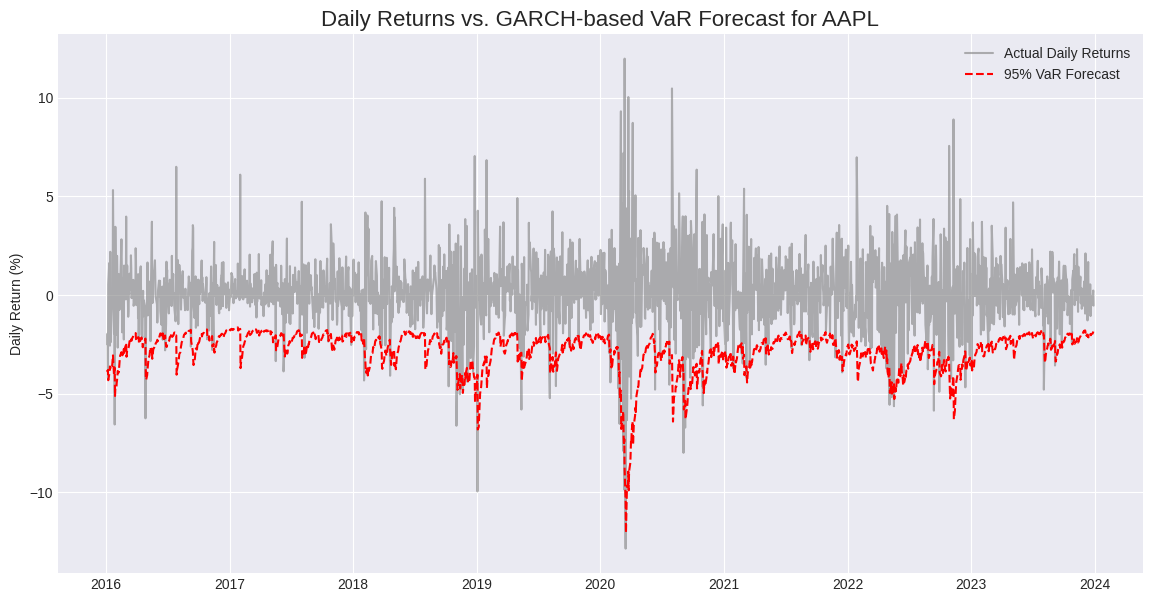

  > Calculating rolling Conditional Value-at-Risk (CVaR)...


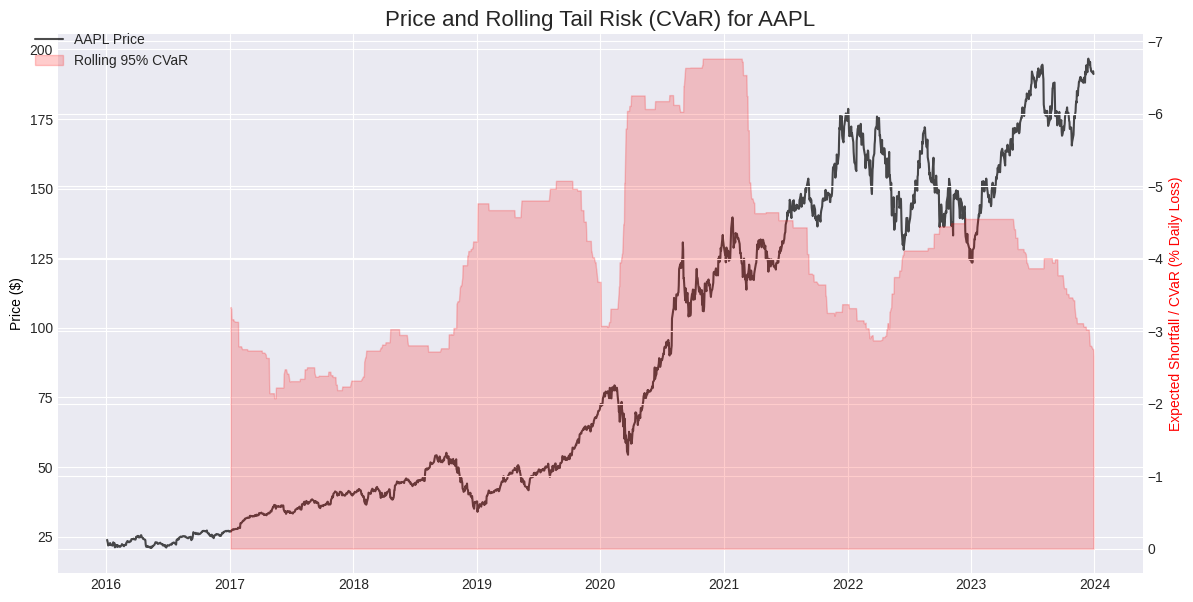


--- Analyzing Asset: BTC-USD ---
  > Fitting GARCH model and calculating daily VaR...


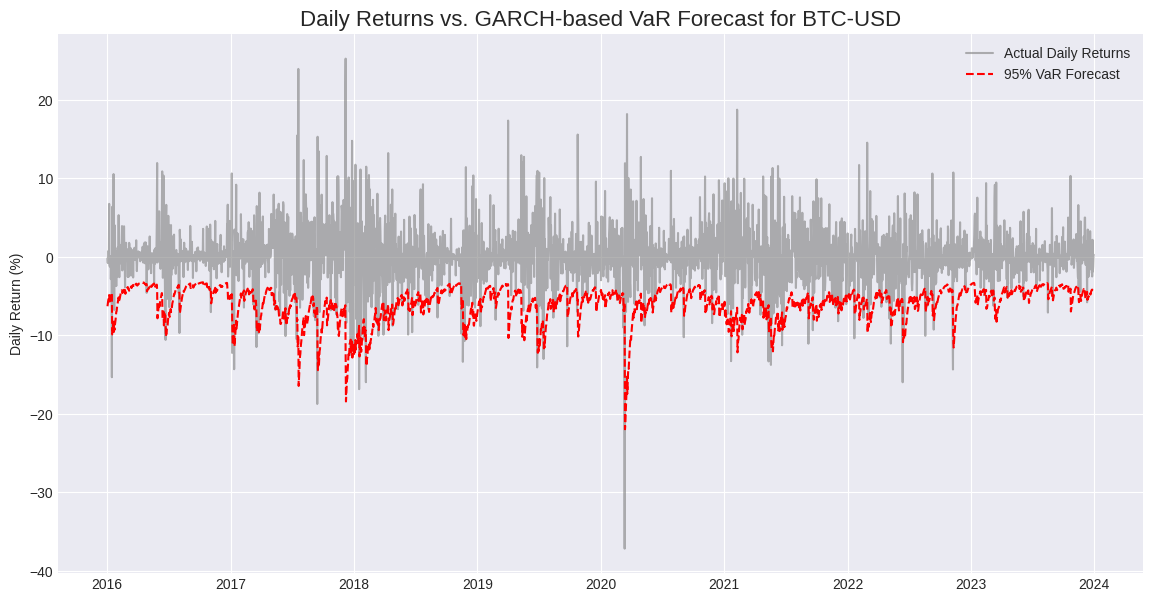

  > Calculating rolling Conditional Value-at-Risk (CVaR)...


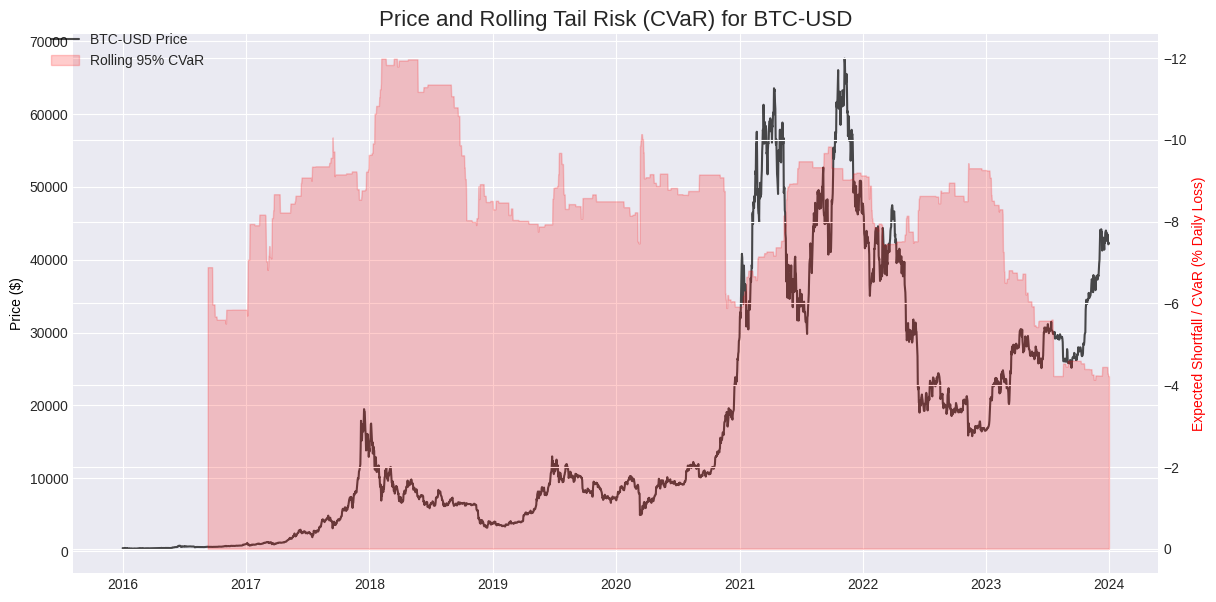

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import norm
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

# Note: This script requires the 'arch' and 'yfinance' libraries.
# You may need to install them: pip install arch yfinance

def run_comparative_risk_analysis(assets_to_compare, start_date='2016-01-01', end_date='2024-01-01'):
    """
    Performs a comparative GARCH-VaR and Rolling CVaR analysis between
    a traditional equity and a cryptocurrency.
    """
    print("--- Running Comparative Risk Analysis ---")

    # --- Step 1: Download Data for All Assets ---
    print(f"  > Downloading historical data for {assets_to_compare}...")
    try:
        data = yf.download(assets_to_compare, start=start_date, end=end_date, progress=False)
        if data.empty:
            print("Error: Could not download market data.")
            return
    except Exception as e:
        print(f"An error occurred during data download: {e}")
        return

    # --- Step 2: Loop Through Each Asset to Analyze and Plot ---
    for asset in assets_to_compare:
        print(f"\n--- Analyzing Asset: {asset} ---")

        # Prepare the data for the current asset
        asset_df = data['Close'][[asset]].dropna()
        returns = asset_df[asset].pct_change().dropna() * 100

        if returns.empty:
            print(f"  > Not enough data for {asset} to perform analysis.")
            continue

        # --- Analysis 1: GARCH-based Value-at-Risk (VaR) ---
        print("  > Fitting GARCH model and calculating daily VaR...")
        model = arch_model(returns, vol='Garch', p=1, q=1)
        model_fit = model.fit(disp='off')
        conditional_volatility = model_fit.conditional_volatility
        var_95 = conditional_volatility * norm.ppf(0.05)

        # Visualize VaR
        plt.figure(figsize=(14, 7))
        plt.plot(returns.index, returns, label='Actual Daily Returns', color='grey', alpha=0.6)
        plt.plot(var_95.index, var_95, label='95% VaR Forecast', color='red', linestyle='--')
        plt.title(f'Daily Returns vs. GARCH-based VaR Forecast for {asset}', fontsize=16)
        plt.ylabel('Daily Return (%)'); plt.legend()
        plt.savefig(f'garch_var_{asset}.png')
        plt.show()

        # --- Analysis 2: Rolling Conditional Value-at-Risk (CVaR) ---
        print("  > Calculating rolling Conditional Value-at-Risk (CVaR)...")
        window_size = 252 # 1 year

        def calculate_cvar(window):
            var_threshold = window.quantile(0.05)
            tail_losses = window[window < var_threshold]
            return tail_losses.mean() if not tail_losses.empty else np.nan

        rolling_cvar = returns.rolling(window=window_size).apply(calculate_cvar).dropna()

        # Visualize Rolling CVaR
        fig, ax1 = plt.subplots(figsize=(14, 7))
        ax1.set_title(f'Price and Rolling Tail Risk (CVaR) for {asset}', fontsize=16)
        ax1.plot(asset_df.index, asset_df[asset], label=f'{asset} Price', color='black', alpha=0.7)
        ax1.set_ylabel('Price ($)', color='black')
        ax2 = ax1.twinx()
        ax2.fill_between(rolling_cvar.index, rolling_cvar, 0, color='red', alpha=0.2, label='Rolling 95% CVaR')
        ax2.set_ylabel('Expected Shortfall / CVaR (% Daily Loss)', color='red')
        ax2.invert_yaxis()
        fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
        plt.savefig(f'cvar_dashboard_{asset}.png')
        plt.show()

# --- Run the Comparative Analysis ---
assets_to_analyze = ['AAPL', 'BTC-USD']
run_comparative_risk_analysis(assets_to_analyze)


#GA

In [57]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

def run_genetic_portfolio_optimizer(file_path, tickers_list, population_size=100, generations=50, mutation_rate=0.01):
    """
    Uses a Genetic Algorithm to find the optimal portfolio weights to maximize the Sharpe Ratio.
    """
    print("--- Running Genetic Algorithm for Portfolio Optimization ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    df_full.set_index('Date', inplace=True)

    # Create a monthly returns dataframe for our chosen tickers
    price_pivot = df_full.pivot(columns='Ticker', values='Close')
    monthly_returns = price_pivot[tickers_list].resample('M').last().pct_change().dropna()

    # Calculate mean returns and the covariance matrix (key inputs for portfolio stats)
    mean_returns = monthly_returns.mean()
    cov_matrix = monthly_returns.cov()

    # --- Step 2: Define the Genetic Algorithm Functions ---

    def create_individual(n_assets):
        # Create a random portfolio (weights must sum to 1)
        weights = np.random.random(n_assets)
        return weights / np.sum(weights)

    def create_population(n_individuals, n_assets):
        return [create_individual(n_assets) for _ in range(n_individuals)]

    def calculate_fitness(weights, mean_returns, cov_matrix):
        # The fitness function is the Sharpe Ratio
        portfolio_return = np.sum(mean_returns * weights) * 12 # Annualized
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12) # Annualized
        sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility != 0 else 0
        return sharpe_ratio

    def selection(population, fitness_scores):
        # Select the top 20% of the population to be parents
        top_performers_indices = np.argsort(fitness_scores)[-int(0.2 * len(population)):]
        return [population[i] for i in top_performers_indices]

    def crossover(parent1, parent2):
        # Create a child by randomly mixing weights from two parents
        child = parent1.copy()
        for i in range(len(child)):
            if np.random.rand() > 0.5:
                child[i] = parent2[i]
        return child / np.sum(child) # Re-normalize to ensure weights sum to 1

    def mutation(individual, rate):
        # Randomly change a small part of the portfolio
        if np.random.rand() < rate:
            random_index = np.random.randint(len(individual))
            individual[random_index] = np.random.rand()
        return individual / np.sum(individual) # Re-normalize

    # --- Step 3: Run the Evolution ---
    n_assets = len(tickers_list)
    population = create_population(population_size, n_assets)

    print("Evolving portfolio allocations...")
    for generation in range(generations):
        fitness_scores = [calculate_fitness(ind, mean_returns, cov_matrix) for ind in population]
        parents = selection(population, fitness_scores)

        # Create the next generation
        next_generation = parents # Keep the elite
        while len(next_generation) < population_size:
            parent1_idx, parent2_idx = np.random.choice(len(parents), 2, replace=False)
            child = crossover(parents[parent1_idx], parents[parent2_idx])
            child = mutation(child, mutation_rate)
            next_generation.append(child)

        population = next_generation
        if (generation + 1) % 10 == 0:
            print(f"  > Generation {generation+1}/{generations} - Best Sharpe Ratio: {max(fitness_scores):.2f}")

    # --- Step 4: Present the Final Optimized Portfolio ---
    final_fitness_scores = [calculate_fitness(ind, mean_returns, cov_matrix) for ind in population]
    best_individual = population[np.argmax(final_fitness_scores)]
    best_fitness = max(final_fitness_scores)

    print("\n" + "="*50)
    print("      Optimized Portfolio Found")
    print("="*50)
    print(f"Optimal Sharpe Ratio: {best_fitness:.4f}")
    print("\nOptimal Asset Allocation:")
    for i, ticker in enumerate(tickers_list):
        print(f"  > {ticker}: {best_individual[i]*100:.2f}%")
    print("="*50)

# --- Run the Optimizer ---
# A diverse list of tickers for portfolio construction
your_daily_file = '/content/hybrid_quant_dataset.csv'
portfolio_tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'XOM', 'PG', 'V']

run_genetic_portfolio_optimizer(your_daily_file, portfolio_tickers)


--- Running Genetic Algorithm for Portfolio Optimization ---
Evolving portfolio allocations...
  > Generation 10/50 - Best Sharpe Ratio: 1.49
  > Generation 20/50 - Best Sharpe Ratio: 1.49
  > Generation 30/50 - Best Sharpe Ratio: 1.49
  > Generation 40/50 - Best Sharpe Ratio: 1.49
  > Generation 50/50 - Best Sharpe Ratio: 1.49

      Optimized Portfolio Found
Optimal Sharpe Ratio: 1.4929

Optimal Asset Allocation:
  > AAPL: 6.53%
  > MSFT: 67.98%
  > JNJ: 0.43%
  > JPM: 7.79%
  > XOM: 0.05%
  > PG: 16.92%
  > V: 0.31%


In [58]:
df.columns

Index(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'Return',
       'MA_20', 'MA_50', 'MA_200', 'Volatility_20', 'RSI_14', 'MACD', 'ATR_14',
       'Beta', 'PE_Ratio', 'PB_Ratio', 'EPS_TTM', 'Dividend_Yield',
       'Market_Cap'],
      dtype='object')

In [59]:
import pandas as pd
import numpy as np

def calculate_multi_factor_fitness(all_stocks_latest_data):
    """
    Calculates a multi-factor fitness score for every stock in the dataset.

    This function takes the latest data for all stocks and engineers a final
    "fitness score" based on a weighted combination of Value, Quality, and
    Momentum factors.

    Args:
        all_stocks_latest_data (pd.DataFrame): A DataFrame containing the most
                                               recent row of data for every stock.

    Returns:
        pd.DataFrame: The input DataFrame with new columns for each factor
                      score and the final 'Fitness_Score'.
    """
    df = all_stocks_latest_data.copy()

    # --- Step 1: Data Cleaning ---
    # Ensure we only work with stocks that have valid data for our factors
    required_cols = ['PE_Ratio', 'PB_Ratio', 'EPS_TTM', 'Volatility_20', 'RSI_14', 'Return']
    df = df[(df['PE_Ratio'] > 0) & (df['EPS_TTM'] > 0)].dropna(subset=required_cols)

    # --- Step 2: Calculate Percentile Ranks for Each Metric ---
    # This normalizes each metric to a score from 0 to 100.

    # Value Metrics (lower is better, so ascending=True)
    df['PE_Rank'] = df['PE_Ratio'].rank(ascending=True, pct=True) * 100
    df['PB_Rank'] = df['PB_Ratio'].rank(ascending=True, pct=True) * 100

    # Quality Metrics (higher EPS is better, lower Volatility is better)
    df['EPS_Rank'] = df['EPS_TTM'].rank(ascending=False, pct=True) * 100
    df['Volatility_Rank'] = df['Volatility_20'].rank(ascending=True, pct=True) * 100

    # Momentum Metrics (higher is better, so ascending=False)
    df['RSI_Rank'] = df['RSI_14'].rank(ascending=False, pct=True) * 100
    df['Return_Rank'] = df['Return'].rank(ascending=False, pct=True) * 100

    # --- Step 3: Calculate Weighted Factor Scores ---
    df['Value_Score'] = (df['PE_Rank'] * 0.5) + (df['PB_Rank'] * 0.5)
    df['Quality_Score'] = (df['EPS_Rank'] * 0.5) + (df['Volatility_Rank'] * 0.5)
    df['Momentum_Score'] = (df['RSI_Rank'] * 0.5) + (df['Return_Rank'] * 0.5)

    # --- Step 4: Calculate the Final, Weighted Fitness Score ---
    value_weight = 0.40
    quality_weight = 0.30
    momentum_weight = 0.30

    df['Fitness_Score'] = (df['Value_Score'] * value_weight +
                           df['Quality_Score'] * quality_weight +
                           df['Momentum_Score'] * momentum_weight)

    return df

# --- Example Usage ---
# 1. Load your dataset
try:
    full_df = pd.read_csv('/content/hybrid_quant_dataset.csv')
    full_df['Date'] = pd.to_datetime(full_df['Date'], errors='coerce', utc=True)

    # 2. Get the latest data for all tickers
    latest_data_all_stocks = full_df.loc[full_df.groupby('Ticker')['Date'].idxmax()]

    # 3. Calculate the fitness scores
    df_with_fitness = calculate_multi_factor_fitness(latest_data_all_stocks)

    # 4. Display the top 10 "fittest" stocks
    print("--- Top 10 Fittest Stocks based on Multi-Factor Model ---")

    report_cols = ['Ticker', 'Fitness_Score', 'Value_Score', 'Quality_Score', 'Momentum_Score']
    top_10 = df_with_fitness.sort_values('Fitness_Score', ascending=False).head(10)

    print(top_10[report_cols].round(2).to_string(index=False))

except FileNotFoundError:
    print("Dataset file not found. Please upload 'Sample dataset for chatgpt and Gemini.xlsx - Sheet1.csv'.")



--- Top 10 Fittest Stocks based on Multi-Factor Model ---
Ticker  Fitness_Score  Value_Score  Quality_Score  Momentum_Score
  TSLA          90.45        86.36         100.00           86.36
  AAPL          74.09        72.73          59.09           90.91
  NVDA          64.09        95.45          54.55           31.82
  AMZN          62.73        54.55          72.73           63.64
  MSFT          56.36        72.73          40.91           50.00
     V          55.45        77.27          36.36           45.45
    PG          48.64        50.00          59.09           36.36
  GOOG          45.91        36.36          59.09           45.45
   XOM          40.91        13.64          40.91           77.27
   JNJ          31.36        27.27          27.27           40.91


--- Running Genetic Algorithm for Portfolio Optimization ---
Evolving portfolio allocations...
  > Gen 10/50 - Best Sharpe: 1.46
  > Gen 20/50 - Best Sharpe: 1.48
  > Gen 30/50 - Best Sharpe: 1.49
  > Gen 40/50 - Best Sharpe: 1.49
  > Gen 50/50 - Best Sharpe: 1.49

Optimized portfolio visualization saved as 'ga_optimized_portfolio.png'


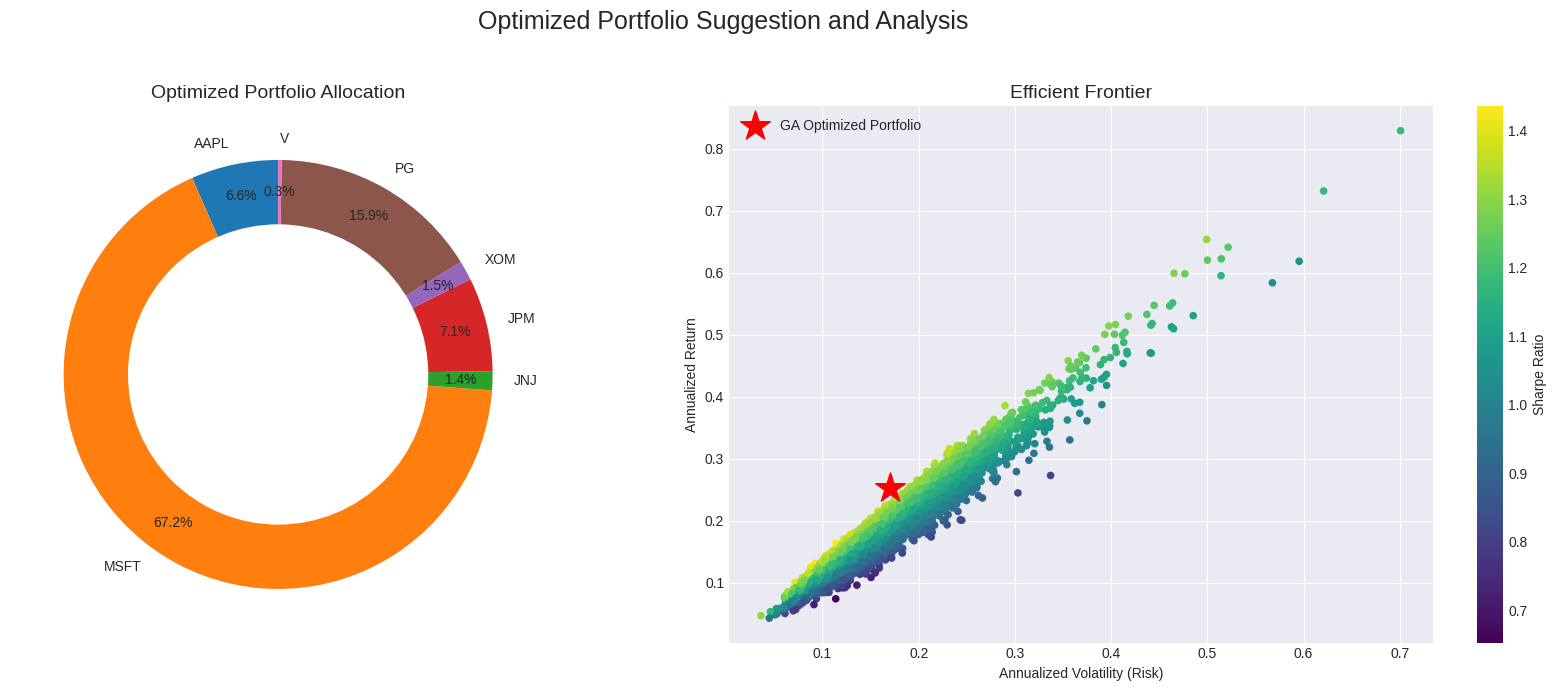

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def run_and_visualize_ga_optimizer(file_path, tickers_list, population_size=100, generations=50, mutation_rate=0.01):
    """
    Runs a Genetic Algorithm to find the optimal portfolio and visualizes
    the result with a pie chart and an Efficient Frontier plot.
    """
    print("--- Running Genetic Algorithm for Portfolio Optimization ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload it.")
        return

    # --- Step 1: Prepare the Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    df_full.set_index('Date', inplace=True)

    price_pivot = df_full.pivot(columns='Ticker', values='Close')
    monthly_returns = price_pivot[tickers_list].resample('M').last().pct_change().dropna()

    mean_returns = monthly_returns.mean()
    cov_matrix = monthly_returns.cov()

    # --- (Genetic Algorithm functions from previous script: create_individual, fitness, etc.) ---
    def create_individual(n): return np.random.random(n) / np.sum(np.random.random(n))
    def create_population(p_size, n): return [create_individual(n) for _ in range(p_size)]
    def calculate_fitness(w, mr, cm):
        ret = np.sum(mr * w) * 12
        vol = np.sqrt(np.dot(w.T, np.dot(cm, w))) * np.sqrt(12)
        return ret / vol if vol != 0 else 0
    def selection(pop, scores): return [pop[i] for i in np.argsort(scores)[-int(0.2*len(pop)):]]
    def crossover(p1, p2):
        c = p1.copy()
        for i in range(len(c)):
            if np.random.rand() > 0.5: c[i] = p2[i]
        return c / np.sum(c)
    def mutation(ind, rate):
        if np.random.rand() < rate: ind[np.random.randint(len(ind))] = np.random.rand()
        return ind / np.sum(ind)

    # --- Step 2: Run the Evolution ---
    n_assets = len(tickers_list)
    population = create_population(population_size, n_assets)
    print("Evolving portfolio allocations...")
    for generation in range(generations):
        fitness_scores = [calculate_fitness(ind, mean_returns, cov_matrix) for ind in population]
        parents = selection(population, fitness_scores)
        next_gen = parents
        while len(next_gen) < population_size:
            p1, p2 = np.random.choice(len(parents), 2, replace=False)
            child = crossover(parents[p1], parents[p2])
            child = mutation(child, mutation_rate)
            next_gen.append(child)
        population = next_gen
        if (generation + 1) % 10 == 0:
            print(f"  > Gen {generation+1}/{generations} - Best Sharpe: {max(fitness_scores):.2f}")

    # --- Step 3: Get the Best Portfolio and Generate Random Portfolios for the Frontier ---
    final_scores = [calculate_fitness(ind, mean_returns, cov_matrix) for ind in population]
    best_weights = population[np.argmax(final_scores)]

    # Generate thousands of random portfolios for the plot
    num_random_portfolios = 5000
    random_results = np.zeros((3, num_random_portfolios))
    for i in range(num_random_portfolios):
        weights = create_individual(n_assets)
        p_return = np.sum(mean_returns * weights) * 12
        p_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
        random_results[0,i] = p_return
        random_results[1,i] = p_volatility
        random_results[2,i] = p_return / p_volatility

    # --- Step 4: Visualize the Results ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Optimized Portfolio Suggestion and Analysis', fontsize=18)

    # Plot 1: Pie Chart of the Optimized Portfolio
    ax1.pie(best_weights, labels=tickers_list, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    ax1.set_title('Optimized Portfolio Allocation', fontsize=14)
    # Draw a circle to make it a donut chart
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax1.add_artist(centre_circle)

    # Plot 2: Efficient Frontier
    # Scatter plot of all the random portfolios
    scatter = ax2.scatter(random_results[1,:], random_results[0,:], c=random_results[2,:], cmap='viridis', marker='o', s=20)
    # Highlight the GA-optimized portfolio
    best_return = np.sum(mean_returns * best_weights) * 12
    best_volatility = np.sqrt(np.dot(best_weights.T, np.dot(cov_matrix, best_weights))) * np.sqrt(12)
    ax2.scatter(best_volatility, best_return, marker='*', color='red', s=500, label='GA Optimized Portfolio')

    ax2.set_title('Efficient Frontier', fontsize=14)
    ax2.set_xlabel('Annualized Volatility (Risk)')
    ax2.set_ylabel('Annualized Return')
    ax2.legend(labelspacing=0.8)
    fig.colorbar(scatter, ax=ax2, label='Sharpe Ratio')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('ga_optimized_portfolio.png')
    print("\nOptimized portfolio visualization saved as 'ga_optimized_portfolio.png'")
    plt.show()

# --- Run the Optimizer and Visualization ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
portfolio_tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'XOM', 'PG', 'V']
run_and_visualize_ga_optimizer(your_daily_file, portfolio_tickers)


--- Running GA Strategy Optimizer for TSLA ---
Evolving strategy parameters...
  > Gen 5/30 - Best Sharpe Found: 1.04
  > Gen 10/30 - Best Sharpe Found: 1.08
  > Gen 15/30 - Best Sharpe Found: 1.08
  > Gen 20/30 - Best Sharpe Found: 1.08
  > Gen 25/30 - Best Sharpe Found: 1.08
  > Gen 30/30 - Best Sharpe Found: 1.08

           Strategy Optimization Results
Original Parameters: RSI<45, SL=2.0*ATR, PT=3.0*Risk
GA-Optimized Parameters: RSI<22, SL=2.0*ATR, PT=3.0*Risk
------------------------------------------------------------


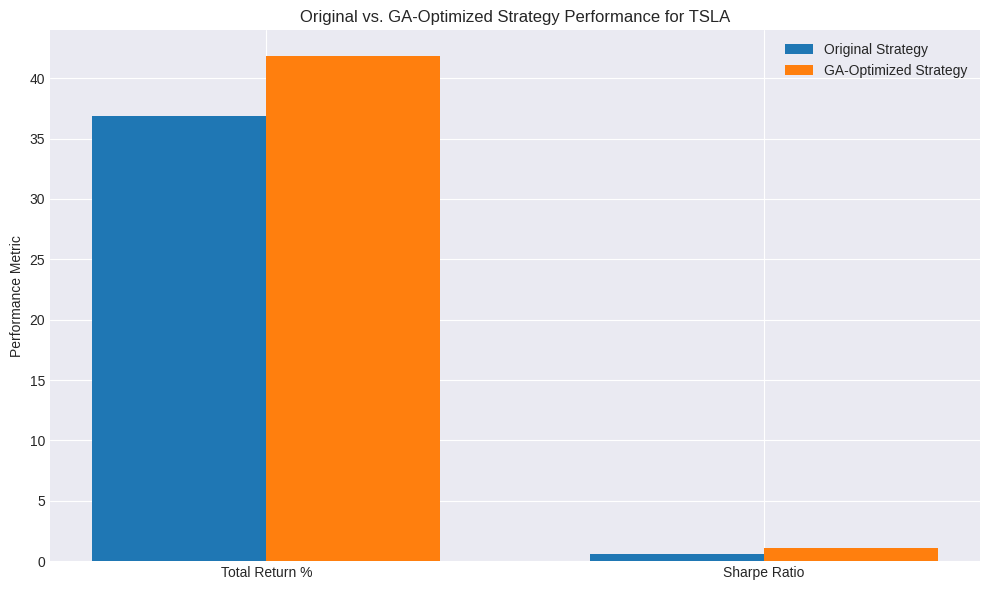

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def run_backtest_for_ga(ticker_df, params):
    """
    A modified backtest engine that takes strategy parameters as input
    and returns the Sharpe Ratio (our fitness score).
    """
    rsi_threshold, stop_loss_mult, profit_target_mult = params
    initial_capital = 100000.0

    # --- Simplified backtest for speed during optimization ---
    cash = initial_capital
    portfolio_value = initial_capital
    holdings = 0
    in_position = False
    portfolio_history = []

    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close'] if in_position else cash
        portfolio_history.append(portfolio_value)

        if in_position:
            if row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price:
                cash += holdings * row['Close']
                holdings, in_position = 0, False
        elif not in_position:
            if row['RSI_14'] < rsi_threshold and row['Close'] > row['Open']:
                risk_per_share = row['ATR_14'] * stop_loss_mult
                if risk_per_share > 0:
                    shares_to_buy = (portfolio_value * 0.02) / risk_per_share
                    entry_value = shares_to_buy * row['Close']
                    if cash >= entry_value:
                        holdings, cash, in_position = shares_to_buy, cash - entry_value, True
                        entry_price = row['Close']
                        stop_loss_price = entry_price - risk_per_share
                        profit_target_price = entry_price + (risk_per_share * profit_target_mult)

    # Calculate Sharpe Ratio
    returns = pd.Series(portfolio_history).pct_change().dropna()
    if returns.std() == 0 or len(returns) < 1: return 0
    sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
    return sharpe_ratio, {'Return': (portfolio_value/initial_capital - 1)*100, 'Sharpe': sharpe_ratio}


def run_ga_strategy_optimizer(file_path, ticker_symbol, population_size=50, generations=30):
    """
    Uses a Genetic Algorithm to find the optimal parameters for a trading strategy.
    """
    print(f"--- Running GA Strategy Optimizer for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy().dropna()

    # --- Step 1: Define the GA Functions ---
    def create_individual():
        # [RSI_threshold, stop_loss_multiplier, profit_target_multiplier]
        return [np.random.uniform(20, 50), np.random.uniform(1.0, 3.0), np.random.uniform(1.5, 5.0)]

    def create_population(): return [create_individual() for _ in range(population_size)]

    def selection(pop, scores): return [pop[i] for i in np.argsort(scores)[-int(0.2*len(pop)):]]

    def crossover(p1, p2): return [(g1+g2)/2 for g1, g2 in zip(p1, p2)] # Simple averaging crossover

    def mutation(ind):
        if np.random.rand() < 0.1: ind[np.random.randint(3)] *= np.random.uniform(0.8, 1.2)
        return ind

    # --- Step 2: Run the Evolution ---
    population = create_population()
    print("Evolving strategy parameters...")
    for gen in range(generations):
        fitness_scores = [run_backtest_for_ga(ticker_df, ind)[0] for ind in population]
        parents = selection(population, fitness_scores)
        next_gen = parents
        while len(next_gen) < population_size:
            p1, p2 = np.random.choice(len(parents), 2, replace=False)
            child = crossover(parents[p1], parents[p2])
            child = mutation(child)
            next_gen.append(child)
        population = next_gen
        if (gen + 1) % 5 == 0:
            print(f"  > Gen {gen+1}/{generations} - Best Sharpe Found: {max(fitness_scores):.2f}")

    # --- Step 3: Get the Best Strategy and Compare ---
    final_scores_and_stats = [run_backtest_for_ga(ticker_df, ind) for ind in population]
    final_scores = [s[0] for s in final_scores_and_stats]
    best_params = population[np.argmax(final_scores)]

    # Get stats for the original and optimized strategies
    original_params = [45, 2.0, 3.0]
    original_stats = run_backtest_for_ga(ticker_df, original_params)[1]
    optimized_stats = final_scores_and_stats[np.argmax(final_scores)][1]

    print("\n" + "="*60)
    print("           Strategy Optimization Results")
    print("="*60)
    print("Original Parameters:", f"RSI<{original_params[0]:.0f}, SL={original_params[1]:.1f}*ATR, PT={original_params[2]:.1f}*Risk")
    print("GA-Optimized Parameters:", f"RSI<{best_params[0]:.0f}, SL={best_params[1]:.1f}*ATR, PT={best_params[2]:.1f}*Risk")
    print("-"*60)

    # --- Step 4: Visualize the Comparison ---
    labels = ['Total Return %', 'Sharpe Ratio']
    original = [original_stats['Return'], original_stats['Sharpe']]
    optimized = [optimized_stats['Return'], optimized_stats['Sharpe']]

    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, original, width, label='Original Strategy')
    rects2 = ax.bar(x + width/2, optimized, width, label='GA-Optimized Strategy')

    ax.set_ylabel('Performance Metric')
    ax.set_title(f'Original vs. GA-Optimized Strategy Performance for {ticker_symbol}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.savefig('ga_strategy_optimization.png')
    plt.show()

# --- Run the Optimizer ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_ga_strategy_optimizer(your_daily_file, 'TSLA')


--- Running GA Strategy Optimizer for GOOG ---
Evolving strategy parameters...
  > Gen 5/30 - Best Sharpe Found: 1.18
  > Gen 10/30 - Best Sharpe Found: 1.18
  > Gen 15/30 - Best Sharpe Found: 1.18
  > Gen 20/30 - Best Sharpe Found: 1.18
  > Gen 25/30 - Best Sharpe Found: 1.18
  > Gen 30/30 - Best Sharpe Found: 1.18

           Strategy Optimization Results
Original Parameters: RSI<45, SL=2.0*ATR, PT=3.0*Risk
GA-Optimized Parameters: RSI<46, SL=2.3*ATR, PT=1.6*Risk
------------------------------------------------------------


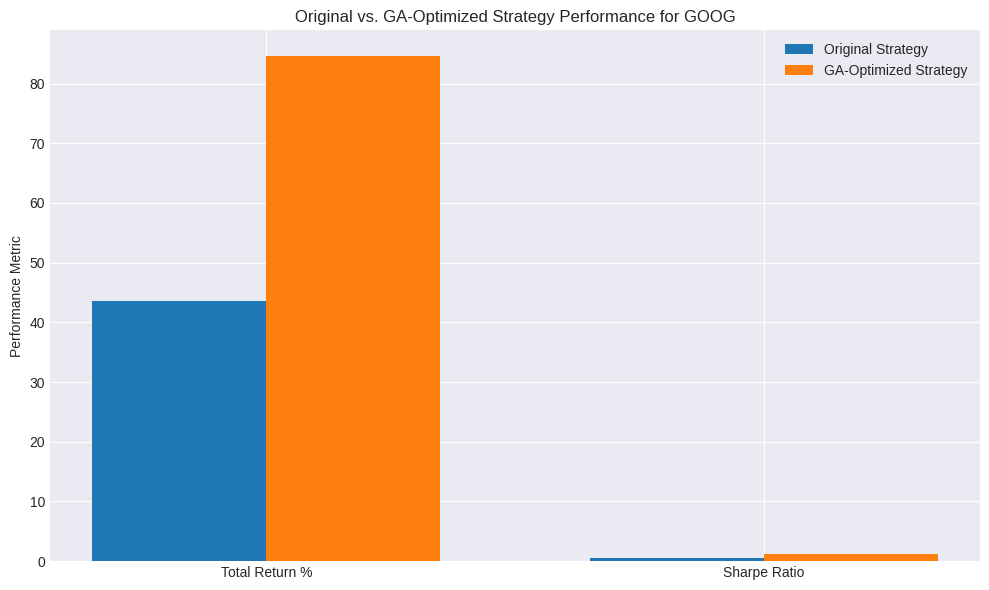

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def run_backtest_for_ga(ticker_df, params):
    """
    A modified backtest engine that takes strategy parameters as input
    and returns the Sharpe Ratio (our fitness score).
    """
    rsi_threshold, stop_loss_mult, profit_target_mult = params
    initial_capital = 100000.0

    # --- Simplified backtest for speed during optimization ---
    cash = initial_capital
    portfolio_value = initial_capital
    holdings = 0
    in_position = False
    portfolio_history = []

    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close'] if in_position else cash
        portfolio_history.append(portfolio_value)

        if in_position:
            if row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price:
                cash += holdings * row['Close']
                holdings, in_position = 0, False
        elif not in_position:
            if row['RSI_14'] < rsi_threshold and row['Close'] > row['Open']:
                risk_per_share = row['ATR_14'] * stop_loss_mult
                if risk_per_share > 0:
                    shares_to_buy = (portfolio_value * 0.02) / risk_per_share
                    entry_value = shares_to_buy * row['Close']
                    if cash >= entry_value:
                        holdings, cash, in_position = shares_to_buy, cash - entry_value, True
                        entry_price = row['Close']
                        stop_loss_price = entry_price - risk_per_share
                        profit_target_price = entry_price + (risk_per_share * profit_target_mult)

    # Calculate Sharpe Ratio
    returns = pd.Series(portfolio_history).pct_change().dropna()
    if returns.std() == 0 or len(returns) < 1: return 0
    sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
    return sharpe_ratio, {'Return': (portfolio_value/initial_capital - 1)*100, 'Sharpe': sharpe_ratio}


def run_ga_strategy_optimizer(file_path, ticker_symbol, population_size=50, generations=30):
    """
    Uses a Genetic Algorithm to find the optimal parameters for a trading strategy.
    """
    print(f"--- Running GA Strategy Optimizer for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy().dropna()

    # --- Step 1: Define the GA Functions ---
    def create_individual():
        # [RSI_threshold, stop_loss_multiplier, profit_target_multiplier]
        return [np.random.uniform(20, 50), np.random.uniform(1.0, 3.0), np.random.uniform(1.5, 5.0)]

    def create_population(): return [create_individual() for _ in range(population_size)]

    def selection(pop, scores): return [pop[i] for i in np.argsort(scores)[-int(0.2*len(pop)):]]

    def crossover(p1, p2): return [(g1+g2)/2 for g1, g2 in zip(p1, p2)] # Simple averaging crossover

    def mutation(ind):
        if np.random.rand() < 0.1: ind[np.random.randint(3)] *= np.random.uniform(0.8, 1.2)
        return ind

    # --- Step 2: Run the Evolution ---
    population = create_population()
    print("Evolving strategy parameters...")
    for gen in range(generations):
        fitness_scores = [run_backtest_for_ga(ticker_df, ind)[0] for ind in population]
        parents = selection(population, fitness_scores)
        next_gen = parents
        while len(next_gen) < population_size:
            p1, p2 = np.random.choice(len(parents), 2, replace=False)
            child = crossover(parents[p1], parents[p2])
            child = mutation(child)
            next_gen.append(child)
        population = next_gen
        if (gen + 1) % 5 == 0:
            print(f"  > Gen {gen+1}/{generations} - Best Sharpe Found: {max(fitness_scores):.2f}")

    # --- Step 3: Get the Best Strategy and Compare ---
    final_scores_and_stats = [run_backtest_for_ga(ticker_df, ind) for ind in population]
    final_scores = [s[0] for s in final_scores_and_stats]
    best_params = population[np.argmax(final_scores)]

    # Get stats for the original and optimized strategies
    original_params = [45, 2.0, 3.0]
    original_stats = run_backtest_for_ga(ticker_df, original_params)[1]
    optimized_stats = final_scores_and_stats[np.argmax(final_scores)][1]

    print("\n" + "="*60)
    print("           Strategy Optimization Results")
    print("="*60)
    print("Original Parameters:", f"RSI<{original_params[0]:.0f}, SL={original_params[1]:.1f}*ATR, PT={original_params[2]:.1f}*Risk")
    print("GA-Optimized Parameters:", f"RSI<{best_params[0]:.0f}, SL={best_params[1]:.1f}*ATR, PT={best_params[2]:.1f}*Risk")
    print("-"*60)

    # --- Step 4: Visualize the Comparison ---
    labels = ['Total Return %', 'Sharpe Ratio']
    original = [original_stats['Return'], original_stats['Sharpe']]
    optimized = [optimized_stats['Return'], optimized_stats['Sharpe']]

    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, original, width, label='Original Strategy')
    rects2 = ax.bar(x + width/2, optimized, width, label='GA-Optimized Strategy')

    ax.set_ylabel('Performance Metric')
    ax.set_title(f'Original vs. GA-Optimized Strategy Performance for {ticker_symbol}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.savefig('ga_strategy_optimization.png')
    plt.show()

# --- Run the Optimizer ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_ga_strategy_optimizer(your_daily_file, 'GOOG')


--- Running GA Strategy Optimizer for JPM ---
Evolving strategy parameters...
  > Gen 5/30 - Best Sharpe Found: 1.00
  > Gen 10/30 - Best Sharpe Found: 1.00
  > Gen 15/30 - Best Sharpe Found: 1.00
  > Gen 20/30 - Best Sharpe Found: 1.00
  > Gen 25/30 - Best Sharpe Found: 1.00
  > Gen 30/30 - Best Sharpe Found: 1.00

           Strategy Optimization Results
Original Parameters: RSI<45, SL=2.0*ATR, PT=3.0*Risk
GA-Optimized Parameters: RSI<31, SL=2.1*ATR, PT=3.3*Risk
------------------------------------------------------------


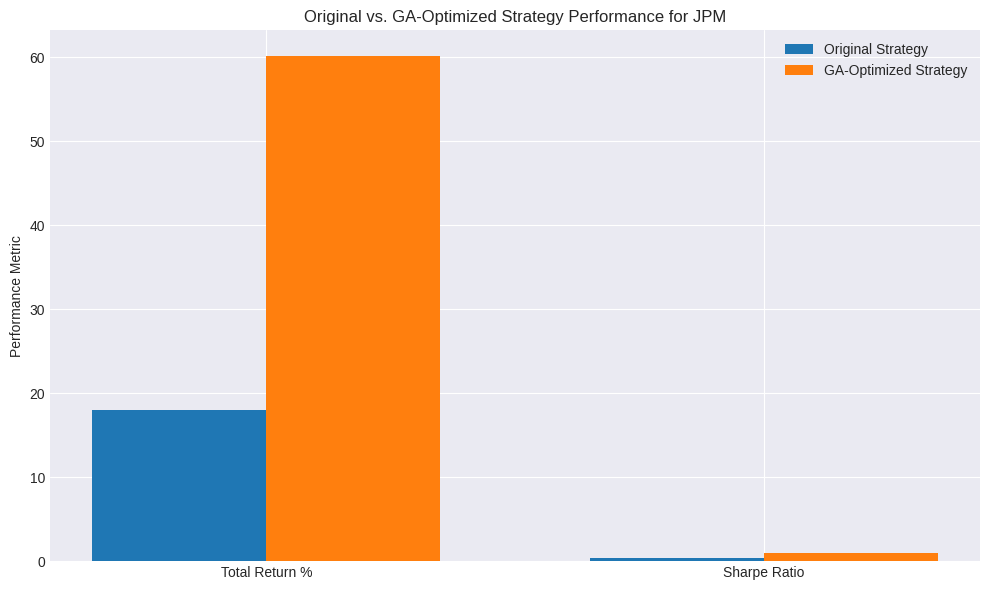

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def run_backtest_for_ga(ticker_df, params):
    """
    A modified backtest engine that takes strategy parameters as input
    and returns the Sharpe Ratio (our fitness score).
    """
    rsi_threshold, stop_loss_mult, profit_target_mult = params
    initial_capital = 100000.0

    # --- Simplified backtest for speed during optimization ---
    cash = initial_capital
    portfolio_value = initial_capital
    holdings = 0
    in_position = False
    portfolio_history = []

    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close'] if in_position else cash
        portfolio_history.append(portfolio_value)

        if in_position:
            if row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price:
                cash += holdings * row['Close']
                holdings, in_position = 0, False
        elif not in_position:
            if row['RSI_14'] < rsi_threshold and row['Close'] > row['Open']:
                risk_per_share = row['ATR_14'] * stop_loss_mult
                if risk_per_share > 0:
                    shares_to_buy = (portfolio_value * 0.02) / risk_per_share
                    entry_value = shares_to_buy * row['Close']
                    if cash >= entry_value:
                        holdings, cash, in_position = shares_to_buy, cash - entry_value, True
                        entry_price = row['Close']
                        stop_loss_price = entry_price - risk_per_share
                        profit_target_price = entry_price + (risk_per_share * profit_target_mult)

    # Calculate Sharpe Ratio
    returns = pd.Series(portfolio_history).pct_change().dropna()
    if returns.std() == 0 or len(returns) < 1: return 0
    sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
    return sharpe_ratio, {'Return': (portfolio_value/initial_capital - 1)*100, 'Sharpe': sharpe_ratio}


def run_ga_strategy_optimizer(file_path, ticker_symbol, population_size=50, generations=30):
    """
    Uses a Genetic Algorithm to find the optimal parameters for a trading strategy.
    """
    print(f"--- Running GA Strategy Optimizer for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy().dropna()

    # --- Step 1: Define the GA Functions ---
    def create_individual():
        # [RSI_threshold, stop_loss_multiplier, profit_target_multiplier]
        return [np.random.uniform(20, 50), np.random.uniform(1.0, 3.0), np.random.uniform(1.5, 5.0)]

    def create_population(): return [create_individual() for _ in range(population_size)]

    def selection(pop, scores): return [pop[i] for i in np.argsort(scores)[-int(0.2*len(pop)):]]

    def crossover(p1, p2): return [(g1+g2)/2 for g1, g2 in zip(p1, p2)] # Simple averaging crossover

    def mutation(ind):
        if np.random.rand() < 0.1: ind[np.random.randint(3)] *= np.random.uniform(0.8, 1.2)
        return ind

    # --- Step 2: Run the Evolution ---
    population = create_population()
    print("Evolving strategy parameters...")
    for gen in range(generations):
        fitness_scores = [run_backtest_for_ga(ticker_df, ind)[0] for ind in population]
        parents = selection(population, fitness_scores)
        next_gen = parents
        while len(next_gen) < population_size:
            p1, p2 = np.random.choice(len(parents), 2, replace=False)
            child = crossover(parents[p1], parents[p2])
            child = mutation(child)
            next_gen.append(child)
        population = next_gen
        if (gen + 1) % 5 == 0:
            print(f"  > Gen {gen+1}/{generations} - Best Sharpe Found: {max(fitness_scores):.2f}")

    # --- Step 3: Get the Best Strategy and Compare ---
    final_scores_and_stats = [run_backtest_for_ga(ticker_df, ind) for ind in population]
    final_scores = [s[0] for s in final_scores_and_stats]
    best_params = population[np.argmax(final_scores)]

    # Get stats for the original and optimized strategies
    original_params = [45, 2.0, 3.0]
    original_stats = run_backtest_for_ga(ticker_df, original_params)[1]
    optimized_stats = final_scores_and_stats[np.argmax(final_scores)][1]

    print("\n" + "="*60)
    print("           Strategy Optimization Results")
    print("="*60)
    print("Original Parameters:", f"RSI<{original_params[0]:.0f}, SL={original_params[1]:.1f}*ATR, PT={original_params[2]:.1f}*Risk")
    print("GA-Optimized Parameters:", f"RSI<{best_params[0]:.0f}, SL={best_params[1]:.1f}*ATR, PT={best_params[2]:.1f}*Risk")
    print("-"*60)

    # --- Step 4: Visualize the Comparison ---
    labels = ['Total Return %', 'Sharpe Ratio']
    original = [original_stats['Return'], original_stats['Sharpe']]
    optimized = [optimized_stats['Return'], optimized_stats['Sharpe']]

    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, original, width, label='Original Strategy')
    rects2 = ax.bar(x + width/2, optimized, width, label='GA-Optimized Strategy')

    ax.set_ylabel('Performance Metric')
    ax.set_title(f'Original vs. GA-Optimized Strategy Performance for {ticker_symbol}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.savefig('ga_strategy_optimization.png')
    plt.show()

# --- Run the Optimizer ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_ga_strategy_optimizer(your_daily_file, 'JPM')


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def run_crossover_backtest(ticker_df, short_window, long_window):
    """
    A fast backtest engine for a simple moving average crossover strategy.
    Returns the final Sharpe Ratio.
    """
    if short_window >= long_window:
        return 0 # Invalid parameters

    df = ticker_df.copy()
    df['Short_MA'] = df['Close'].rolling(window=int(short_window)).mean()
    df['Long_MA'] = df['Close'].rolling(window=int(long_window)).mean()
    df.dropna(inplace=True)

    if df.empty:
        return 0

    # 1 for long, 0 for cash
    df['Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 1, 0)
    df['Position'] = df['Signal'].diff()

    df['Strategy_Return'] = df['Return'] * df['Signal'].shift(1)

    # Calculate Sharpe Ratio
    sharpe_ratio = np.sqrt(252) * df['Strategy_Return'].mean() / df['Strategy_Return'].std()

    return sharpe_ratio if not np.isnan(sharpe_ratio) else 0


def evolve_crossover_strategy(file_path, ticker_symbol, population_size=50, generations=30):
    """
    Uses a Genetic Algorithm to find the optimal moving average crossover parameters.
    """
    print(f"--- Evolving Optimal Crossover Strategy for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()

    # --- Step 1: Define the GA Functions ---
    def create_individual():
        # [short_window, long_window]
        short = np.random.randint(5, 50)
        long = np.random.randint(short + 5, 200) # Ensure long > short
        return [short, long]

    def create_population(): return [create_individual() for _ in range(population_size)]

    def selection(pop, scores): return [pop[i] for i in np.argsort(scores)[-int(0.2*len(pop)):]]

    def crossover(p1, p2):
        # Average the parameters from the parents
        child = [int((p1[0]+p2[0])/2), int((p1[1]+p2[1])/2)]
        # Ensure the rule is still valid (short < long)
        if child[0] >= child[1]:
            child[0] = max(5, child[1] - 5)
        return child

    def mutation(ind):
        if np.random.rand() < 0.1: # 10% mutation chance
            param_to_mutate = np.random.randint(0, 2)
            change = np.random.randint(-5, 6) # Add or subtract up to 5 days
            ind[param_to_mutate] = max(5, ind[param_to_mutate] + change)
            # Ensure the rule is still valid
            if ind[0] >= ind[1]:
                ind[0] = max(5, ind[1] - 5)
        return ind

    # --- Step 2: Run the Evolution ---
    population = create_population()
    print("Evolving crossover parameters...")
    for gen in range(generations):
        fitness_scores = [run_crossover_backtest(ticker_df, *ind) for ind in population]

        parents = selection(population, fitness_scores)
        next_gen = parents
        while len(next_gen) < population_size:
            p1_idx, p2_idx = np.random.choice(len(parents), 2, replace=False)
            child = crossover(parents[p1_idx], parents[p2_idx])
            child = mutation(child)
            next_gen.append(child)
        population = next_gen
        if (gen + 1) % 5 == 0:
            best_params_so_far = population[np.argmax(fitness_scores)]
            print(f"  > Gen {gen+1}/{generations} - Best Sharpe: {max(fitness_scores):.2f} (Params: {best_params_so_far})")

    # --- Step 3: Get the Best Strategy and Compare ---
    final_scores = [run_crossover_backtest(ticker_df, *ind) for ind in population]
    best_params = population[np.argmax(final_scores)]

    # Compare to a standard 20/50 day crossover
    standard_sharpe = run_crossover_backtest(ticker_df, 20, 50)
    optimized_sharpe = max(final_scores)

    print("\n" + "="*60)
    print("           Crossover Strategy Optimization Results")
    print("="*60)
    print(f"Standard Strategy (20/50 Day):")
    print(f"  - Sharpe Ratio: {standard_sharpe:.4f}")
    print(f"\nGA-Evolved Strategy ({best_params[0]}/{best_params[1]} Day):")
    print(f"  - Sharpe Ratio: {optimized_sharpe:.4f}")
    print("="*60)

    # --- Step 4: Visualize the Comparison ---
    labels = ['Standard (20/50)', f'GA-Evolved ({best_params[0]}/{best_params[1]})']
    values = [standard_sharpe, optimized_sharpe]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, color=['skyblue', 'navy'])
    plt.ylabel('Sharpe Ratio')
    plt.title(f'Strategy Performance Comparison for {ticker_symbol}')
    plt.bar_label(bars, fmt='%.2f')
    plt.tight_layout()
    plt.savefig('ga_crossover_optimization.png')
    plt.show()

# --- Run the Optimizer ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_evolve_crossover_strategy(your_daily_file, 'TSLA')


NameError: name 'run_evolve_crossover_strategy' is not defined

--- Evolving Optimal Crossover Strategy for TSLA ---
Evolving crossover parameters...
  > Gen 5/30 - Best Sharpe: 1.40 (Params: [9, 20])
  > Gen 10/30 - Best Sharpe: 1.40 (Params: [9, 17])
  > Gen 15/30 - Best Sharpe: 1.40 (Params: [9, 17])
  > Gen 20/30 - Best Sharpe: 1.40 (Params: [9, 17])
  > Gen 25/30 - Best Sharpe: 1.40 (Params: [9, 17])
  > Gen 30/30 - Best Sharpe: 1.40 (Params: [9, 17])

           Crossover Strategy Optimization Results
Standard Strategy (20/50 Day):
  - Sharpe Ratio: 0.6798

GA-Evolved Strategy (9/17 Day):
  - Sharpe Ratio: 1.4030


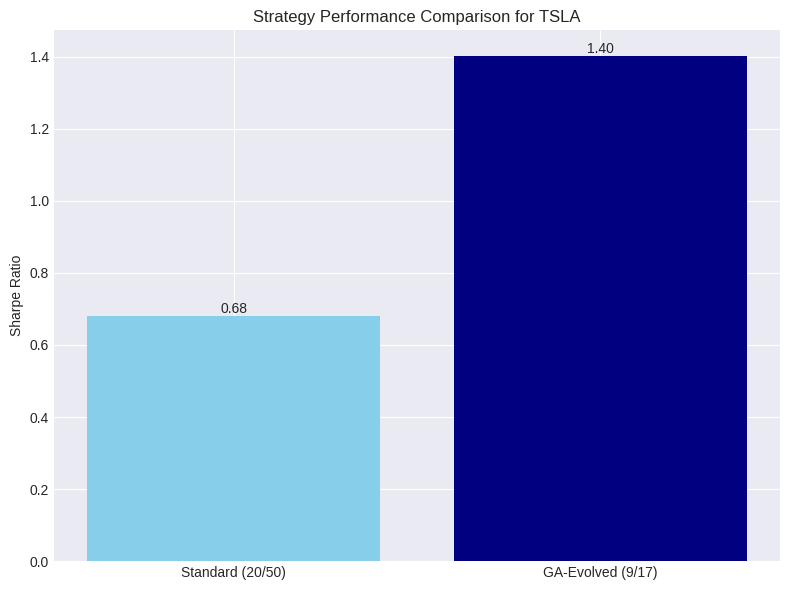

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def run_crossover_backtest(ticker_df, short_window, long_window):
    """
    A fast backtest engine for a simple moving average crossover strategy.
    Returns the final Sharpe Ratio.
    """
    if short_window >= long_window:
        return 0 # Invalid parameters

    df = ticker_df.copy()
    df['Short_MA'] = df['Close'].rolling(window=int(short_window)).mean()
    df['Long_MA'] = df['Close'].rolling(window=int(long_window)).mean()
    df.dropna(inplace=True)

    if df.empty:
        return 0

    # 1 for long, 0 for cash
    df['Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 1, 0)
    df['Position'] = df['Signal'].diff()

    df['Strategy_Return'] = df['Return'] * df['Signal'].shift(1)

    # Calculate Sharpe Ratio
    sharpe_ratio = np.sqrt(252) * df['Strategy_Return'].mean() / df['Strategy_Return'].std()

    return sharpe_ratio if not np.isnan(sharpe_ratio) else 0


def run_evolve_crossover_strategy(file_path, ticker_symbol, population_size=50, generations=30):
    """
    Uses a Genetic Algorithm to find the optimal moving average crossover parameters.
    """
    print(f"--- Evolving Optimal Crossover Strategy for {ticker_symbol} ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    ticker_df = df_full[df_full['Ticker'] == ticker_symbol].copy()

    # --- Step 1: Define the GA Functions ---
    def create_individual():
        # [short_window, long_window]
        short = np.random.randint(5, 50)
        long = np.random.randint(short + 5, 200) # Ensure long > short
        return [short, long]

    def create_population(): return [create_individual() for _ in range(population_size)]

    def selection(pop, scores): return [pop[i] for i in np.argsort(scores)[-int(0.2*len(pop)):]]

    def crossover(p1, p2):
        # Average the parameters from the parents
        child = [int((p1[0]+p2[0])/2), int((p1[1]+p2[1])/2)]
        # Ensure the rule is still valid (short < long)
        if child[0] >= child[1]:
            child[0] = max(5, child[1] - 5)
        return child

    def mutation(ind):
        if np.random.rand() < 0.1: # 10% mutation chance
            param_to_mutate = np.random.randint(0, 2)
            change = np.random.randint(-5, 6) # Add or subtract up to 5 days
            ind[param_to_mutate] = max(5, ind[param_to_mutate] + change)
            # Ensure the rule is still valid
            if ind[0] >= ind[1]:
                ind[0] = max(5, ind[1] - 5)
        return ind

    # --- Step 2: Run the Evolution ---
    population = create_population()
    print("Evolving crossover parameters...")
    for gen in range(generations):
        fitness_scores = [run_crossover_backtest(ticker_df, *ind) for ind in population]

        parents = selection(population, fitness_scores)
        next_gen = parents
        while len(next_gen) < population_size:
            p1_idx, p2_idx = np.random.choice(len(parents), 2, replace=False)
            child = crossover(parents[p1_idx], parents[p2_idx])
            child = mutation(child)
            next_gen.append(child)
        population = next_gen
        if (gen + 1) % 5 == 0:
            best_params_so_far = population[np.argmax(fitness_scores)]
            print(f"  > Gen {gen+1}/{generations} - Best Sharpe: {max(fitness_scores):.2f} (Params: {best_params_so_far})")

    # --- Step 3: Get the Best Strategy and Compare ---
    final_scores = [run_crossover_backtest(ticker_df, *ind) for ind in population]
    best_params = population[np.argmax(final_scores)]

    # Compare to a standard 20/50 day crossover
    standard_sharpe = run_crossover_backtest(ticker_df, 20, 50)
    optimized_sharpe = max(final_scores)

    print("\n" + "="*60)
    print("           Crossover Strategy Optimization Results")
    print("="*60)
    print(f"Standard Strategy (20/50 Day):")
    print(f"  - Sharpe Ratio: {standard_sharpe:.4f}")
    print(f"\nGA-Evolved Strategy ({best_params[0]}/{best_params[1]} Day):")
    print(f"  - Sharpe Ratio: {optimized_sharpe:.4f}")
    print("="*60)

    # --- Step 4: Visualize the Comparison ---
    labels = ['Standard (20/50)', f'GA-Evolved ({best_params[0]}/{best_params[1]})']
    values = [standard_sharpe, optimized_sharpe]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, color=['skyblue', 'navy'])
    plt.ylabel('Sharpe Ratio')
    plt.title(f'Strategy Performance Comparison for {ticker_symbol}')
    plt.bar_label(bars, fmt='%.2f')
    plt.tight_layout()
    plt.savefig('ga_crossover_optimization.png')
    plt.show()

# --- Run the Optimizer ---
your_daily_file = '/content/hybrid_quant_dataset.csv'
run_evolve_crossover_strategy(your_daily_file, 'TSLA')
